In [1]:

import tensorflow as tf
print(tf.__version__)


/Users/chidam_sp/codify_odi/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.14.0


In [2]:

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import gc
import csv
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [4]:

df = pd.read_csv("/Users/chidam_sp/daily_min_temperatures_week4_sequential_time_series_coursera.csv")


In [5]:

df.head()


Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8

In [6]:

len(df)


3650

In [19]:

3650//4


912

In [4]:

def raw_data_to_input(data_source):
    time_step = []
    temps = []
    
    with open(data_source) as csvfile:
      reader = csv.reader(csvfile, delimiter=',')
      next(reader)
      step = 0
      for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1
    
    series = np.array(temps)
    time = np.array(time_step)
    return series, time


In [279]:
del series, time, time_train, x_train, time_test, x_test

In [5]:

series, time = raw_data_to_input("/Users/chidam_sp/daily_min_temperatures_week4_sequential_time_series_coursera.csv")


In [6]:

series


array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [7]:

time


array([   0,    1,    2, ..., 3647, 3648, 3649])

In [8]:

def split_train_test(split_time):

    # Get the train set 
    time_train = time[:split_time]
    x_train = series[:split_time]
    
    # Get the test set and keep it away to validate, only once, the final model's performance  
    time_test = time[split_time:]
    x_test = series[split_time:]

    return time_train, x_train, time_test, x_test



In [9]:

time_train, x_train, time_test, x_test = split_train_test(3400)


In [10]:

x_train


array([20.7, 17.9, 18.8, ..., 11.2, 12.7, 13.7])

In [11]:

time_train


array([   0,    1,    2, ..., 3397, 3398, 3399])

In [12]:

len(x_train)


3400

In [46]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer=False):
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) ##the None dimension invoked by window.batch is 
    ##of course necessary 

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    if shuffle_buffer:
        # # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer)
    
    # # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
        
    return dataset



In [580]:

def model_build():
    tf.random.set_seed(51)
    np.random.seed(51)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    return model


In [120]:

# def scheduler(epoch, lr):
#   if epoch < 10:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)


In [581]:

def cv_loop(n_splits, series, lr_schedule, window_size, batch_size, train_shuffle):

    entire_history = {}

    tscv = TimeSeriesSplit(n_splits)


    for fold, (train_index, val_index) in enumerate(tscv.split(series)):
        tf.keras.backend.clear_session()
        train_series, val_series = series[train_index], series[val_index]
    
        # Apply your windowed_dataset function to create TF datasets
        train_dataset = windowed_dataset(train_series, window_size, batch_size, train_shuffle)
        val_dataset = windowed_dataset(val_series, window_size, batch_size, shuffle_buffer=False)  # Note: Might not need to shuffle the test/validation set
        
        # Example model training and evaluation
        model = model_build()  # Function to create your model
    
        history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)
        entire_history[f"fold_{fold+1}"] = history.history
        
    
    return entire_history



In [649]:

del cv_loop, window_size, batch_size, n_splits, lr_schedule, model_build
gc.collect()


4323

In [651]:
del history

In [ ]:


# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(custom_lr_schedule)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * tf.math.exp(epoch/10))

# initial_learning_rate = 1e-3
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=55,
#     decay_rate=0.95,
#     staircase=False)# Set to False for smooth decay, True for stepwise decay

# # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=decay_steps,
#     decay_rate=decay_rate,
#     staircase=True  
# )

# def custom_lr_schedule(epoch):
#     # Parameters for the learning rate schedule
#     initial_lr = 1e-5
#     max_lr = 1e-3
#     increase_epochs = 10  # Epochs until which to increase the learning rate
#     decrease_factor = 0.05  # Factor to decrease the learning rate after peak
    
#     if epoch < increase_epochs:
#         # Linearly increase the learning rate
#         lr = initial_lr + (max_lr - initial_lr) / increase_epochs * epoch
#     else:
#         # Decrease the learning rate exponentially after hitting the peak
#         lr = max_lr * (decrease_factor ** (epoch - increase_epochs))
#     return lr


In [582]:

window_size = 60
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))


In [583]:

history = cv_loop(n_splits, x_train, lr_schedule, window_size, batch_size, train_shuffle=1000)


Epoch 1/20
     25/Unknown - 30s 789ms/step - loss: 7.5893 - mse: 101.3780

2024-03-22 16:58:35.318930: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9846516495515994205
2024-03-22 16:58:35.318948: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3887403767263975763
2024-03-22 16:58:35.318975: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14527526052362138624
2024-03-22 16:58:35.318977: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6260160670287869228
2024-03-22 16:58:35.318990: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14536223222176855312


25/25 [==============================] - 36s 1s/step - loss: 7.5893 - mse: 101.3780 - val_loss: 3.4949 - val_mse: 25.1643 - lr: 1.0000e-06
Epoch 2/20


2024-03-22 16:58:41.734508: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16114904221194172769
2024-03-22 16:58:41.734529: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15760089806614464487
2024-03-22 16:58:41.734534: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12781785362757802312
2024-03-22 16:58:41.734538: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15038489642233226738
2024-03-22 16:58:41.734547: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9466746777038378492


25/25 [==============================] - 5s 203ms/step - loss: 3.5362 - mse: 25.4151 - val_loss: 2.9648 - val_mse: 18.5061 - lr: 1.0513e-06
Epoch 3/20
25/25 [==============================] - 3s 108ms/step - loss: 3.1113 - mse: 20.5909 - val_loss: 2.5911 - val_mse: 14.9656 - lr: 1.1052e-06
Epoch 4/20
25/25 [==============================] - 3s 109ms/step - loss: 2.7779 - mse: 17.5070 - val_loss: 2.3149 - val_mse: 12.3922 - lr: 1.1618e-06
Epoch 5/20
25/25 [==============================] - 4s 164ms/step - loss: 2.5550 - mse: 15.1176 - val_loss: 2.1580 - val_mse: 11.1514 - lr: 1.2214e-06
Epoch 6/20
25/25 [==============================] - 3s 137ms/step - loss: 2.4308 - mse: 14.1438 - val_loss: 2.0351 - val_mse: 10.1481 - lr: 1.2840e-06
Epoch 7/20
25/25 [==============================] - 2s 93ms/step - loss: 2.2940 - mse: 12.5321 - val_loss: 1.9592 - val_mse: 9.5812 - lr: 1.3499e-06
Epoch 8/20
25/25 [==============================] - 2s 91ms/step - loss: 2.2545 - mse: 12.1143 - val_loss: 

2024-03-22 17:03:28.141155: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9846516495515994205
2024-03-22 17:03:28.141173: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3887403767263975763
2024-03-22 17:03:28.141199: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14527526052362138624
2024-03-22 17:03:28.141203: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6260160670287869228
2024-03-22 17:03:28.141215: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14536223222176855312


52/52 [==============================] - 246s 5s/step - loss: 6.7614 - mse: 81.4025 - val_loss: 2.9704 - val_mse: 17.9854 - lr: 1.0000e-06
Epoch 2/20


2024-03-22 17:03:36.260192: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16114904221194172769
2024-03-22 17:03:36.260205: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 8742742609043993465
2024-03-22 17:03:36.260209: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15760089806614464487
2024-03-22 17:03:36.260218: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12781785362757802312
2024-03-22 17:03:36.260221: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15038489642233226738
2024-03-22 17:03:36.260227: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9466746777038378492


52/52 [==============================] - 6s 107ms/step - loss: 3.1888 - mse: 20.8218 - val_loss: 2.8657 - val_mse: 17.0200 - lr: 1.0513e-06
Epoch 3/20
52/52 [==============================] - 4s 81ms/step - loss: 2.9715 - mse: 18.6916 - val_loss: 2.6539 - val_mse: 15.0554 - lr: 1.1052e-06
Epoch 4/20
52/52 [==============================] - 5s 99ms/step - loss: 2.7488 - mse: 16.5511 - val_loss: 2.4863 - val_mse: 13.6096 - lr: 1.1618e-06
Epoch 5/20
52/52 [==============================] - 4s 73ms/step - loss: 2.6286 - mse: 15.2162 - val_loss: 2.3759 - val_mse: 12.6787 - lr: 1.2214e-06
Epoch 6/20
52/52 [==============================] - 4s 81ms/step - loss: 2.5198 - mse: 14.1500 - val_loss: 2.2974 - val_mse: 12.0285 - lr: 1.2840e-06
Epoch 7/20
52/52 [==============================] - 4s 79ms/step - loss: 2.4346 - mse: 13.4253 - val_loss: 2.2496 - val_mse: 11.6195 - lr: 1.3499e-06
Epoch 8/20
52/52 [==============================] - 4s 74ms/step - loss: 2.3580 - mse: 13.0394 - val_loss: 2.1

2024-03-22 17:05:26.692939: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3887403767263975763
2024-03-22 17:05:26.692967: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14527526052362138624
2024-03-22 17:05:26.692988: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6260160670287869228
2024-03-22 17:05:26.693007: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14536223222176855312


78/78 [==============================] - 42s 410ms/step - loss: 39.5824 - mse: 1668.5317 - val_loss: 28.2229 - val_mse: 837.0657 - lr: 1.0000e-06
Epoch 2/20
 1/78 [..............................] - ETA: 10s - loss: 26.3594 - mse: 730.8326

2024-03-22 17:05:34.697493: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15760089806614464487
2024-03-22 17:05:34.697522: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12781785362757802312
2024-03-22 17:05:34.697541: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9466746777038378492


78/78 [==============================] - 6s 82ms/step - loss: 17.0052 - mse: 354.4540 - val_loss: 6.6892 - val_mse: 61.9377 - lr: 1.0513e-06
Epoch 3/20
78/78 [==============================] - 6s 73ms/step - loss: 2.7537 - mse: 17.0298 - val_loss: 2.1094 - val_mse: 10.9487 - lr: 1.1052e-06
Epoch 4/20
78/78 [==============================] - 7s 95ms/step - loss: 2.2116 - mse: 11.4780 - val_loss: 2.1181 - val_mse: 10.9878 - lr: 1.1618e-06
Epoch 5/20
78/78 [==============================] - 6s 70ms/step - loss: 2.2166 - mse: 11.4834 - val_loss: 2.1109 - val_mse: 10.9363 - lr: 1.2214e-06
Epoch 6/20
78/78 [==============================] - 6s 76ms/step - loss: 2.2045 - mse: 11.4478 - val_loss: 2.1068 - val_mse: 10.8984 - lr: 1.2840e-06
Epoch 7/20
78/78 [==============================] - 5s 69ms/step - loss: 2.1979 - mse: 11.4553 - val_loss: 2.1030 - val_mse: 10.8589 - lr: 1.3499e-06
Epoch 8/20
78/78 [==============================] - 5s 65ms/step - loss: 2.1978 - mse: 11.3465 - val_loss: 2.


## tf.keras.optimizers.legacy.SGD with its default parameters, no learning_rate, and batch_size = 16. Can see the loss and error are in larger ranges.


In [28]:

history


{'loss': [68.00096893310547,
  49.672828674316406,
  49.481239318847656,
  49.64316940307617,
  49.415992736816406,
  49.40534973144531,
  49.44123077392578,
  49.3370246887207,
  49.50930404663086,
  49.43070983886719],
 'mae': [68.5009765625,
  50.17280960083008,
  49.981239318847656,
  50.14316940307617,
  49.915992736816406,
  49.90534973144531,
  49.94123077392578,
  49.8370246887207,
  50.00930404663086,
  49.93070983886719],
 'val_loss': [12.333266258239746,
  13.877396583557129,
  13.936299324035645,
  13.862568855285645,
  13.783184051513672,
  13.830402374267578,
  13.716293334960938,
  13.785796165466309,
  13.859963417053223,
  13.806310653686523],
 'val_mae': [12.833266258239746,
  14.377396583557129,
  14.436300277709961,
  14.362568855285645,
  14.283183097839355,
  14.330403327941895,
  14.216294288635254,
  14.28579330444336,
  14.359963417053223,
  14.306310653686523]}

In [29]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([11, 70])
    plt.legend(loc='upper right')
    plt.show()


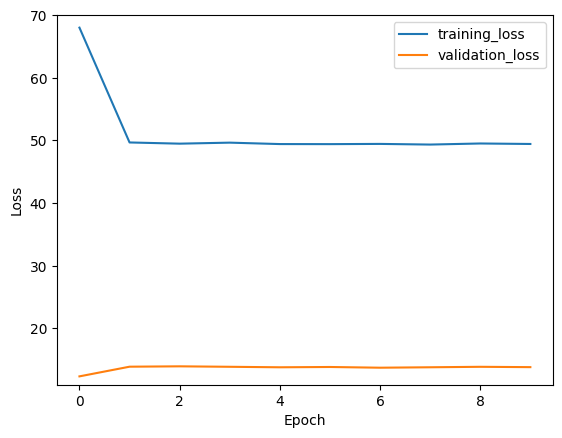

In [30]:

plot_learning_curve_loss(history)


In [32]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([11, 70])
    plt.legend(loc='upper right')


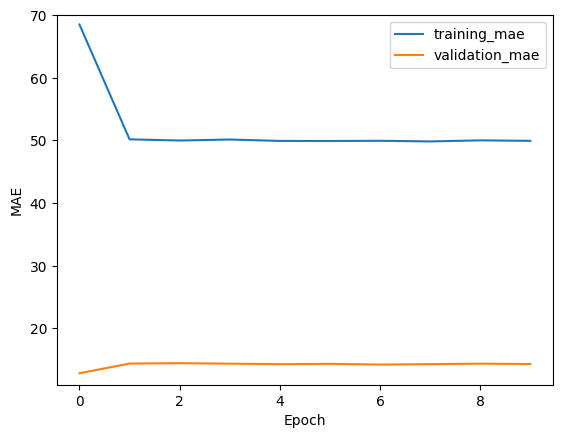

In [33]:

plot_learning_curve_metric(history)



## tf.keras.optimizers.legacy.SGD with its default parameters, no learning_rate, and batch_size = 32. I wanted to see how much impact the batch_size was having on the model's performance 



In [41]:

history


{'loss': [84.56954956054688,
  49.34825897216797,
  49.82574462890625,
  49.41764450073242,
  49.64604187011719,
  49.291107177734375,
  49.82321548461914,
  49.387393951416016,
  49.72559356689453,
  49.2353630065918],
 'mae': [85.06907653808594,
  49.84825897216797,
  50.32574462890625,
  49.91764450073242,
  50.14603805541992,
  49.791107177734375,
  50.32321548461914,
  49.887393951416016,
  50.225589752197266,
  49.7353630065918],
 'val_loss': [36.08637619018555,
  62.913185119628906,
  36.110504150390625,
  62.934078216552734,
  36.09235382080078,
  63.245079040527344,
  36.046199798583984,
  63.09184265136719,
  36.088680267333984,
  62.87873840332031],
 'val_mae': [36.58637619018555,
  63.413185119628906,
  36.610504150390625,
  63.434078216552734,
  36.59235382080078,
  63.74507522583008,
  36.546199798583984,
  63.59184265136719,
  36.588680267333984,
  63.37873840332031]}

In [77]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([35, 85])
    plt.legend(loc='upper right')
    plt.show()


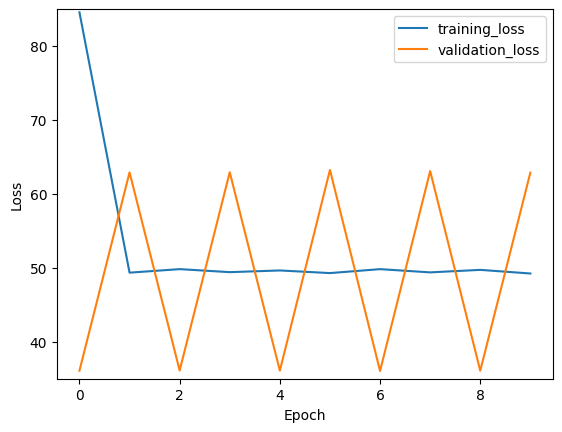

In [45]:

plot_learning_curve_loss(history)



## Observation
From the above plot: a plot looking like jagged teeth (in orange) is usually a batch_size problem.



In [54]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([36, 64])
    plt.legend(loc='upper right')


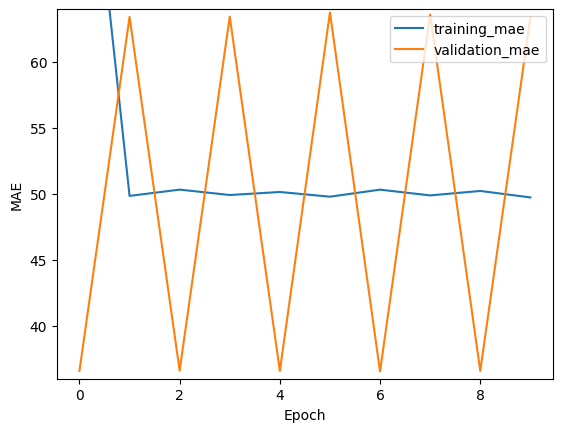

In [55]:

plot_learning_curve_metric(history)



## According to chatGPT

When the validation loss and error look like jagged teeth in the above plot, it could mean any of the following:
1. High Variability in Validation Performance
2. Overfitting
3. Learning Rate Issues
4. Insufficient Regularization
5. Batch Size Too Small

Strategies to Mitigate Jagged Validation Loss:
1. Adjust the Learning Rate
2. Implement Regularization
3. Revise the Model Architecture
4. Use Early Stopping
5. Experiment with Batch Sizes
6. Data Augmentation or Noise Reduction




## Let's add a fixed learning_rate, tf.keras.optimizers.legacy.SGD with its default parameters, and batch_size = 32. Can see the error and loss have been reduced significantly

window_size = 30
batch_size = 32
n_splits = 3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6)



In [75]:

history


{'loss': [47.193634033203125,
  30.18377113342285,
  14.718900680541992,
  5.692269325256348,
  4.530363082885742,
  4.33167839050293,
  4.192255973815918,
  4.052879810333252,
  3.9183707237243652,
  3.785142183303833],
 'mae': [47.693634033203125,
  30.683773040771484,
  15.216066360473633,
  6.174122333526611,
  5.014660358428955,
  4.813155174255371,
  4.673214435577393,
  4.532868385314941,
  4.398063659667969,
  4.263564586639404],
 'val_loss': [41.0764045715332,
  24.43840789794922,
  9.819866180419922,
  5.748332500457764,
  5.0894856452941895,
  4.898823261260986,
  4.701537132263184,
  4.556605339050293,
  4.38800573348999,
  4.260101318359375],
 'val_mae': [41.5764045715332,
  24.93840789794922,
  10.30777645111084,
  6.235311031341553,
  5.5752973556518555,
  5.382549285888672,
  5.185359477996826,
  5.041009902954102,
  4.872949123382568,
  4.743999004364014],
 'lr': [1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06]}

In [60]:
del plot_learning_curve_loss, plot_learning_curve_metric

In [79]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([3, 48])
    plt.legend(loc='upper right')
    plt.show()


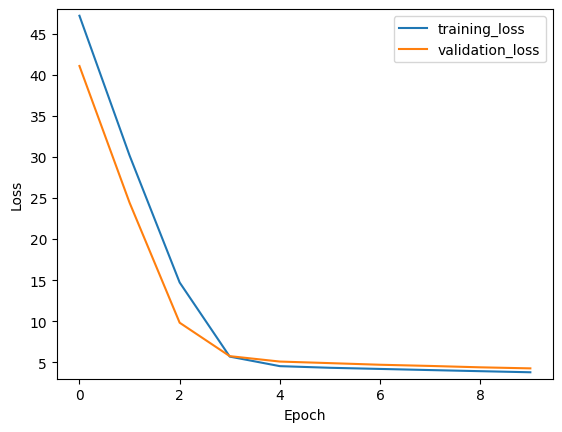

In [80]:

plot_learning_curve_loss(history)


In [81]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([4, 48])
    plt.legend(loc='upper right')


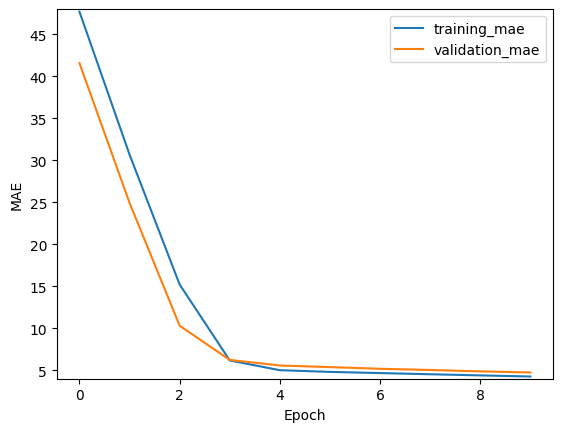

In [82]:

plot_learning_curve_metric(history)


## Some understanding re loss, metric, and optimizer

1. While most optimizers are generally compatible with any differentiable loss function, the choice of optimizer can affect the efficiency of training. For example, adaptive optimizers like Adam or RMSprop might converge faster or require less tuning of the learning rate compared to SGD in many scenarios.

2. Often, the best combination of loss function, metric, and optimizer emerges from empirical experimentation. It's common to start with standard choices (like MSE or MAE for regression problems with SGD or Adam as optimizers) and then iterate based on initial results.

3. Optimizers in machine learning algorithms are methods used to change the attributes of the neural network, such as weights and learning rate, to reduce losses. Optimizers aim to minimize (or maximize) a loss function by iteratively updating the model parameters.

4. tf.keras.optimizers.legacy.SGD refers to the Stochastic Gradient Descent optimizer, a legacy version of SGD in TensorFlow. It's one of the most basic optimization algorithms, which updates the model's weights based on the gradient of the loss function with respect to the weights.


In [29]:

del history



## With two LSTM layers with 32 nodes, flat learning_rate at 1e-6
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

window_size = 30
batch_size = 32
n_splits = 3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6)


In [92]:

history


{'loss': [11.851266860961914,
  4.89475679397583,
  4.320170879364014,
  4.016327381134033,
  3.789275646209717,
  3.603151798248291,
  3.4518349170684814,
  3.3315937519073486,
  3.244432210922241,
  3.185979127883911],
 'mae': [12.337005615234375,
  5.372844219207764,
  4.795699596405029,
  4.488778591156006,
  4.261325836181641,
  4.074550628662109,
  3.922631025314331,
  3.8015527725219727,
  3.71317982673645,
  3.655210256576538],
 'val_loss': [5.073254108428955,
  4.094395160675049,
  3.735795497894287,
  3.492490530014038,
  3.2872636318206787,
  3.1315572261810303,
  2.9911065101623535,
  2.8939738273620605,
  2.8334920406341553,
  2.79659366607666],
 'val_mae': [5.550314903259277,
  4.566222667694092,
  4.211165904998779,
  3.9712047576904297,
  3.761308193206787,
  3.600229501724243,
  3.455603837966919,
  3.3598406314849854,
  3.2998740673065186,
  3.263528347015381],
 'lr': [1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06]}

In [93]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([2, 12])
    plt.legend(loc='upper right')
    plt.show()


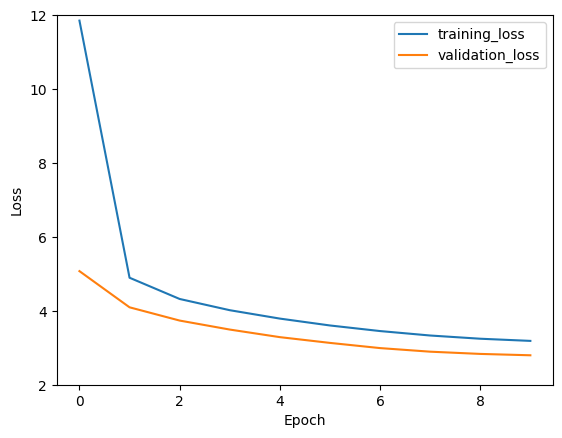

In [94]:

plot_learning_curve_loss(history)


In [95]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([3, 13])
    plt.legend(loc='upper right')



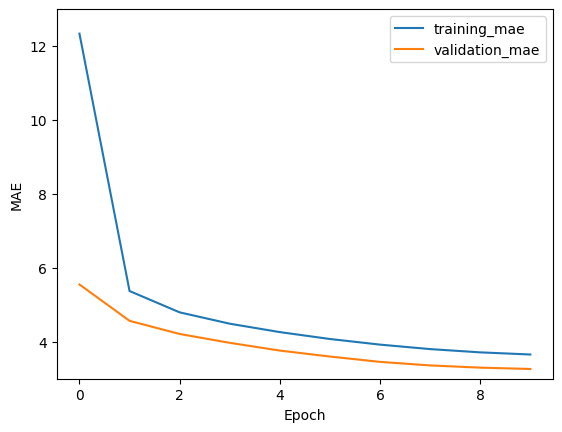

In [96]:

plot_learning_curve_metric(history)



## Changed the learning rate: lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * tf.math.exp(epoch/10)). Can see a huge increment in the model's performance

window_size = 30
batch_size = 32
n_splits = 3


In [104]:

history


{'loss': [2.4394965171813965,
  2.1188721656799316,
  2.0751285552978516,
  2.0345377922058105,
  1.9943151473999023,
  1.9734249114990234,
  1.9522993564605713,
  1.9360618591308594,
  1.9290192127227783,
  1.9190826416015625],
 'mae': [2.8989713191986084,
  2.5735769271850586,
  2.5299432277679443,
  2.489185333251953,
  2.4478912353515625,
  2.4289498329162598,
  2.407334089279175,
  2.391352653503418,
  2.385166645050049,
  2.37394642829895],
 'val_loss': [1.995261311531067,
  1.9285926818847656,
  1.8824766874313354,
  1.856989860534668,
  1.8197320699691772,
  1.8263506889343262,
  1.7790520191192627,
  1.7969200611114502,
  1.7550957202911377,
  1.7492589950561523],
 'val_mae': [2.4539337158203125,
  2.3809590339660645,
  2.331644296646118,
  2.3087568283081055,
  2.2675561904907227,
  2.2761788368225098,
  2.224307060241699,
  2.2483468055725098,
  2.1999752521514893,
  2.1952056884765625],
 'lr': [1e-06,
  1.1051709e-06,
  1.2214026e-06,
  1.3498587e-06,
  1.4918246e-06,
  1.6

In [109]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1.7, 2.5])
    plt.legend(loc='upper right')
    plt.show()


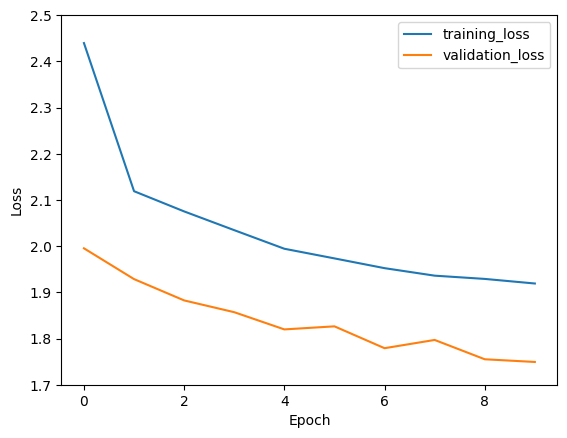

In [110]:

plot_learning_curve_loss(history)


In [114]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2.1, 3])
    plt.legend(loc='upper right')


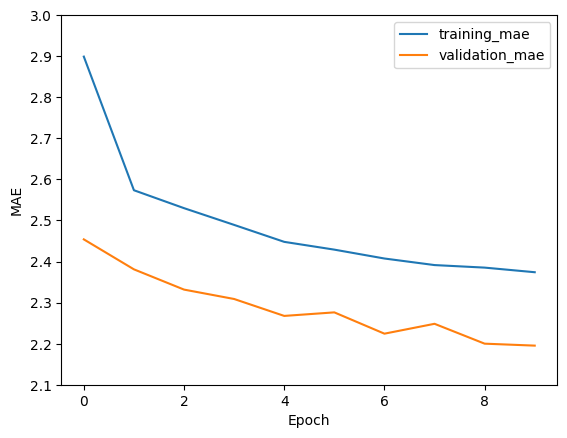

In [115]:

plot_learning_curve_metric(history)


In [125]:

history


{'loss': [12.218561172485352,
  2.769153356552124,
  2.4593846797943115,
  2.2376046180725098,
  2.077014923095703,
  1.9802350997924805,
  1.9214433431625366,
  1.8918821811676025,
  1.872320294380188,
  1.8609039783477783,
  1.8462392091751099,
  1.8449167013168335,
  1.8380173444747925,
  1.82705819606781,
  1.8072240352630615,
  1.804578185081482,
  1.794437289237976,
  1.7834221124649048,
  1.774619460105896,
  1.7769078016281128],
 'mae': [12.706568717956543,
  3.235214948654175,
  2.925264596939087,
  2.7007384300231934,
  2.5360209941864014,
  2.4372448921203613,
  2.377176284790039,
  2.3463857173919678,
  2.3255178928375244,
  2.3159821033477783,
  2.301405191421509,
  2.2982797622680664,
  2.2936155796051025,
  2.2819736003875732,
  2.2585434913635254,
  2.255880832672119,
  2.2467362880706787,
  2.235699415206909,
  2.22514009475708,
  2.228062152862549],
 'val_loss': [2.7927377223968506,
  2.4804203510284424,
  2.163466215133667,
  1.9812849760055542,
  1.871914029121399,


In [130]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1.5, 3])
    plt.legend(loc='upper right')
    plt.show()


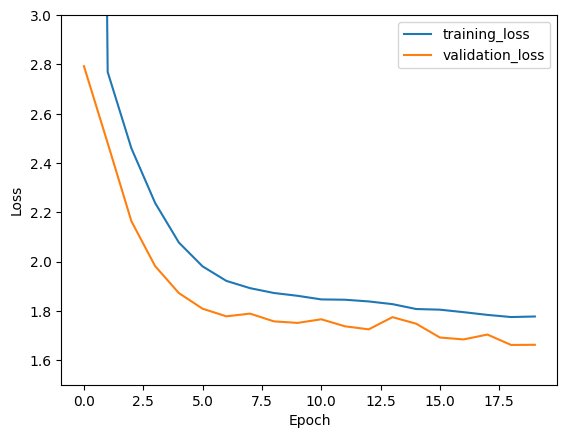

In [131]:
plot_learning_curve_loss(history)

In [138]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 3.5])
    plt.legend(loc='upper right')



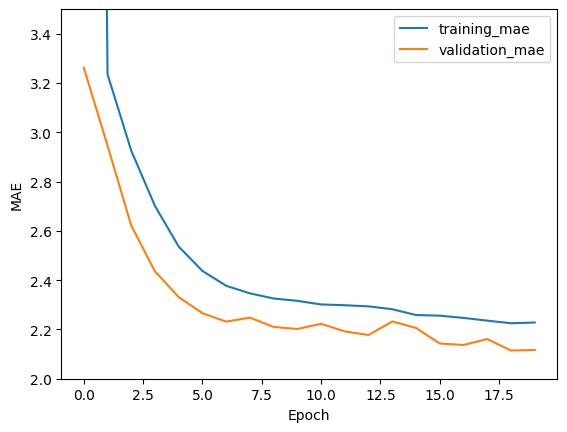

In [139]:
plot_learning_curve_metric(history)

In [143]:
del df
gc.collect()

0

In [144]:
from tensorflow.keras.backend import clear_session
clear_session()


## Having the following architecture and implementing a "stepwise ladder" learning rate schedule 

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD()
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

window_size = 30
batch_size = 32
n_splits = 3


In [24]:

history


{'loss': [3.318804979324341,
  8.912271499633789,
  9.179401397705078,
  7.5499773025512695,
  5.794933795928955,
  4.843013763427734,
  4.816331386566162,
  4.684183120727539,
  4.660390853881836,
  5.0913004875183105,
  5.256092071533203,
  1.8103994131088257,
  1.6848413944244385,
  1.6836804151535034,
  1.6836260557174683,
  1.6836241483688354,
  1.6836241483688354,
  1.6836243867874146,
  1.683624029159546,
  1.6836237907409668],
 'mae': [3.783252000808716,
  9.410057067871094,
  9.678428649902344,
  8.048247337341309,
  6.28759765625,
  5.334707260131836,
  5.308223724365234,
  5.175806045532227,
  5.149785041809082,
  5.584184169769287,
  5.749751567840576,
  2.2620182037353516,
  2.13569712638855,
  2.1345248222351074,
  2.134463310241699,
  2.1344616413116455,
  2.1344616413116455,
  2.1344611644744873,
  2.1344614028930664,
  2.134460926055908],
 'val_loss': [1.882416009902954,
  7.213046073913574,
  7.344733238220215,
  5.879653453826904,
  3.5550496578216553,
  3.8210828304

In [25]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 10])
    plt.legend(loc='upper right')
    plt.show()


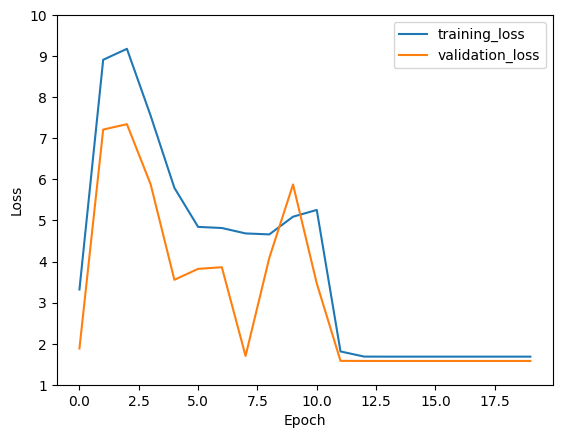

In [26]:

plot_learning_curve_loss(history)


In [27]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 10])
    plt.legend(loc='upper right')


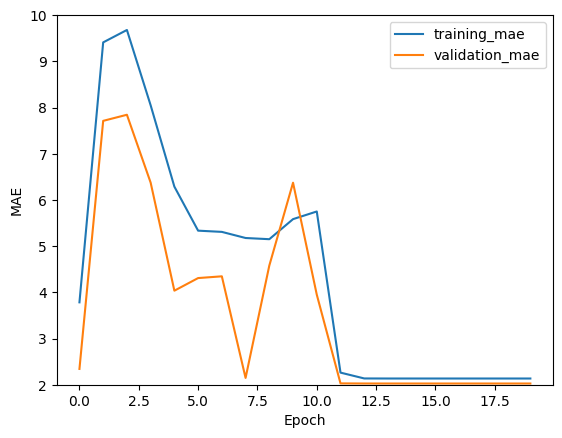

In [28]:

plot_learning_curve_metric(history)



## Observation about stepwise ladder approach for learning rate
It does not look like the stepwise ladder approach worked for this data type. We have experimented with the exponentially decreasing the learning rate and it seems to work so let's stick with that.


In [ ]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * tf.math.exp(epoch/10))


In [35]:

for epoch in range(1, 10):
    print(1e-6 * tf.math.exp(epoch/10))



tf.Tensor(1.1051709e-06, shape=(), dtype=float32)
tf.Tensor(1.2214026e-06, shape=(), dtype=float32)
tf.Tensor(1.3498587e-06, shape=(), dtype=float32)
tf.Tensor(1.4918246e-06, shape=(), dtype=float32)
tf.Tensor(1.6487212e-06, shape=(), dtype=float32)
tf.Tensor(1.8221187e-06, shape=(), dtype=float32)
tf.Tensor(2.0137527e-06, shape=(), dtype=float32)
tf.Tensor(2.2255408e-06, shape=(), dtype=float32)
tf.Tensor(2.459603e-06, shape=(), dtype=float32)


In [41]:



for epoch in range(1, 10):
    print(1e-8 * -10**(epoch / 20))
    


-1.1220184543019634e-08
-1.2589254117941673e-08
-1.4125375446227544e-08
-1.5848931924611136e-08
-1.7782794100389228e-08
-1.9952623149688796e-08
-2.2387211385683395e-08
-2.51188643150958e-08
-2.8183829312644537e-08


In [40]:

for epoch in range(1, 10):
    print(1e-8 * 10**(epoch))


1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0



## using tf.keras.optimizers.schedules.ExponentialDecay
initial_learning_rate = 1e-6
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1,
    decay_rate=0.005,
    staircase=False)# Set to False for smooth decay, True for stepwise decay

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD()
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

window_size = 30
batch_size = 32
n_splits = 3


In [54]:

history


{'loss': [25.56448745727539,
  25.55957794189453,
  25.55958366394043,
  25.559581756591797,
  25.55958366394043,
  25.559579849243164,
  25.55958366394043,
  25.559581756591797,
  25.559581756591797,
  25.55958366394043,
  25.55958366394043,
  25.559589385986328,
  25.55957794189453,
  25.55958366394043,
  25.559585571289062,
  25.559581756591797,
  25.55958366394043,
  25.559574127197266,
  25.559587478637695,
  25.559579849243164],
 'mae': [26.064491271972656,
  26.0595760345459,
  26.059585571289062,
  26.05958366394043,
  26.05958366394043,
  26.059579849243164,
  26.05958366394043,
  26.059579849243164,
  26.059579849243164,
  26.059585571289062,
  26.059585571289062,
  26.059589385986328,
  26.059579849243164,
  26.05958366394043,
  26.059589385986328,
  26.059579849243164,
  26.059585571289062,
  26.059579849243164,
  26.059585571289062,
  26.059579849243164],
 'val_loss': [26.460174560546875,
  26.460174560546875,
  26.460174560546875,
  26.460174560546875,
  26.46017456054687

In [55]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([25, 27])
    plt.legend(loc='upper right')
    plt.show()


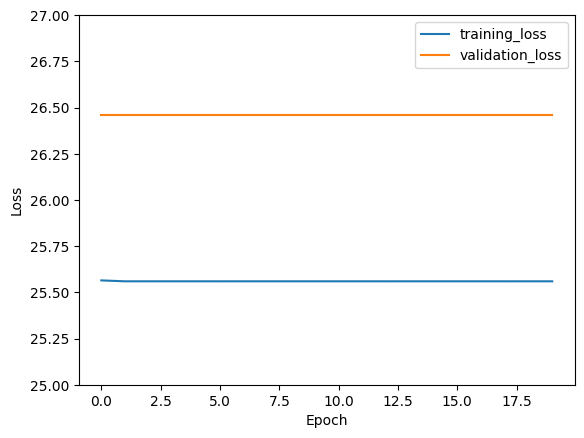

In [56]:

plot_learning_curve_loss(history)


In [58]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([26, 27])
    plt.legend(loc='upper right')


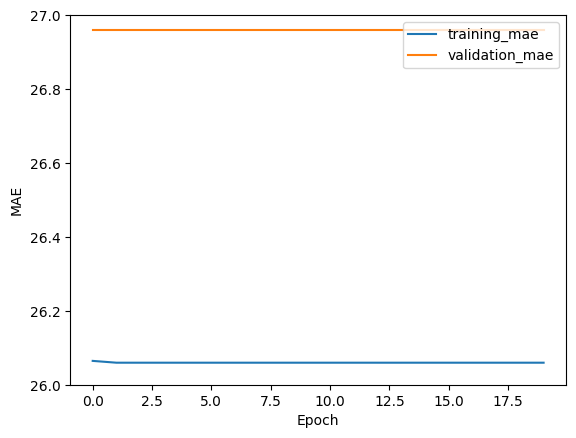

In [59]:

plot_learning_curve_metric(history)



## using tf.keras.optimizers.schedules.ExponentialDecay
initial_learning_rate = 1e-6
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1,
    decay_rate=0.9,
    staircase=False)# Set to False for smooth decay, True for stepwise decay

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD()
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

window_size = 30
batch_size = 32
n_splits = 3



In [66]:

history


{'loss': [3.8299951553344727,
  3.4111664295196533,
  3.4111173152923584,
  3.4111177921295166,
  3.4111180305480957,
  3.4111177921295166,
  3.4111173152923584,
  3.4111173152923584,
  3.411118507385254,
  3.411116600036621,
  3.4111180305480957,
  3.4111180305480957,
  3.4111177921295166,
  3.4111177921295166,
  3.4111173152923584,
  3.4111173152923584,
  3.4111173152923584,
  3.4111173152923584,
  3.4111180305480957,
  3.4111173152923584],
 'mae': [4.3112263679504395,
  3.889801025390625,
  3.88975191116333,
  3.8897526264190674,
  3.889751434326172,
  3.88975191116333,
  3.88975191116333,
  3.8897531032562256,
  3.8897511959075928,
  3.8897526264190674,
  3.88975191116333,
  3.8897511959075928,
  3.889751434326172,
  3.8897511959075928,
  3.88975191116333,
  3.8897523880004883,
  3.8897523880004883,
  3.889751434326172,
  3.8897523880004883,
  3.8897523880004883],
 'val_loss': [3.164767026901245,
  3.16426157951355,
  3.16426157951355,
  3.16426157951355,
  3.16426157951355,
  3.16

In [67]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([3, 4])
    plt.legend(loc='upper right')
    plt.show()


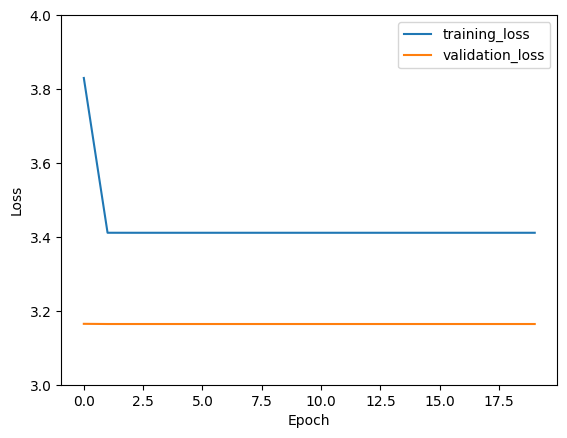

In [68]:

plot_learning_curve_loss(history)


In [69]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([3, 5])
    plt.legend(loc='upper right')



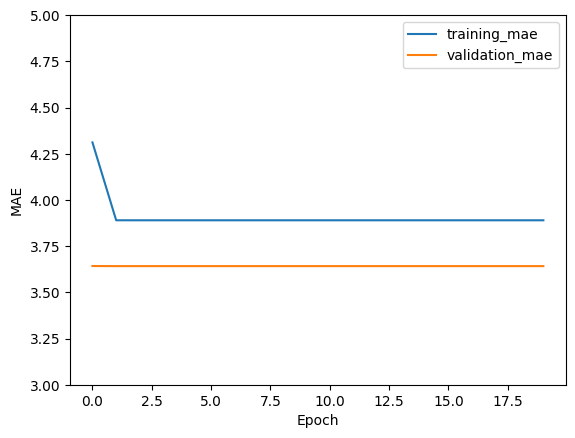

In [70]:

plot_learning_curve_metric(history)



## Changed the initial_learning_rate, decay_steps, and decay_rate in tf.keras.optimizers.schedules.ExponentialDecay

window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.5,
    staircase=False)# Set to False for smooth decay, True for stepwise decay


In [82]:

history


{'loss': [6.103293418884277,
  1.7452141046524048,
  1.745209813117981,
  1.7452101707458496,
  1.74521005153656,
  1.74521005153656,
  1.745209813117981,
  1.74521005153656,
  1.74521005153656,
  1.74521005153656,
  1.7452095746994019,
  1.74521005153656,
  1.7452101707458496,
  1.7452104091644287,
  1.7452095746994019,
  1.74521005153656,
  1.7452104091644287,
  1.745209813117981,
  1.74521005153656,
  1.745209813117981],
 'mae': [6.562547206878662,
  2.1952176094055176,
  2.1952121257781982,
  2.1952126026153564,
  2.1952126026153564,
  2.1952133178710938,
  2.1952126026153564,
  2.1952123641967773,
  2.1952121257781982,
  2.1952130794525146,
  2.1952128410339355,
  2.1952126026153564,
  2.1952128410339355,
  2.1952123641967773,
  2.1952133178710938,
  2.1952130794525146,
  2.1952128410339355,
  2.1952133178710938,
  2.1952126026153564,
  2.1952123641967773],
 'val_loss': [1.6810652017593384,
  1.681042194366455,
  1.681042194366455,
  1.681042194366455,
  1.681042194366455,
  1.681

In [85]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 6])
    plt.legend(loc='upper right')
    plt.show()


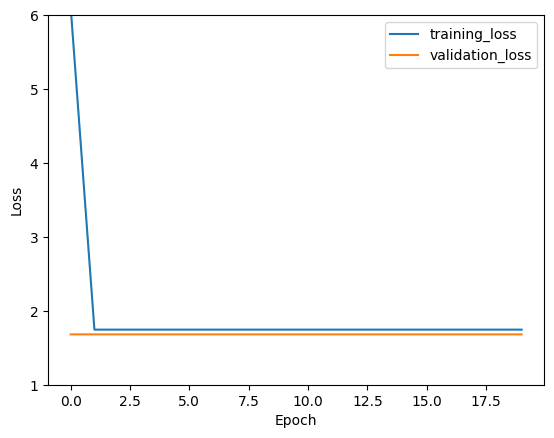

In [86]:
plot_learning_curve_loss(history)


## Changing tf.keras.optimizers.schedules.ExponentialDecay with the following values
window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=50,
    decay_rate=0.85,
    staircase=False)# Set to False for smooth decay, True for stepwise decay
    

In [94]:

history


{'loss': [16.846176147460938,
  4.815208435058594,
  3.0696916580200195,
  2.0744121074676514,
  1.7525838613510132,
  1.7093852758407593,
  1.6796892881393433,
  1.6695770025253296,
  1.6608065366744995,
  1.6502087116241455,
  1.6369417905807495,
  1.6380974054336548,
  1.6366245746612549,
  1.6317051649093628,
  1.627358078956604,
  1.6269694566726685,
  1.6250799894332886,
  1.6238176822662354,
  1.6235851049423218,
  1.62261164188385],
 'mae': [17.34380340576172,
  5.303539752960205,
  3.543550491333008,
  2.532846450805664,
  2.2019593715667725,
  2.1582891941070557,
  2.1279361248016357,
  2.117804765701294,
  2.1078827381134033,
  2.1009788513183594,
  2.0844197273254395,
  2.087547540664673,
  2.0874195098876953,
  2.0792553424835205,
  2.0753612518310547,
  2.075305461883545,
  2.073469400405884,
  2.07192325592041,
  2.07222843170166,
  2.0710220336914062],
 'val_loss': [9.47559642791748,
  3.956477403640747,
  2.9092037677764893,
  1.6364824771881104,
  1.5778659582138062,


In [116]:

del plot_learning_curve_loss, plot_learning_curve_metric
gc.collect()


137528

In [98]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 16])
    plt.legend(loc='upper right')
    plt.show()


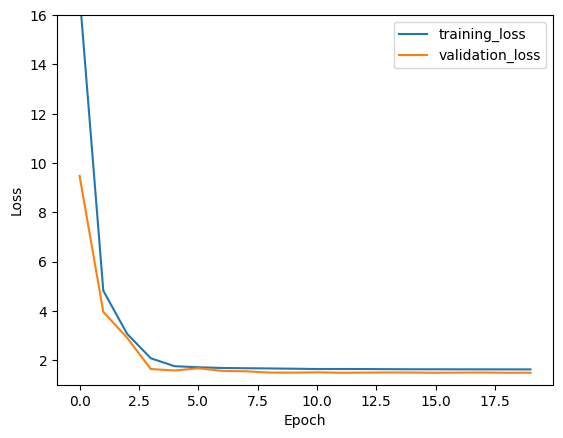

In [100]:

plot_learning_curve_loss(history)


In [101]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 17])
    plt.legend(loc='upper right')


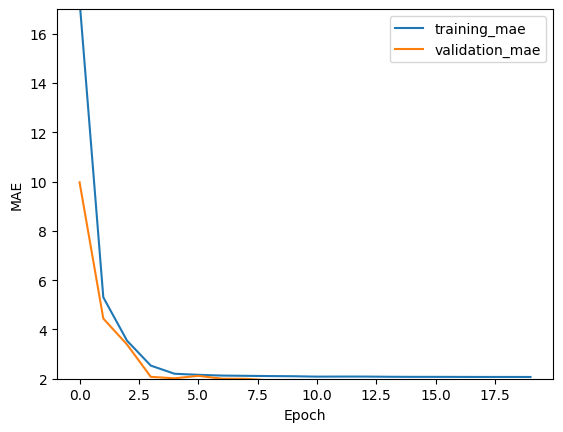

In [102]:

plot_learning_curve_metric(history)



## Tweaking tf.keras.optimizers.schedules.ExponentialDecay
window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay



In [110]:

history


{'loss': [8792.533203125,
  6514.59326171875,
  6120.6591796875,
  5589.9541015625,
  5282.5771484375,
  4794.18603515625,
  4308.81396484375,
  4065.416259765625,
  3713.86474609375,
  3503.045654296875,
  3210.27392578125,
  3026.27685546875,
  2767.27587890625,
  2614.569091796875,
  2376.615234375,
  2234.5712890625,
  2079.662353515625,
  1928.2772216796875,
  1795.1158447265625,
  1663.746337890625],
 'mae': [8793.033203125,
  6515.09326171875,
  6121.1591796875,
  5590.4541015625,
  5283.0771484375,
  4794.68603515625,
  4309.3134765625,
  4065.916259765625,
  3714.36474609375,
  3503.545166015625,
  3210.77392578125,
  3026.77685546875,
  2767.77587890625,
  2615.069091796875,
  2377.114990234375,
  2235.0712890625,
  2080.162353515625,
  1928.7772216796875,
  1795.6158447265625,
  1664.246337890625],
 'val_loss': [1658.0537109375,
  11513.66796875,
  626.5485229492188,
  10651.318359375,
  478.6379699707031,
  8817.4306640625,
  7594.6220703125,
  470.1764221191406,
  7021.743

In [112]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([500, 9000])
    plt.legend(loc='upper right')
    plt.show()


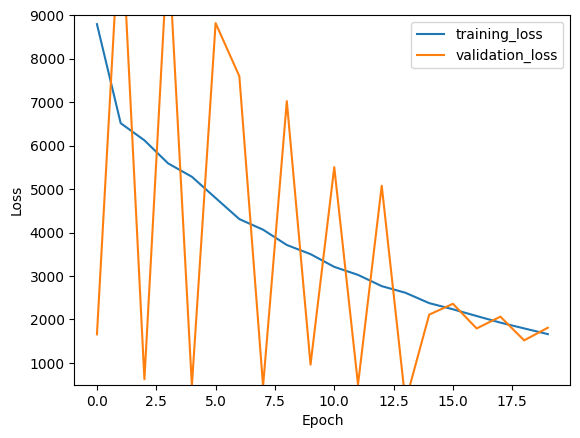

In [113]:

plot_learning_curve_loss(history)


In [114]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([500, 9000])
    plt.legend(loc='upper right')


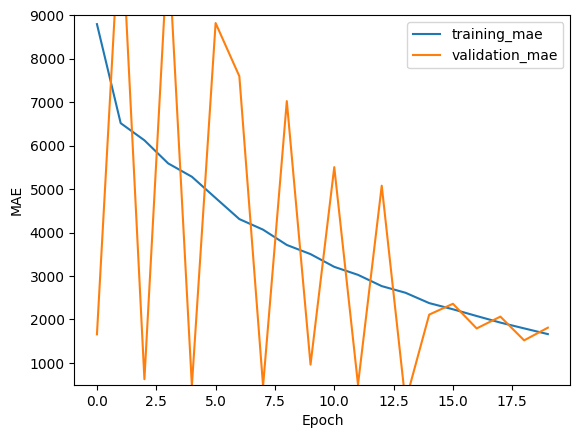

In [115]:

plot_learning_curve_metric(history)



## Tweaking tf.keras.optimizers.schedules.ExponentialDecay with the following setup

window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay


model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [123]:

history


{'loss': [16.482797622680664,
  5.819845199584961,
  4.421970367431641,
  3.708770751953125,
  3.1952505111694336,
  2.9860098361968994,
  2.16084885597229,
  2.1681041717529297,
  2.0634965896606445,
  1.9536126852035522,
  1.8546009063720703,
  1.7670549154281616,
  1.7563852071762085,
  1.7371913194656372,
  1.6960270404815674,
  1.6937029361724854,
  1.6588274240493774,
  1.6589421033859253,
  1.6374629735946655,
  1.6389234066009521],
 'mae': [16.981416702270508,
  6.311757564544678,
  4.9101881980896,
  4.1890645027160645,
  3.67118763923645,
  3.4627134799957275,
  2.6189348697662354,
  2.6242833137512207,
  2.521237373352051,
  2.4122235774993896,
  2.3090617656707764,
  2.215216636657715,
  2.2034995555877686,
  2.1874208450317383,
  2.140587329864502,
  2.1403305530548096,
  2.1063568592071533,
  2.111050844192505,
  2.0841400623321533,
  2.0847132205963135],
 'val_loss': [5.420890808105469,
  5.071177005767822,
  4.33246374130249,
  4.053748607635498,
  2.7685866355895996,
 

In [126]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 8])
    plt.legend(loc='upper right')
    plt.show()


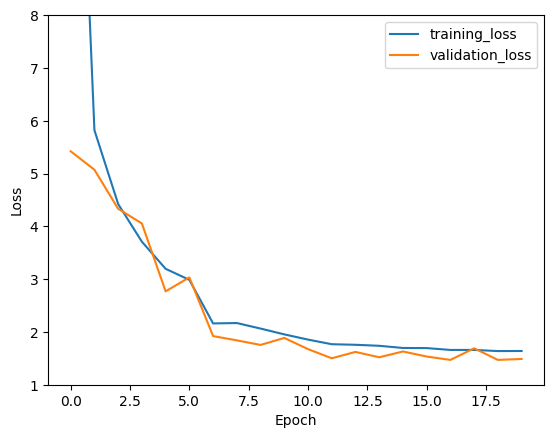

In [127]:

plot_learning_curve_loss(history)


In [128]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([1, 8])
    plt.legend(loc='upper right')



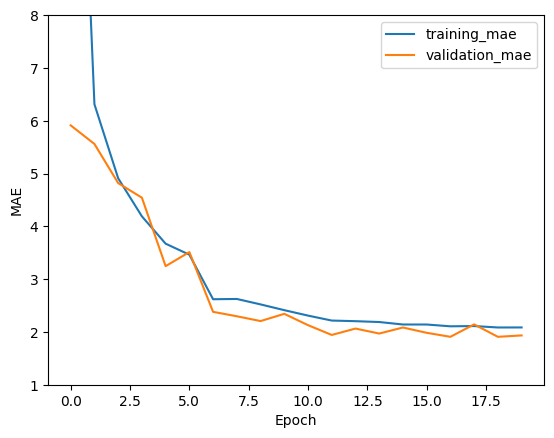

In [129]:

plot_learning_curve_metric(history)



## Tweaking tf.keras.optimizers.schedules.ExponentialDecay with the following setup. Primarily changed the batch_size

window_size = 30
batch_size = 64
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [138]:

history


{'loss': [23.01702308654785,
  8.165606498718262,
  6.016104221343994,
  4.793389797210693,
  4.336103916168213,
  3.9882113933563232,
  3.5043673515319824,
  3.5065622329711914,
  3.175377607345581,
  3.1602752208709717,
  3.0943408012390137,
  2.6352484226226807,
  2.396146297454834,
  2.318390369415283,
  2.1377034187316895,
  1.9835755825042725,
  2.0252790451049805,
  1.8048511743545532,
  1.7883350849151611,
  1.9553848505020142],
 'mae': [23.51613998413086,
  8.661614418029785,
  6.507750511169434,
  5.280047416687012,
  4.818270683288574,
  4.470268249511719,
  3.983030319213867,
  3.984912872314453,
  3.6527786254882812,
  3.6355648040771484,
  3.570345401763916,
  3.102971315383911,
  2.860499620437622,
  2.777548313140869,
  2.6002285480499268,
  2.436765193939209,
  2.4846744537353516,
  2.2552413940429688,
  2.238579034805298,
  2.4105782508850098],
 'val_loss': [10.615336418151855,
  7.235428810119629,
  5.867428302764893,
  6.505778789520264,
  2.597517251968384,
  4.380

In [143]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 12])
    plt.legend(loc='upper right')
    plt.show()



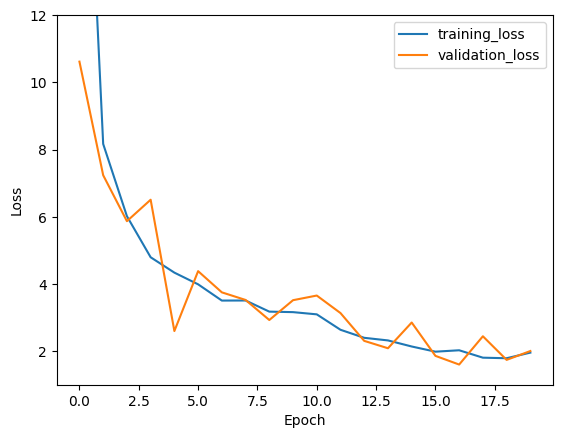

In [144]:

plot_learning_curve_loss(history)


In [145]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 13])
    plt.legend(loc='upper right')



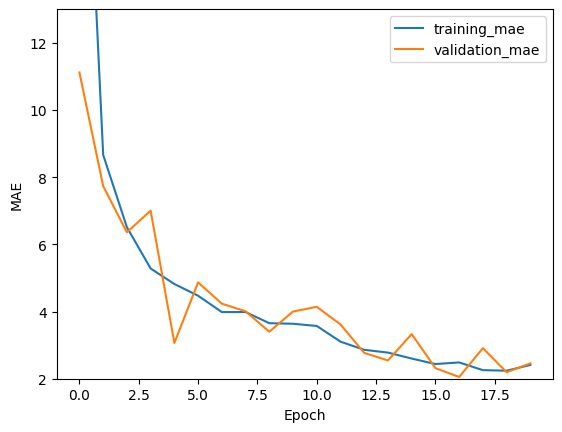

In [146]:

plot_learning_curve_metric(history)



## 
window_size = 30
batch_size = 64
n_splits = 3


initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    

In [154]:

history


{'loss': [19.924827575683594,
  14.014558792114258,
  13.357377052307129,
  12.81462574005127,
  12.348572731018066,
  12.064659118652344,
  11.575407981872559,
  11.030695915222168,
  10.693964958190918,
  10.121660232543945,
  9.720911979675293,
  9.263872146606445,
  8.953605651855469,
  8.609689712524414,
  8.118701934814453,
  7.926565647125244,
  7.544003486633301,
  7.132724761962891,
  6.733911514282227,
  6.361836910247803],
 'mae': [20.42409324645996,
  14.514532089233398,
  13.857352256774902,
  13.314592361450195,
  12.848271369934082,
  12.56459903717041,
  12.075163841247559,
  11.530200004577637,
  11.19332504272461,
  10.621023178100586,
  10.219988822937012,
  9.762490272521973,
  9.45132064819336,
  9.107796669006348,
  8.61546516418457,
  8.424144744873047,
  8.040345191955566,
  7.6285905838012695,
  7.229127883911133,
  6.855590343475342],
 'val_loss': [17.674585342407227,
  16.28860855102539,
  14.12240982055664,
  13.149415969848633,
  13.589859008789062,
  12.93

In [155]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([6, 20])
    plt.legend(loc='upper right')
    plt.show()


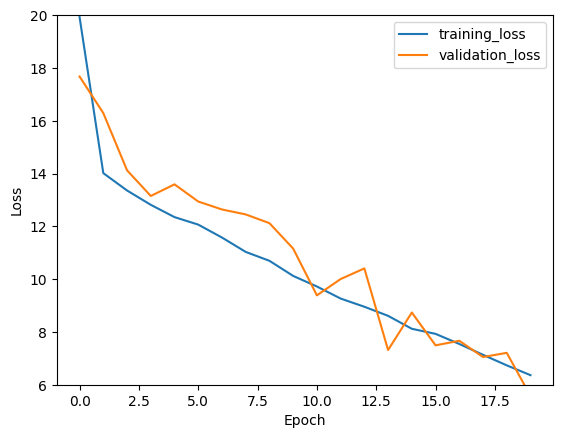

In [156]:

plot_learning_curve_loss(history)


In [157]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([6, 21])
    plt.legend(loc='upper right')


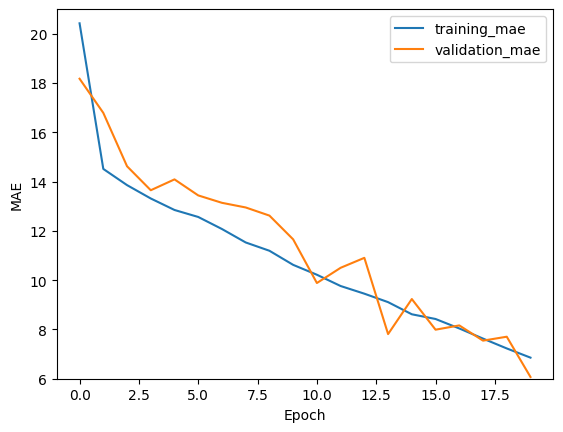

In [158]:

plot_learning_curve_metric(history)



## Following setup

window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])



In [165]:

history


{'loss': [14.835350036621094,
  9.371881484985352,
  8.56116008758545,
  7.188684463500977,
  6.402353286743164,
  5.448160648345947,
  5.83566951751709,
  5.099391937255859,
  4.829748153686523,
  4.837319374084473,
  4.453280448913574,
  3.7923526763916016,
  3.562373161315918,
  2.9674272537231445,
  2.5821144580841064,
  2.3983702659606934,
  2.0621724128723145,
  1.9816370010375977,
  1.9840515851974487,
  1.894814133644104],
 'mae': [15.331710815429688,
  9.864775657653809,
  9.052977561950684,
  7.676916122436523,
  6.886931896209717,
  5.931300163269043,
  6.322147846221924,
  5.5842437744140625,
  5.31458044052124,
  5.325677394866943,
  4.939985752105713,
  4.270964622497559,
  4.042007923126221,
  3.441586494445801,
  3.046704053878784,
  2.8637514114379883,
  2.51796293258667,
  2.43452525138855,
  2.4379448890686035,
  2.3503518104553223],
 'val_loss': [7.520563125610352,
  10.69759464263916,
  11.109670639038086,
  5.686752796173096,
  5.054995536804199,
  5.1085357666015

In [166]:

del plot_learning_curve_loss, plot_learning_curve_metric


In [167]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([1, 15])
    plt.legend(loc='upper right')


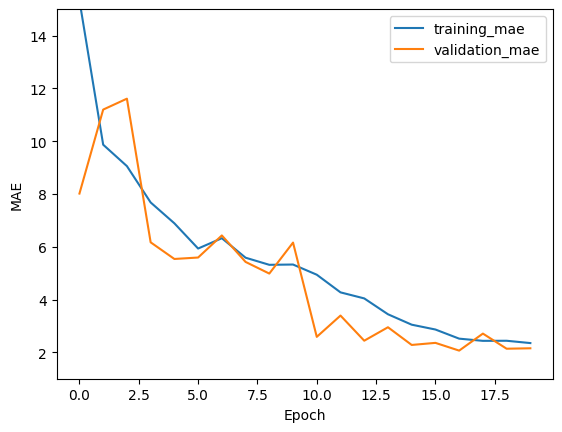

In [168]:

plot_learning_curve_metric(history)


In [169]:

repeated plot_learning_curve_metric twice
def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 16])
    plt.legend(loc='upper right')


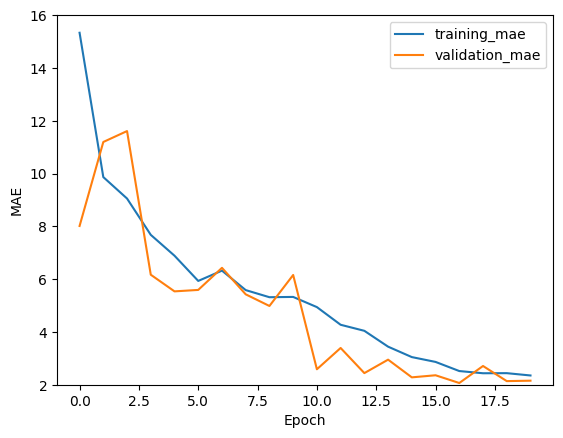

In [170]:

plot_learning_curve_metric(history)



## with the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay




In [177]:

history


{'loss': [20.408231735229492,
  11.027413368225098,
  10.447242736816406,
  9.513200759887695,
  8.80674934387207,
  7.952630519866943,
  7.508314609527588,
  6.787930965423584,
  6.206376552581787,
  5.428271293640137,
  4.967269420623779,
  4.662245273590088,
  3.9216418266296387,
  3.58514666557312,
  3.248204469680786,
  2.716223955154419,
  2.6656174659729004,
  2.2490456104278564,
  2.30721378326416,
  2.234159469604492],
 'mae': [20.906028747558594,
  11.526968955993652,
  10.946864128112793,
  10.011837005615234,
  9.305341720581055,
  8.44982624053955,
  8.005720138549805,
  7.283973693847656,
  6.701895713806152,
  5.918585300445557,
  5.45698356628418,
  5.149880409240723,
  4.4025397300720215,
  4.06325626373291,
  3.7243144512176514,
  3.1843676567077637,
  3.1337990760803223,
  2.708650588989258,
  2.767880439758301,
  2.6920857429504395],
 'val_loss': [8.901129722595215,
  10.324592590332031,
  10.52920913696289,
  10.229209899902344,
  8.608893394470215,
  7.88667154312

In [178]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 21])
    plt.legend(loc='upper right')


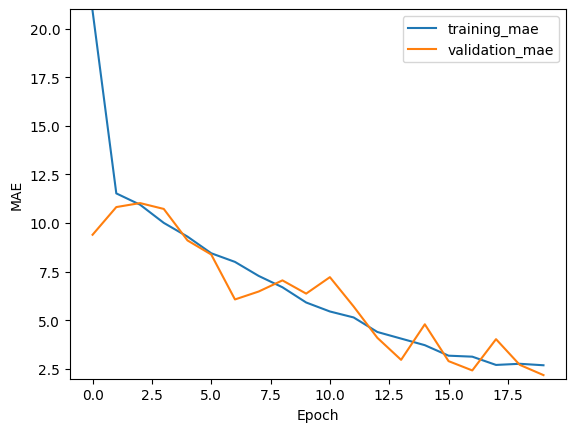

In [179]:
plot_learning_curve_metric(history)

In [180]:

repeated plot_learning_curve_metric twice
def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 21])
    plt.legend(loc='upper right')


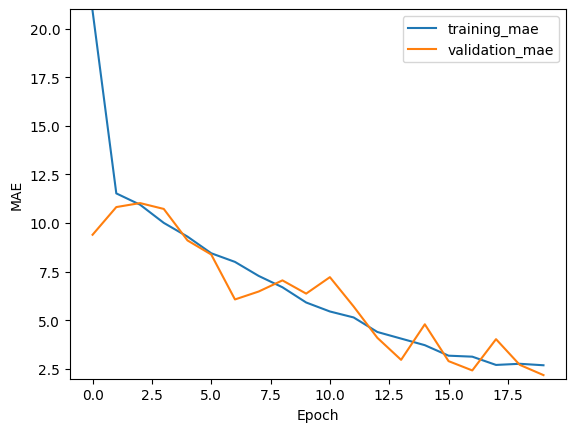

In [181]:
plot_learning_curve_metric(history)


## Tweaking with the following setup

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * tf.math.exp(epoch/10))

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])



In [217]:

history


{'fold_1': {'loss': [38.99846649169922,
   27.46279525756836,
   15.601017951965332,
   5.933012008666992,
   3.969247817993164,
   3.5944440364837646,
   3.2412209510803223,
   2.9541471004486084,
   2.7312798500061035,
   2.5837178230285645,
   2.455566644668579,
   2.3553764820098877,
   2.280100107192993,
   2.2437620162963867,
   2.2024667263031006,
   2.188253402709961,
   2.1711795330047607,
   2.138495683670044,
   2.1005373001098633,
   2.0888776779174805],
  'mae': [39.49846649169922,
   27.96279525756836,
   16.10010528564453,
   6.412848472595215,
   4.445356369018555,
   4.0712666511535645,
   3.714548349380493,
   3.4252939224243164,
   3.2024431228637695,
   3.0488200187683105,
   2.9171533584594727,
   2.8125295639038086,
   2.7387001514434814,
   2.700547218322754,
   2.659728765487671,
   2.6415624618530273,
   2.6269052028656006,
   2.594111442565918,
   2.5575473308563232,
   2.5429093837738037],
  'val_loss': [31.1641845703125,
   19.437355041503906,
   7.888880729

In [234]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 4])
    plt.legend(loc='upper right')
    plt.show()



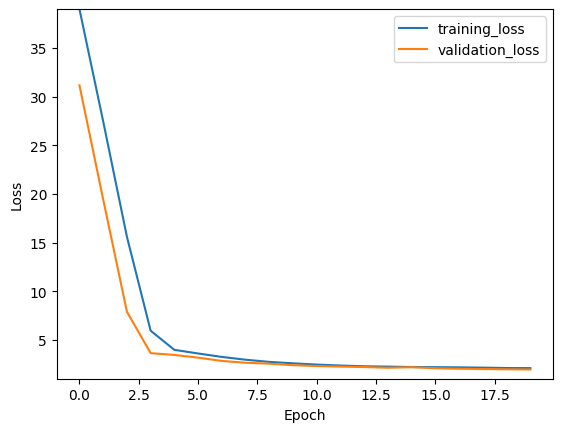

In [226]:

plot_learning_curve_loss(history['fold_1'])


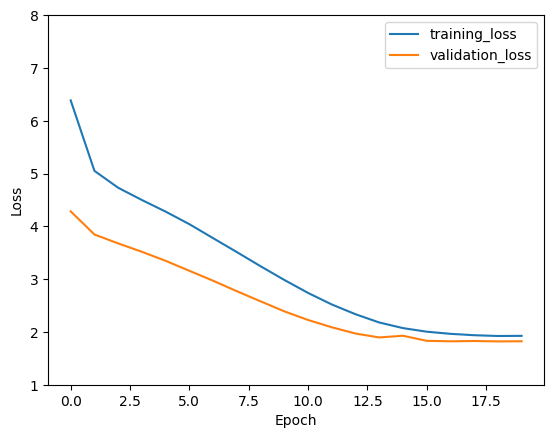

In [231]:

plot_learning_curve_loss(history['fold_2'])


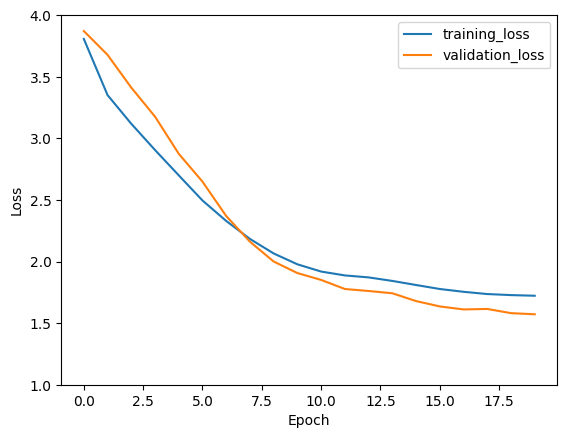

In [235]:

plot_learning_curve_loss(history['fold_3'])



## Tweaking with the following setup

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3* tf.math.exp(epoch/20))
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-6, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [245]:

history


{'fold_1': {'loss': [30.673904418945312,
   8.115432739257812,
   8.61119270324707,
   8.930864334106445,
   11.100785255432129,
   12.360068321228027,
   13.072107315063477,
   13.519549369812012,
   14.271403312683105,
   14.92193603515625,
   16.134977340698242,
   16.648542404174805,
   17.913040161132812,
   18.729568481445312,
   19.930126190185547,
   20.43922996520996,
   21.353857040405273,
   22.764429092407227,
   24.11699867248535,
   25.331581115722656],
  'mae': [31.171772003173828,
   8.603787422180176,
   9.096864700317383,
   9.41929817199707,
   11.590815544128418,
   12.856938362121582,
   13.569724082946777,
   14.019549369812012,
   14.771092414855957,
   15.421540260314941,
   16.634977340698242,
   17.148128509521484,
   18.413042068481445,
   19.229568481445312,
   20.430126190185547,
   20.93886947631836,
   21.853532791137695,
   23.264427185058594,
   24.616989135742188,
   25.831581115722656],
  'val_loss': [19.587154388427734,
   13.611616134643555,
   5.21

In [250]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([14, 46])
    plt.legend(loc='upper right')
    plt.show()



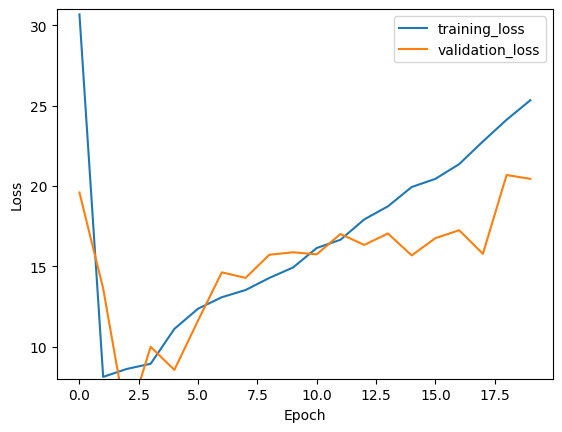

In [247]:
plot_learning_curve_loss(history['fold_1'])

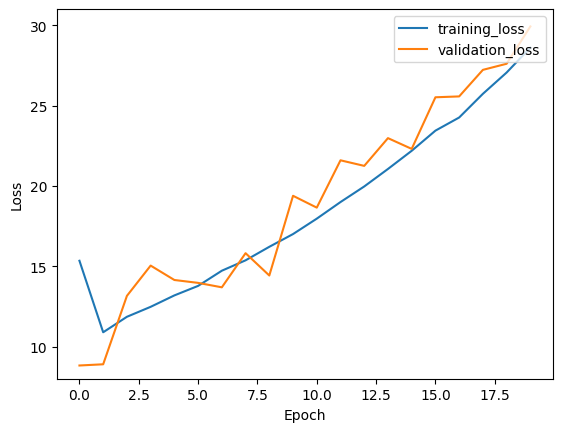

In [248]:

plot_learning_curve_loss(history['fold_2'])


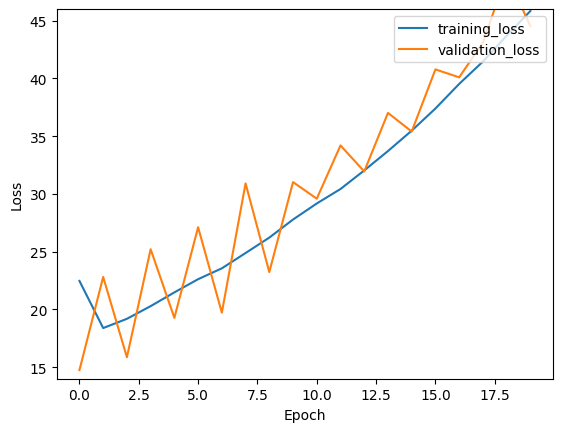

In [251]:

plot_learning_curve_loss(history['fold_3'])



## Tweaking with the following setup

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])



In [262]:

history


{'fold_1': {'loss': [8.939382553100586,
   3.158550977706909,
   2.7313232421875,
   2.673558473587036,
   2.6389734745025635,
   2.6026220321655273,
   2.584420919418335,
   2.5551912784576416,
   2.5351741313934326,
   2.5200302600860596,
   2.5005078315734863,
   2.4872384071350098,
   2.497044801712036,
   2.4549784660339355,
   2.4474785327911377,
   2.426459789276123,
   2.402377128601074,
   2.3769819736480713,
   2.3533530235290527,
   2.31630539894104],
  'mae': [9.431398391723633,
   3.626544237136841,
   3.1901915073394775,
   3.1309428215026855,
   3.098466634750366,
   3.066253185272217,
   3.0438449382781982,
   3.0145022869110107,
   2.9962239265441895,
   2.97556471824646,
   2.9576456546783447,
   2.9482083320617676,
   2.9552016258239746,
   2.912362813949585,
   2.903848886489868,
   2.88303542137146,
   2.855905294418335,
   2.832495927810669,
   2.809725761413574,
   2.7681546211242676],
  'val_loss': [3.2464241981506348,
   2.532975912094116,
   2.5284006595611572

In [270]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 9])
    plt.legend(loc='upper right')
    plt.show()


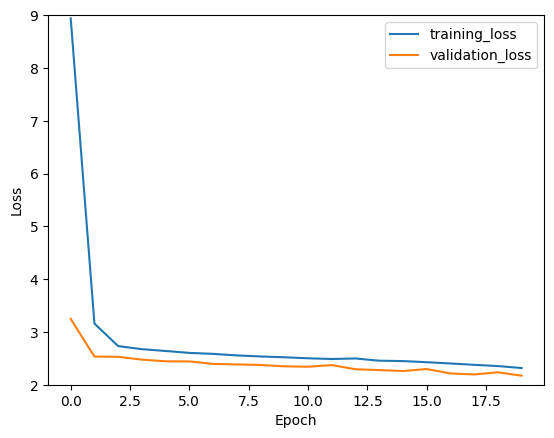

In [264]:

plot_learning_curve_loss(history['fold_1'])


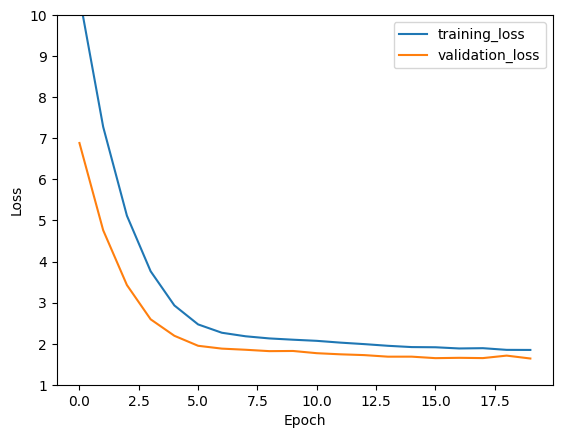

In [267]:

plot_learning_curve_loss(history['fold_2'])


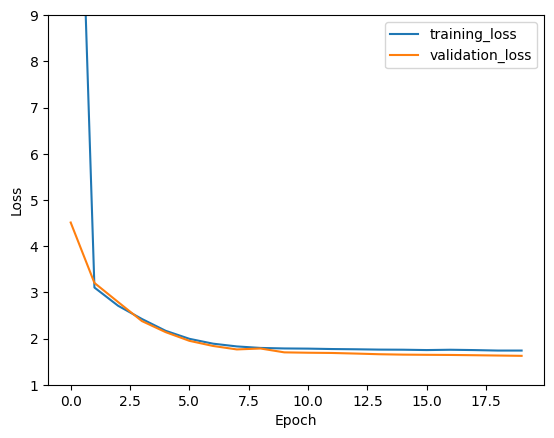

In [271]:

plot_learning_curve_loss(history['fold_3'])


In [272]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 10])
    plt.legend(loc='upper right')


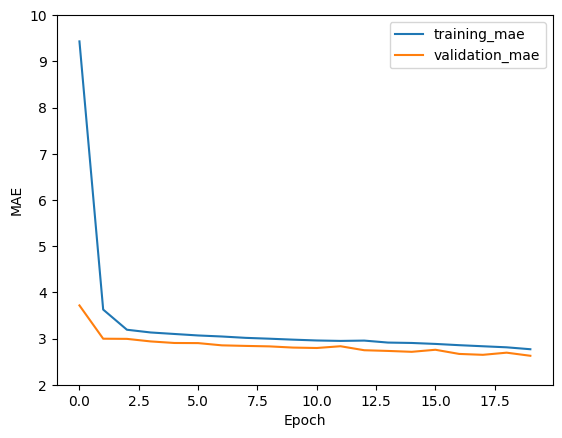

In [273]:
plot_learning_curve_metric(history['fold_1'])

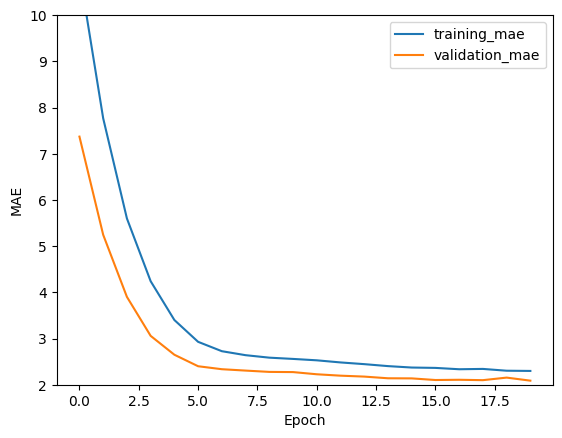

In [274]:

plot_learning_curve_metric(history['fold_2'])


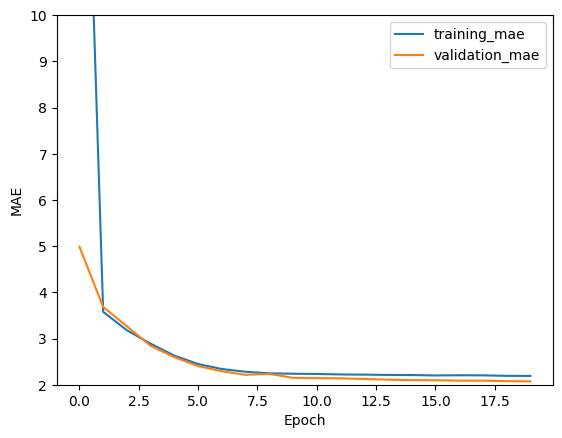

In [275]:

plot_learning_curve_metric(history['fold_3'])


In [277]:

del plot_learning_curve_metric, plot_learning_curve_loss, history


In [280]:

gc.collect()


0

In [281]:

from tensorflow.keras.backend import clear_session
clear_session()



## Tweaked with the following architecture and parameters

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [19]:

history


{'fold_1': {'loss': [11.73261833190918,
   5.324814319610596,
   3.7688491344451904,
   3.1484310626983643,
   2.9032702445983887,
   2.7641470432281494,
   2.7002363204956055,
   2.656843900680542,
   2.6174426078796387,
   2.59024715423584,
   2.6146135330200195,
   2.6001830101013184,
   2.6261775493621826,
   2.6382203102111816,
   2.6192779541015625,
   2.7110981941223145,
   2.5746803283691406,
   2.5220587253570557,
   2.5431149005889893,
   2.5114521980285645],
  'mae': [12.221606254577637,
   5.807707786560059,
   4.241567134857178,
   3.6209874153137207,
   3.3712081909179688,
   3.2297956943511963,
   3.1686222553253174,
   3.124729871749878,
   3.083287000656128,
   3.054915189743042,
   3.0811924934387207,
   3.0651895999908447,
   3.09173846244812,
   3.10512638092041,
   3.0832126140594482,
   3.1775155067443848,
   3.0383613109588623,
   2.9862914085388184,
   3.007105588912964,
   2.974273443222046],
  'val_loss': [6.0853190422058105,
   4.132999420166016,
   3.5170857

In [60]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 4])
    plt.legend(loc='upper right')
    plt.show()



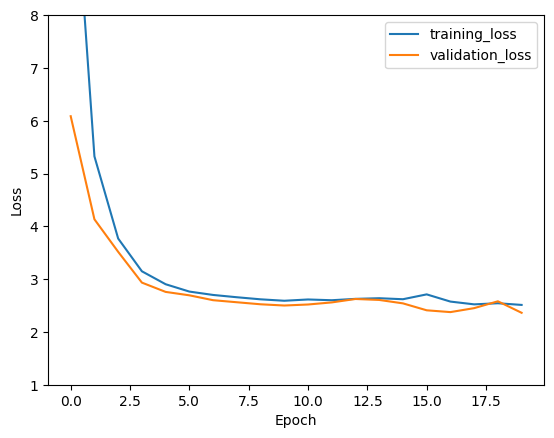

In [33]:

plot_learning_curve_loss(history['fold_1'])


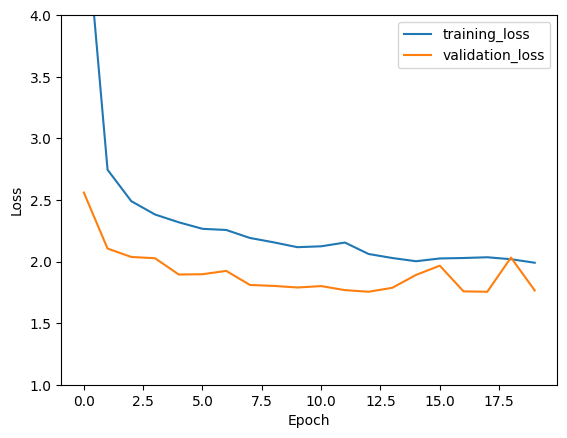

In [27]:

plot_learning_curve_loss(history['fold_2'])


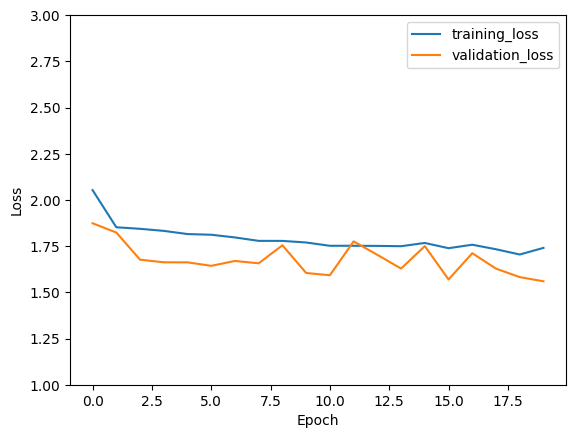

In [35]:

plot_learning_curve_loss(history['fold_3'])


In [70]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([1, 5])
    plt.legend(loc='upper right')



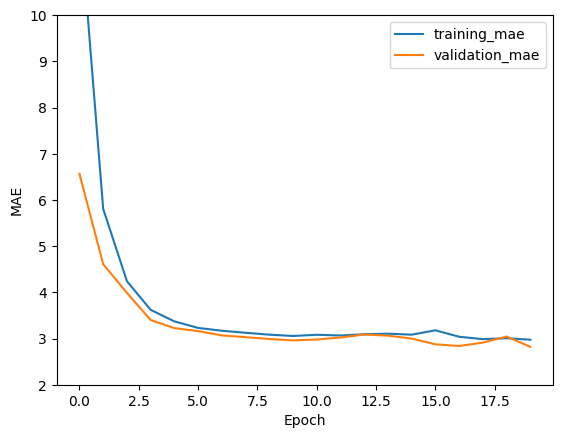

In [37]:

plot_learning_curve_metric(history['fold_1'])


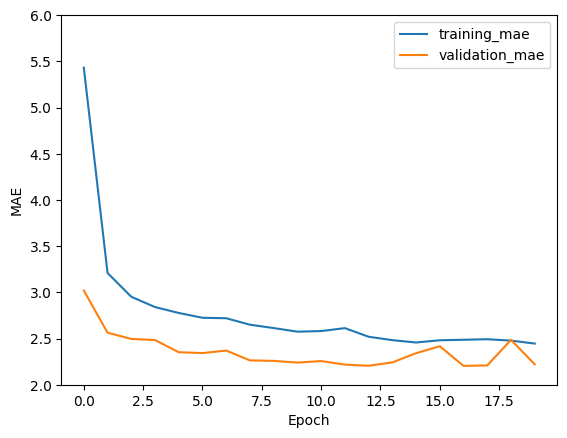

In [40]:

plot_learning_curve_metric(history['fold_2'])


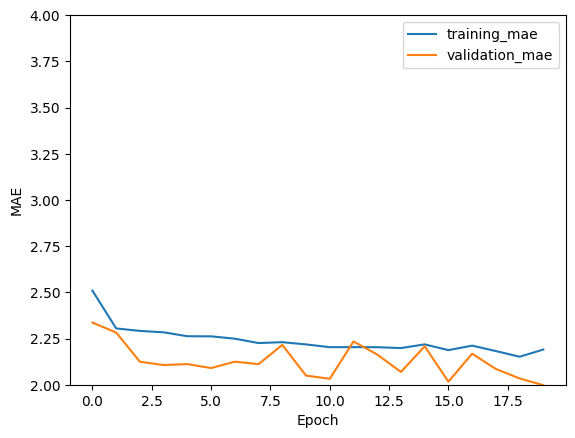

In [43]:

plot_learning_curve_metric(history['fold_3'])


In [83]:

del lot_learning_curve_loss, plot_learning_curve_metric



## Tweaking with the following 

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])


In [51]:

history


{'fold_1': {'loss': [6.317422866821289,
   3.2945783138275146,
   2.3562817573547363,
   2.2606568336486816,
   2.2486824989318848,
   2.216630697250366,
   2.225005865097046,
   2.171234369277954,
   2.160551071166992,
   2.1507108211517334,
   2.1388211250305176,
   2.1417860984802246,
   2.130070924758911,
   2.0982954502105713,
   2.1023108959198,
   2.095885753631592,
   2.1103079319000244,
   2.1178269386291504,
   2.117882013320923,
   2.0872044563293457],
  'mae': [6.8026628494262695,
   3.7655014991760254,
   2.814368963241577,
   2.711932420730591,
   2.707261085510254,
   2.675170421600342,
   2.684204339981079,
   2.628211736679077,
   2.6181137561798096,
   2.608920097351074,
   2.597449541091919,
   2.599331855773926,
   2.5850672721862793,
   2.5563786029815674,
   2.5557010173797607,
   2.553162097930908,
   2.5715298652648926,
   2.572840452194214,
   2.565380573272705,
   2.543301582336426],
  'val_loss': [4.499082565307617,
   2.4967734813690186,
   2.245692968368530

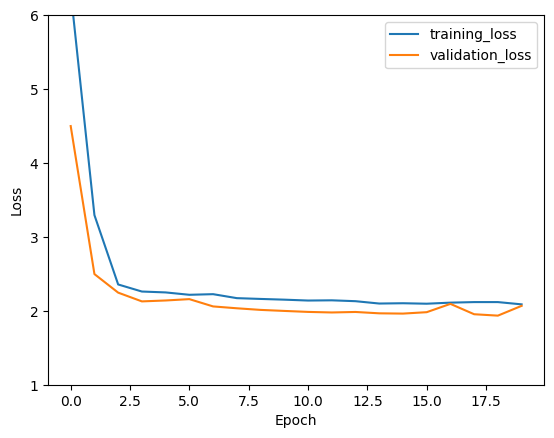

In [57]:

plot_learning_curve_loss(history['fold_1'])


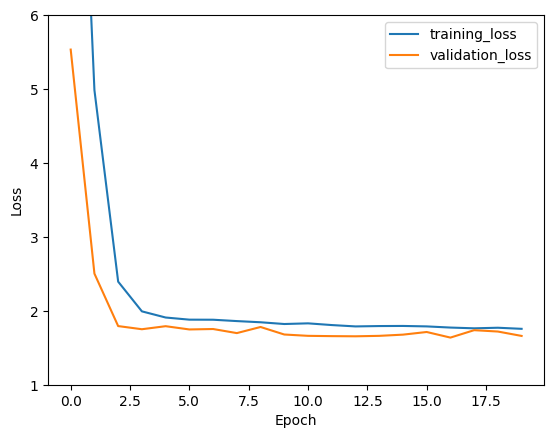

In [58]:

plot_learning_curve_loss(history['fold_2'])


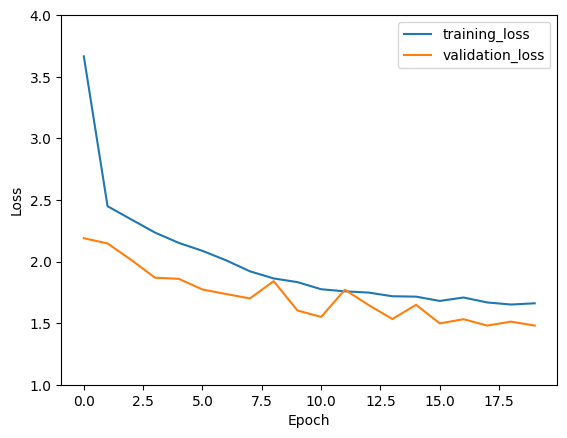

In [61]:

plot_learning_curve_loss(history['fold_3'])


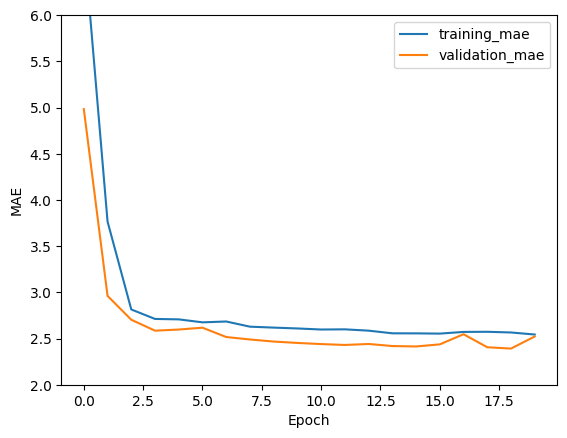

In [65]:

plot_learning_curve_metric(history['fold_1'])


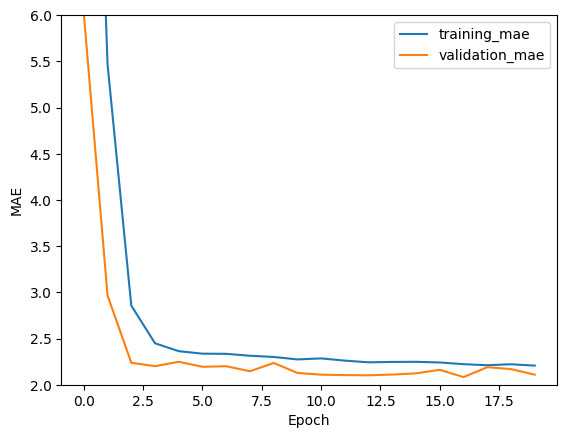

In [66]:

plot_learning_curve_metric(history['fold_2'])


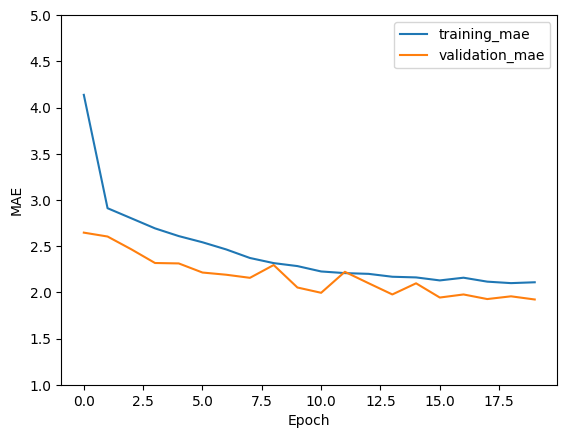

In [71]:

plot_learning_curve_metric(history['fold_3'])



## Tweaking with the following

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

              


In [82]:

history


{'fold_1': {'loss': [25.416257858276367,
   9.041461944580078,
   4.0448431968688965,
   2.987352132797241,
   2.7166671752929688,
   2.602145195007324,
   2.5512144565582275,
   2.401653528213501,
   2.3493597507476807,
   2.248145818710327,
   2.238116979598999,
   2.214383840560913,
   2.1268117427825928,
   2.119978427886963,
   2.0802440643310547,
   2.066423177719116,
   2.0857930183410645,
   2.0684561729431152,
   2.093250036239624,
   1.99549400806427],
  'mae': [25.913143157958984,
   9.53014850616455,
   4.522297382354736,
   3.4537999629974365,
   3.1804308891296387,
   3.056528091430664,
   3.0075225830078125,
   2.8613436222076416,
   2.8018882274627686,
   2.7053656578063965,
   2.6940689086914062,
   2.6728110313415527,
   2.580005168914795,
   2.570904016494751,
   2.5325231552124023,
   2.5162816047668457,
   2.5456762313842773,
   2.5263619422912598,
   2.5504872798919678,
   2.4481420516967773],
  'val_loss': [12.075448989868164,
   5.047206878662109,
   2.923322677

In [88]:
history = {'fold_1': {'loss': [25.416257858276367,
   9.041461944580078,
   4.0448431968688965,
   2.987352132797241,
   2.7166671752929688,
   2.602145195007324,
   2.5512144565582275,
   2.401653528213501,
   2.3493597507476807,
   2.248145818710327,
   2.238116979598999,
   2.214383840560913,
   2.1268117427825928,
   2.119978427886963,
   2.0802440643310547,
   2.066423177719116,
   2.0857930183410645,
   2.0684561729431152,
   2.093250036239624,
   1.99549400806427],
  'mae': [25.913143157958984,
   9.53014850616455,
   4.522297382354736,
   3.4537999629974365,
   3.1804308891296387,
   3.056528091430664,
   3.0075225830078125,
   2.8613436222076416,
   2.8018882274627686,
   2.7053656578063965,
   2.6940689086914062,
   2.6728110313415527,
   2.580005168914795,
   2.570904016494751,
   2.5325231552124023,
   2.5162816047668457,
   2.5456762313842773,
   2.5263619422912598,
   2.5504872798919678,
   2.4481420516967773],
  'val_loss': [12.075448989868164,
   5.047206878662109,
   2.9233226776123047,
   2.4601821899414062,
   2.458099126815796,
   2.3938472270965576,
   2.233433961868286,
   2.2528600692749023,
   2.1496822834014893,
   2.0726447105407715,
   2.1290407180786133,
   2.0074992179870605,
   1.9938561916351318,
   2.014035224914551,
   1.9076300859451294,
   1.9159265756607056,
   2.0876035690307617,
   1.8498458862304688,
   1.8839585781097412,
   1.8448514938354492],
  'val_mae': [12.570053100585938,
   5.516587257385254,
   3.3809454441070557,
   2.919900417327881,
   2.923457145690918,
   2.85843825340271,
   2.692012071609497,
   2.7161192893981934,
   2.6109459400177,
   2.5314583778381348,
   2.586555004119873,
   2.464247226715088,
   2.4489777088165283,
   2.467179775238037,
   2.3622684478759766,
   2.3664588928222656,
   2.5468571186065674,
   2.3003902435302734,
   2.336588144302368,
   2.2976138591766357],
  'lr': [1e-06,
   1.051271e-06,
   1.1051709e-06,
   1.1618341e-06,
   1.2214026e-06,
   1.2840253e-06,
   1.3498587e-06,
   1.4190675e-06,
   1.4918246e-06,
   1.5683122e-06,
   1.6487212e-06,
   1.733253e-06,
   1.8221187e-06,
   1.9155407e-06,
   2.0137527e-06,
   2.117e-06,
   2.2255408e-06,
   2.3396467e-06,
   2.459603e-06,
   2.5857096e-06]},
 'fold_2': {'loss': [2.897430419921875,
   2.3466408252716064,
   2.2119252681732178,
   2.191392421722412,
   2.08594012260437,
   2.0482771396636963,
   2.0073509216308594,
   1.969645619392395,
   2.0113587379455566,
   1.9409559965133667,
   1.880446434020996,
   1.868951439857483,
   1.835555076599121,
   1.8464796543121338,
   1.8761640787124634,
   1.8196117877960205,
   1.7865797281265259,
   1.790478229522705,
   1.912435531616211,
   1.7088401317596436],
  'mae': [3.3640005588531494,
   2.8050003051757812,
   2.6677844524383545,
   2.652116060256958,
   2.5401296615600586,
   2.503197431564331,
   2.4565696716308594,
   2.420442819595337,
   2.4668850898742676,
   2.3962647914886475,
   2.3345887660980225,
   2.3236937522888184,
   2.289325714111328,
   2.299102783203125,
   2.328612804412842,
   2.272564649581909,
   2.2384259700775146,
   2.239777088165283,
   2.36297607421875,
   2.1578235626220703],
  'val_loss': [2.0202314853668213,
   1.9250047206878662,
   1.879428744316101,
   1.82194983959198,
   1.7957267761230469,
   1.7863795757293701,
   1.7141387462615967,
   1.7577462196350098,
   1.9226996898651123,
   1.683137059211731,
   1.6332889795303345,
   1.7198622226715088,
   1.6415073871612549,
   1.5979148149490356,
   1.5842667818069458,
   2.07612943649292,
   1.6540846824645996,
   2.748324394226074,
   1.8240958452224731,
   1.5520371198654175],
  'val_mae': [2.474838972091675,
   2.375369071960449,
   2.3352699279785156,
   2.267087697982788,
   2.251465320587158,
   2.2286176681518555,
   2.15787672996521,
   2.202719211578369,
   2.3725855350494385,
   2.1260673999786377,
   2.085430860519409,
   2.1643412113189697,
   2.0861237049102783,
   2.0452823638916016,
   2.0322771072387695,
   2.536024332046509,
   2.0953457355499268,
   3.2242794036865234,
   2.276127576828003,
   1.9954807758331299],
  'lr': [1e-06,
   1.051271e-06,
   1.1051709e-06,
   1.1618341e-06,
   1.2214026e-06,
   1.2840253e-06,
   1.3498587e-06,
   1.4190675e-06,
   1.4918246e-06,
   1.5683122e-06,
   1.6487212e-06,
   1.733253e-06,
   1.8221187e-06,
   1.9155407e-06,
   2.0137527e-06,
   2.117e-06,
   2.2255408e-06,
   2.3396467e-06,
   2.459603e-06,
   2.5857096e-06]},
 'fold_3': {'loss': [3.5909078121185303,
   2.4527511596679688,
   2.371119976043701,
   2.259856939315796,
   2.179597854614258,
   2.151172637939453,
   2.1397547721862793,
   2.1085805892944336,
   2.0912160873413086,
   2.1112430095672607,
   2.092803955078125,
   2.081223726272583,
   2.0657713413238525,
   2.051372528076172,
   2.0297114849090576,
   2.009211540222168,
   1.997706651687622,
   1.9955525398254395,
   1.966508150100708,
   1.937400221824646],
  'mae': [4.0619215965271,
   2.910844326019287,
   2.8308064937591553,
   2.7191901206970215,
   2.637131929397583,
   2.6055028438568115,
   2.598057985305786,
   2.562516450881958,
   2.5462534427642822,
   2.5662641525268555,
   2.5490729808807373,
   2.5384175777435303,
   2.523322105407715,
   2.5091278553009033,
   2.4855334758758545,
   2.465423822402954,
   2.452280044555664,
   2.450834274291992,
   2.4192655086517334,
   2.3921079635620117],
  'val_loss': [2.355797052383423,
   2.2883667945861816,
   2.133436918258667,
   1.9241583347320557,
   1.9169682264328003,
   1.8707300424575806,
   1.9208683967590332,
   1.8779971599578857,
   1.9072484970092773,
   1.7770594358444214,
   1.7958422899246216,
   1.8395110368728638,
   1.8465484380722046,
   1.7585192918777466,
   1.7308374643325806,
   1.729726791381836,
   1.789144515991211,
   1.7345631122589111,
   1.7570945024490356,
   1.728722095489502],
  'val_mae': [2.8148109912872314,
   2.7518720626831055,
   2.5884759426116943,
   2.374873399734497,
   2.3648815155029297,
   2.3185925483703613,
   2.3707706928253174,
   2.3288791179656982,
   2.3645129203796387,
   2.230281114578247,
   2.2475569248199463,
   2.292174816131592,
   2.2994377613067627,
   2.209109306335449,
   2.1801576614379883,
   2.1791648864746094,
   2.2384185791015625,
   2.184385061264038,
   2.205780506134033,
   2.1799914836883545],
  'lr': [1e-06,
   1.051271e-06,
   1.1051709e-06,
   1.1618341e-06,
   1.2214026e-06,
   1.2840253e-06,
   1.3498587e-06,
   1.4190675e-06,
   1.4918246e-06,
   1.5683122e-06,
   1.6487212e-06,
   1.733253e-06,
   1.8221187e-06,
   1.9155407e-06,
   2.0137527e-06,
   2.117e-06,
   2.2255408e-06,
   2.3396467e-06,
   2.459603e-06,
   2.5857096e-06]}}



In [119]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 13])
    plt.legend(loc='upper right')
    plt.show()



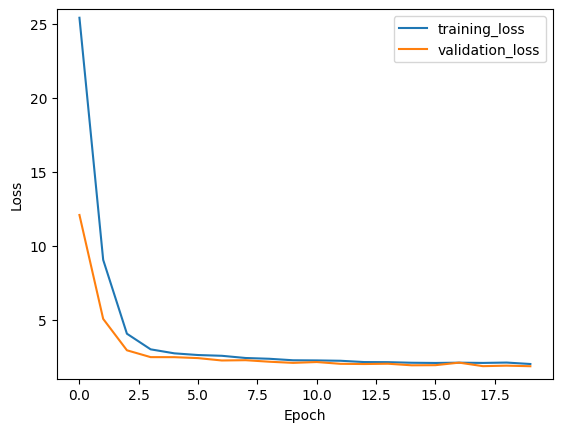

In [92]:
plot_learning_curve_loss(history['fold_1'])

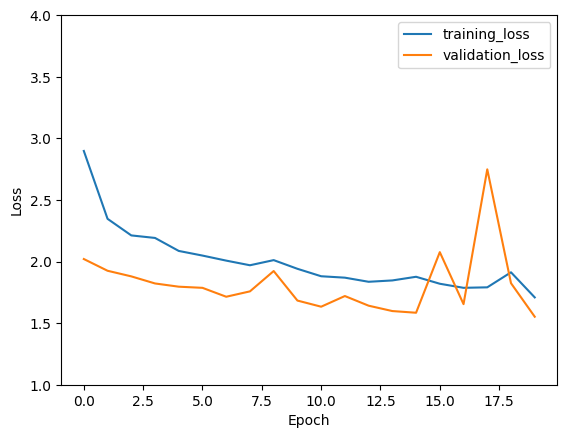

In [96]:

plot_learning_curve_loss(history['fold_2'])


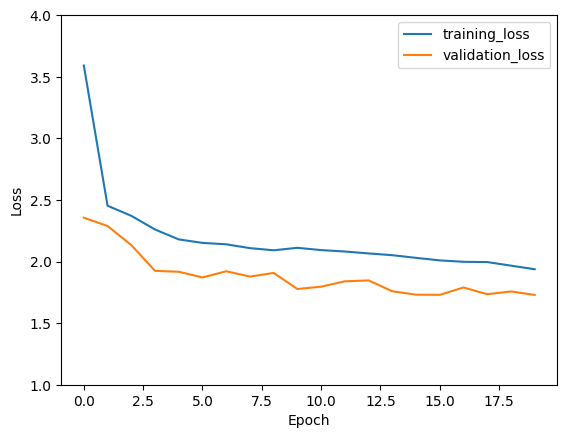

In [97]:

plot_learning_curve_loss(history['fold_3'])



## Tweaking with the following setup

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.5)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [105]:

history


{'fold_1': {'loss': [4.455779552459717,
   4.1110148429870605,
   3.8245849609375,
   3.5408003330230713,
   3.3963069915771484,
   3.324704647064209,
   3.231729745864868,
   3.2225961685180664,
   3.1187703609466553,
   3.077744483947754,
   3.0397467613220215,
   2.9552245140075684,
   2.9142277240753174,
   2.8748669624328613,
   2.8371973037719727,
   2.7551138401031494,
   2.7367026805877686,
   2.6919033527374268,
   2.657447576522827,
   2.5760860443115234],
  'mae': [4.93355655670166,
   4.581584930419922,
   4.30055570602417,
   4.01570463180542,
   3.8703598976135254,
   3.794536590576172,
   3.7025747299194336,
   3.6938576698303223,
   3.589968681335449,
   3.5456745624542236,
   3.511338472366333,
   3.421163320541382,
   3.3822741508483887,
   3.345144510269165,
   3.300020456314087,
   3.2176008224487305,
   3.2041642665863037,
   3.1582329273223877,
   3.1240158081054688,
   3.03922963142395],
  'val_loss': [4.0490007400512695,
   3.6998214721679688,
   3.4012310504913

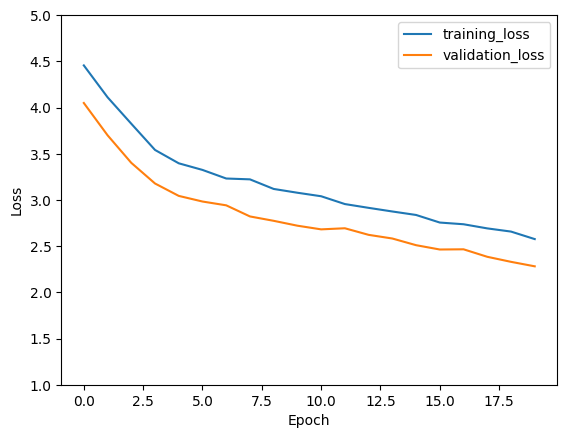

In [107]:

plot_learning_curve_loss(history['fold_1'])


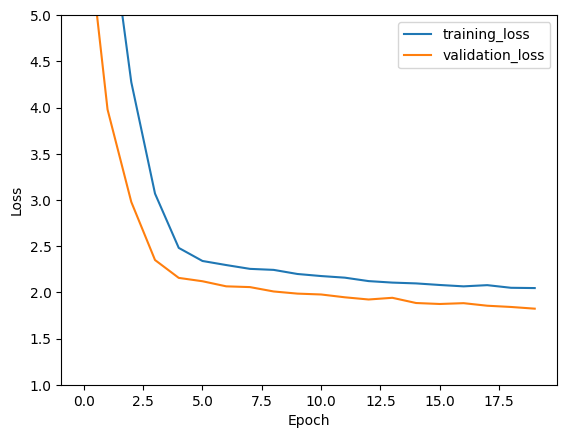

In [108]:

plot_learning_curve_loss(history['fold_2'])


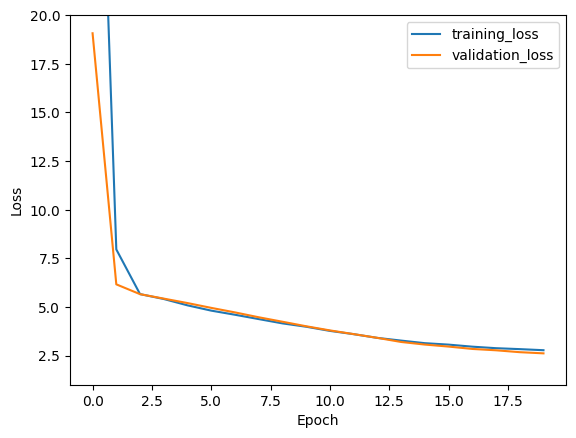

In [111]:

plot_learning_curve_loss(history['fold_3'])




## With the following setup

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))




In [118]:

history


{'fold_1': {'loss': [11.771656036376953,
   9.94093132019043,
   8.980510711669922,
   8.081450462341309,
   7.1782426834106445,
   6.47627592086792,
   5.9088029861450195,
   5.388482093811035,
   5.105228900909424,
   4.889711856842041,
   4.665092468261719,
   4.49584436416626,
   4.299767971038818,
   4.105809211730957,
   3.905902624130249,
   3.7680678367614746,
   3.5977907180786133,
   3.471750020980835,
   3.3939640522003174,
   3.2715814113616943],
  'mae': [12.265029907226562,
   10.433158874511719,
   9.4717435836792,
   8.567168235778809,
   7.666631698608398,
   6.9603657722473145,
   6.3925862312316895,
   5.86897087097168,
   5.579864501953125,
   5.3635993003845215,
   5.139954090118408,
   4.970388889312744,
   4.7707905769348145,
   4.575442314147949,
   4.38191032409668,
   4.240743637084961,
   4.065030097961426,
   3.9406557083129883,
   3.860751152038574,
   3.734302282333374],
  'val_loss': [10.53089427947998,
   9.080869674682617,
   8.059721946716309,
   7.193

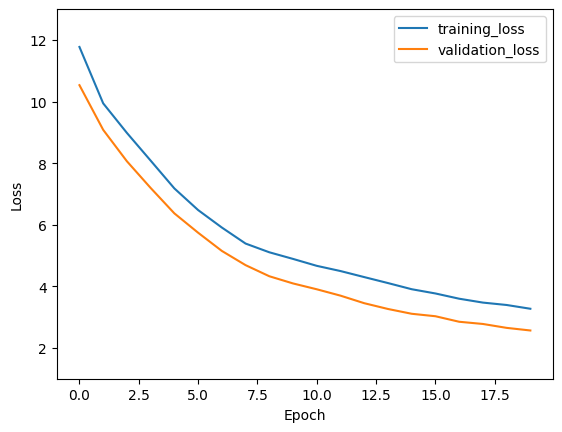

In [120]:

plot_learning_curve_loss(history['fold_1'])


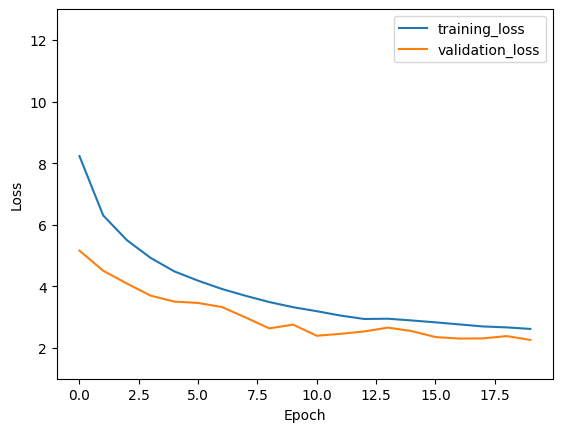

In [121]:

plot_learning_curve_loss(history['fold_2'])


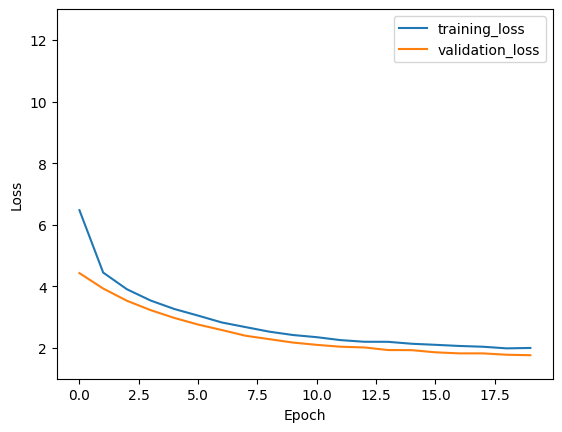

In [122]:

plot_learning_curve_loss(history['fold_3'])


In [131]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([1, 15])
    plt.legend(loc='upper right')


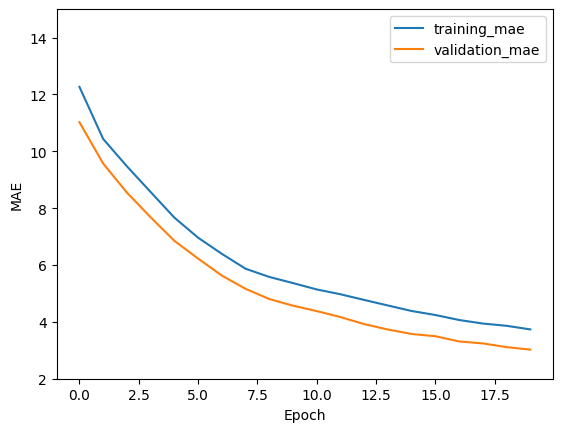

In [128]:

plot_learning_curve_metric(history['fold_1'])


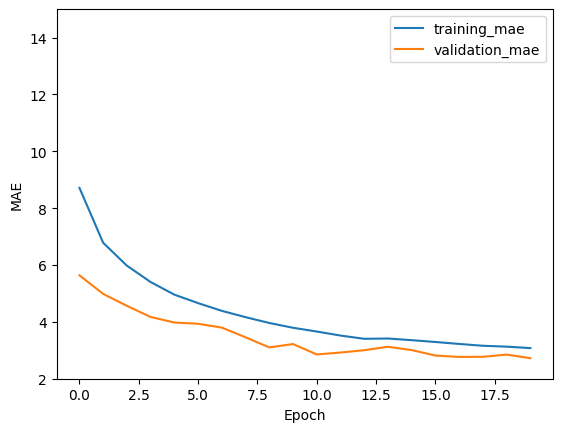

In [129]:

plot_learning_curve_metric(history['fold_2'])


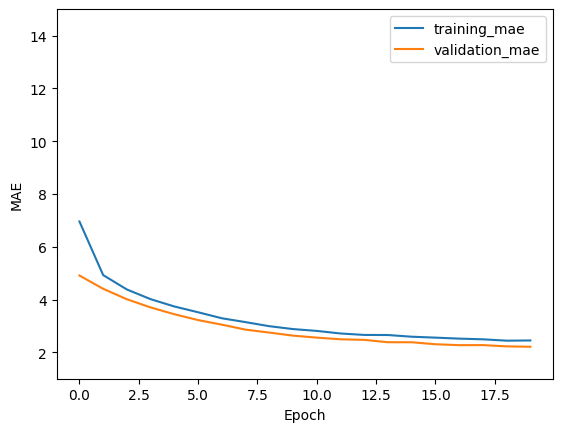

In [132]:

plot_learning_curve_metric(history['fold_3'])


In [139]:
# Average loss across all folds
sum(history['fold_1']['loss'] + history['fold_2']['loss'] + history['fold_3']['loss'])/60


4.0963028033574425

In [140]:
#Average mae across all folds

sum(history['fold_1']['mae'] + history['fold_2']['mae'] + history['fold_3']['mae'])/60


4.566538914044698

In [142]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(5.634843182563782, 3.831791174411774, 2.822274053096771)

In [143]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20



(6.112454402446747, 4.301112687587738, 3.286049652099609)


## Tweaking with the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=30, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [155]:

history


{'fold_1': {'loss': [49.09220504760742,
   40.673526763916016,
   32.15967559814453,
   22.859176635742188,
   13.220171928405762,
   5.058182239532471,
   2.849898099899292,
   2.761789083480835,
   2.696760654449463,
   2.717217206954956,
   2.6971518993377686,
   2.7095141410827637,
   2.658799886703491,
   2.7020063400268555,
   2.6807684898376465,
   2.7020230293273926,
   2.680694103240967,
   2.6639904975891113,
   2.6859166622161865,
   2.611524820327759,
   2.6959495544433594,
   2.6111745834350586,
   2.651726007461548,
   2.627467632293701,
   2.571363687515259,
   2.529553174972534,
   2.594524621963501,
   2.5452842712402344,
   2.4961471557617188,
   2.4951236248016357],
  'mae': [49.59220504760742,
   41.17352294921875,
   32.659671783447266,
   23.359176635742188,
   13.719329833984375,
   5.537817478179932,
   3.313753128051758,
   3.2307353019714355,
   3.1651973724365234,
   3.182539463043213,
   3.1584665775299072,
   3.1763317584991455,
   3.1211462020874023,
   3.

In [182]:


def plot_learning_curve_loss(history, lower_limit, upper_limit):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')
    plt.show()


In [183]:

def plot_learning_curve_metric(history, lower_limit, upper_limit):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')



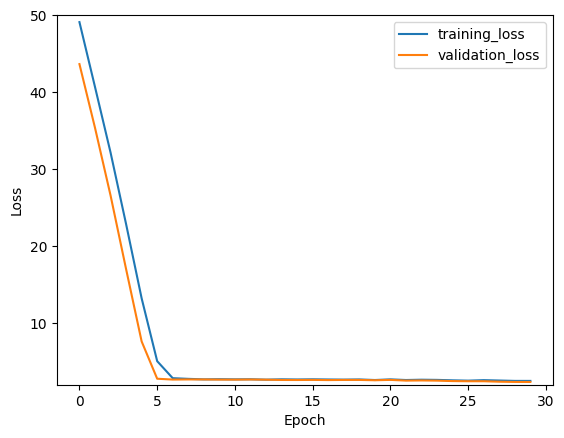

In [159]:

plot_learning_curve_loss(history['fold_1'], 2, 50)



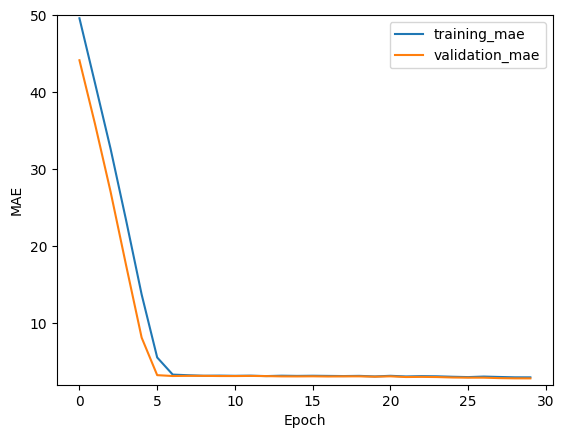

In [166]:

plot_learning_curve_metric(history['fold_1'], 2, 50)


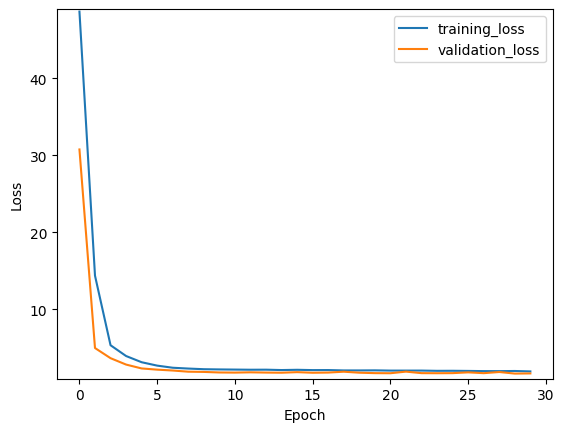

In [161]:

plot_learning_curve_loss(history['fold_2'], 1, 49)


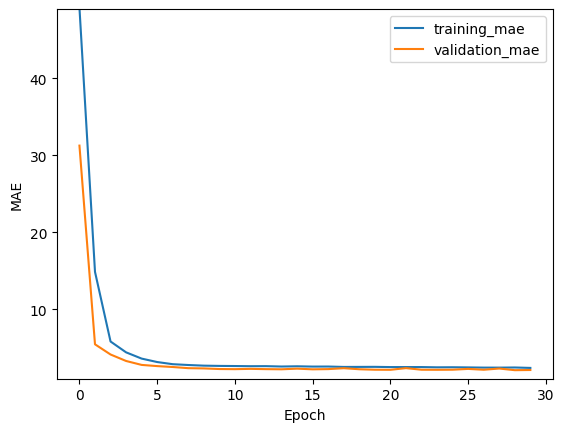

In [167]:

plot_learning_curve_metric(history['fold_2'], 1, 49)


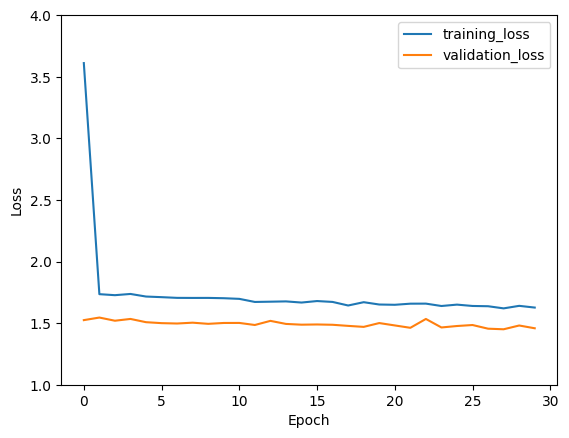

In [164]:


plot_learning_curve_loss(history['fold_3'], 1, 4)


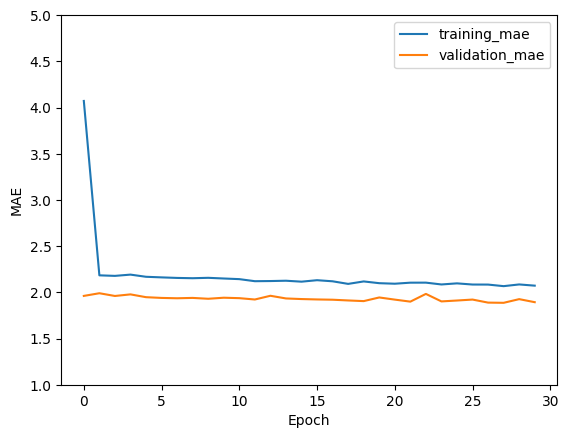

In [169]:

plot_learning_curve_metric(history['fold_3'], 1, 5)


In [170]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20



(12.0403351187706, 7.136154007911682, 3.2815307855606077)

In [171]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(11.334965372085572, 6.442358022928238, 2.608495146036148)

In [179]:

del plot_learning_curve_metric, plot_learning_curve_loss




## Following setup: increased dropout value from 0.02 to 0.25 but the model starts overfitting

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [180]:

history


{'fold_1': {'loss': [16.274940490722656,
   9.597490310668945,
   8.504026412963867,
   8.035247802734375,
   7.79506778717041,
   7.465655326843262,
   7.08162260055542,
   6.880160331726074,
   6.426212310791016,
   6.221770763397217,
   6.175223350524902,
   5.838059902191162,
   5.7061076164245605,
   5.247968673706055,
   5.180542469024658,
   5.283992767333984,
   4.77217435836792,
   4.852731704711914,
   4.558896064758301,
   4.437519550323486],
  'mae': [16.768877029418945,
   10.08565616607666,
   8.993231773376465,
   8.524748802185059,
   8.281379699707031,
   7.952133655548096,
   7.568224906921387,
   7.364863872528076,
   6.911294937133789,
   6.7062458992004395,
   6.661593914031982,
   6.3169732093811035,
   6.19020938873291,
   5.733373641967773,
   5.660328388214111,
   5.763584136962891,
   5.252439498901367,
   5.329178810119629,
   5.033959865570068,
   4.912065505981445],
  'val_loss': [6.3452301025390625,
   10.693252563476562,
   12.622657775878906,
   12.89832

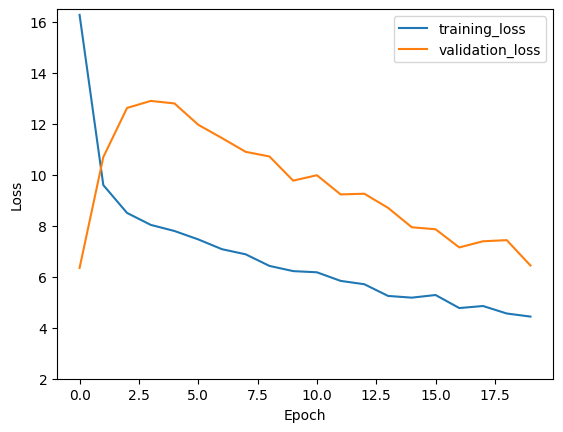

In [184]:

plot_learning_curve_loss(history['fold_1'], 2, 16.5)


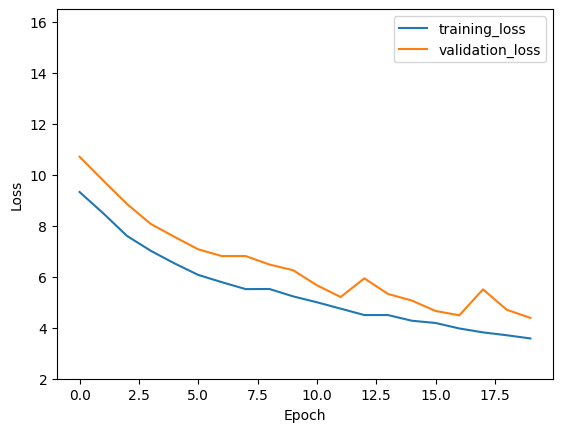

In [185]:


plot_learning_curve_loss(history['fold_2'], 2, 16.5)


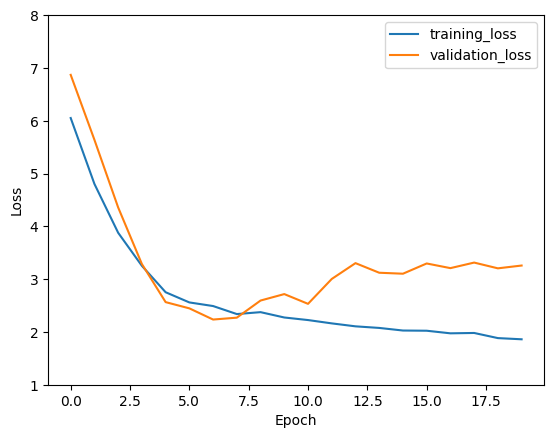

In [187]:

plot_learning_curve_loss(history['fold_3'], 1, 8)



## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      # tf.keras.layers.Dropout(0.002)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [203]:

history


{'fold_1': {'loss': [4.412376880645752,
   3.4971532821655273,
   3.485375165939331,
   3.416188955307007,
   3.4181625843048096,
   3.3767154216766357,
   3.3561484813690186,
   3.3364176750183105,
   3.337684392929077,
   3.3056459426879883,
   3.329685926437378,
   3.2351768016815186,
   3.244194507598877,
   3.231853723526001,
   3.246547222137451,
   3.186873197555542,
   3.1379709243774414,
   3.1583008766174316,
   3.15859317779541,
   3.137556552886963],
  'mae': [4.88840913772583,
   3.9737329483032227,
   3.961099863052368,
   3.8887712955474854,
   3.8902764320373535,
   3.8483033180236816,
   3.8299777507781982,
   3.810650587081909,
   3.8098180294036865,
   3.7733006477355957,
   3.800893545150757,
   3.706751585006714,
   3.713763952255249,
   3.7011477947235107,
   3.716576337814331,
   3.6557843685150146,
   3.6071877479553223,
   3.628610372543335,
   3.626772165298462,
   3.609076976776123],
  'val_loss': [3.267042875289917,
   3.163151502609253,
   3.13604998588562,

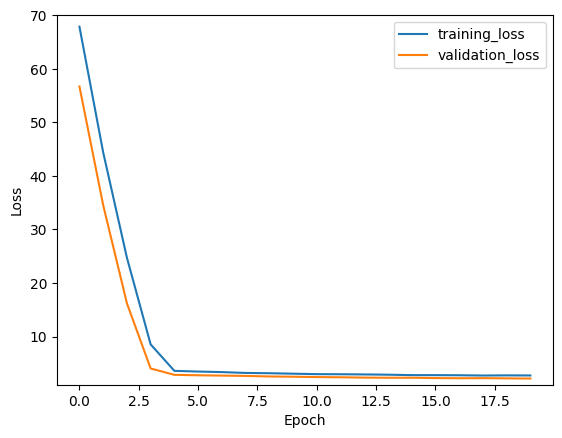

In [208]:

plot_learning_curve_loss(history['fold_2'], 1, 70)


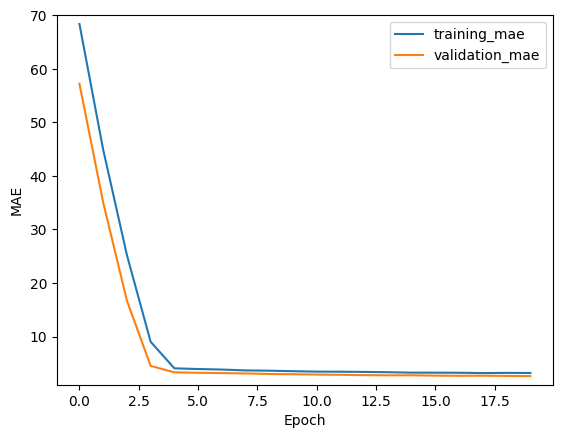

In [209]:

plot_learning_curve_metric(history['fold_2'], 1, 70)


In [210]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(3.8220452427864076, 10.15006206035614, 7.343261277675628)

In [211]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(3.3504310846328735, 9.676514863967896, 6.883755779266357)

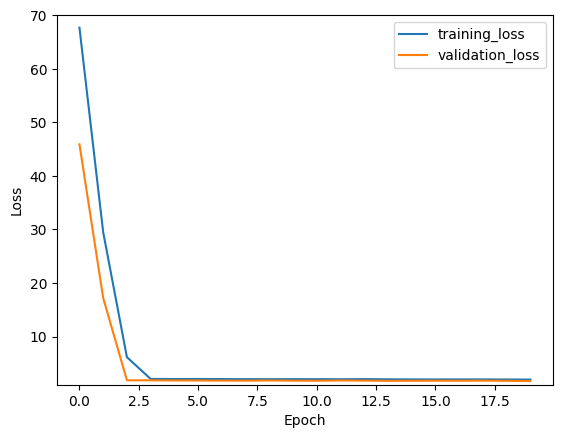

In [218]:


plot_learning_curve_loss(history['fold_3'], 1, 70)



## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      # tf.keras.layers.Dropout(0.002)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)



In [226]:

history


{'fold_1': {'loss': [6.736594200134277,
   3.811154842376709,
   3.4744908809661865,
   3.231653928756714,
   2.953824758529663,
   2.7807846069335938,
   2.587204694747925,
   2.4456663131713867,
   2.330125570297241,
   2.2414803504943848,
   2.218881845474243,
   2.1562297344207764,
   2.0871376991271973,
   2.08988881111145,
   2.0579020977020264,
   2.030646800994873,
   2.029364824295044,
   2.037681818008423,
   2.0252437591552734,
   2.0250778198242188],
  'mae': [7.220027923583984,
   4.285786151885986,
   3.9479641914367676,
   3.704254627227783,
   3.417189836502075,
   3.2429494857788086,
   3.047914981842041,
   2.904843330383301,
   2.7898364067077637,
   2.7015442848205566,
   2.6769423484802246,
   2.6134555339813232,
   2.541393518447876,
   2.542495012283325,
   2.5107357501983643,
   2.482008934020996,
   2.484736919403076,
   2.4911487102508545,
   2.48022198677063,
   2.4773688316345215],
  'val_loss': [3.1898646354675293,
   2.7828752994537354,
   2.60388994216918

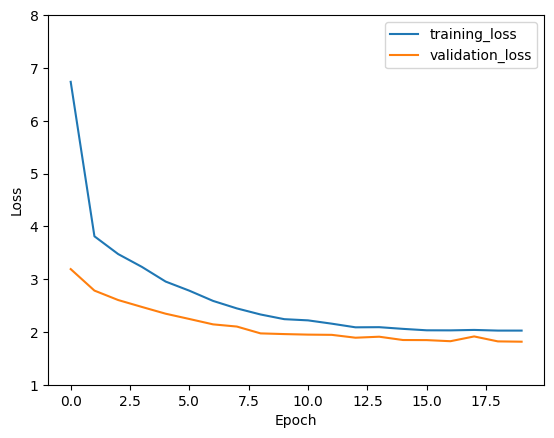

In [229]:

plot_learning_curve_loss(history['fold_1'], 1, 8)


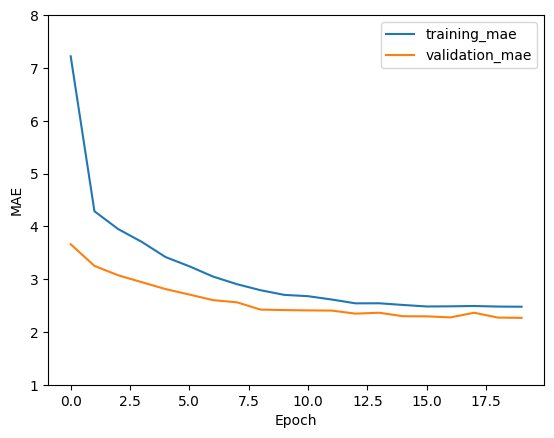

In [230]:

plot_learning_curve_metric(history['fold_1'], 1, 8)


In [231]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(3.128140938282013, 2.475844407081604, 2.9674625039100646)

In [232]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(2.6675517678260805, 2.0213903546333314, 2.5067470610141753)


## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      # tf.keras.layers.Dropout(0.002)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [239]:

history


{'fold_1': {'loss': [14.914091110229492,
   10.365553855895996,
   7.854090213775635,
   6.392238616943359,
   5.647602558135986,
   5.333069324493408,
   5.051391124725342,
   4.788600921630859,
   4.562456130981445,
   4.325007915496826,
   4.090035915374756,
   3.926023006439209,
   3.732177257537842,
   3.588151454925537,
   3.4257493019104004,
   3.370525598526001,
   3.257957696914673,
   3.184750556945801,
   3.106987476348877,
   3.053515911102295],
  'mae': [15.410571098327637,
   10.85854721069336,
   8.345314979553223,
   6.879357814788818,
   6.1319804191589355,
   5.812026023864746,
   5.528701305389404,
   5.267851829528809,
   5.043176174163818,
   4.802400588989258,
   4.568638324737549,
   4.399867534637451,
   4.20820426940918,
   4.062073707580566,
   3.8982479572296143,
   3.844360113143921,
   3.7278239727020264,
   3.6561386585235596,
   3.582484483718872,
   3.525712728500366],
  'val_loss': [10.556787490844727,
   7.541566371917725,
   6.329524517059326,
   5.84

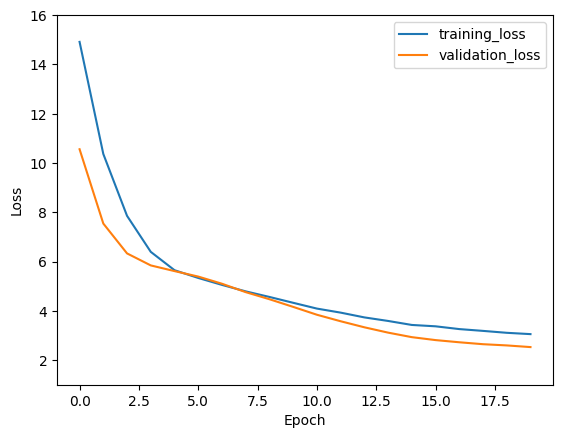

In [241]:

plot_learning_curve_loss(history['fold_1'], 1, 16)


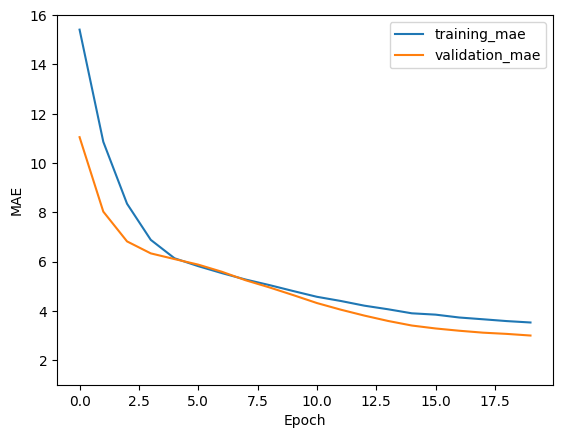

In [242]:

plot_learning_curve_metric(history['fold_1'], 1, 16)


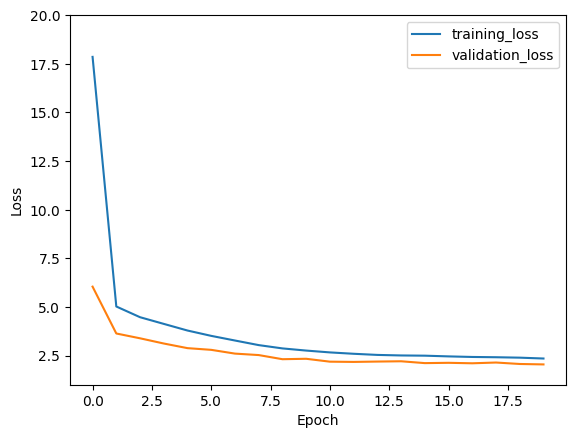

In [247]:

plot_learning_curve_loss(history['fold_2'], 1, 20)


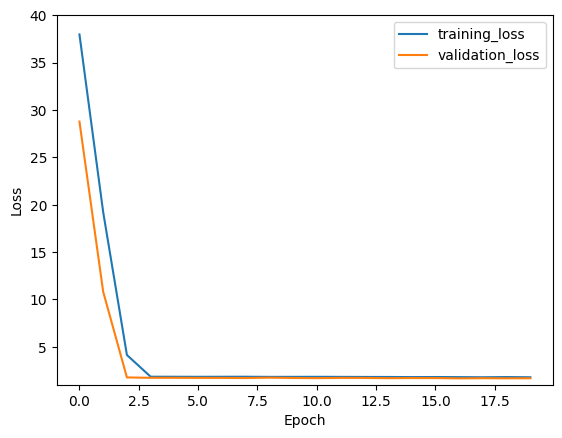

In [252]:

plot_learning_curve_loss(history['fold_3'], 1, 40)


In [243]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(5.677673959732056, 4.246493697166443, 5.073163449764252)

In [244]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(5.198498797416687, 3.775892174243927, 4.613844347000122)


## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      # tf.keras.layers.Dropout(0.002)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [260]:

history


{'fold_1': {'loss': [3.6864867210388184,
   2.7577404975891113,
   2.769304037094116,
   2.7514500617980957,
   2.7785258293151855,
   2.715860605239868,
   2.725478172302246,
   2.6802268028259277,
   2.6937551498413086,
   2.6739654541015625,
   2.6859850883483887,
   2.621248245239258,
   2.620116949081421,
   2.6304636001586914,
   2.5941712856292725,
   2.626136064529419,
   2.61163592338562,
   2.5934834480285645,
   2.584437131881714,
   2.531968832015991],
  'mae': [4.156846523284912,
   3.2263541221618652,
   3.2382760047912598,
   3.223299264907837,
   3.249142646789551,
   3.1841561794281006,
   3.195258378982544,
   3.1444430351257324,
   3.16044020652771,
   3.13850474357605,
   3.151193857192993,
   3.086460590362549,
   3.087588310241699,
   3.10076642036438,
   3.05945086479187,
   3.0906057357788086,
   3.0804443359375,
   3.0609498023986816,
   3.0510976314544678,
   2.999197244644165],
  'val_loss': [2.508183479309082,
   2.394948959350586,
   2.3950860500335693,
   

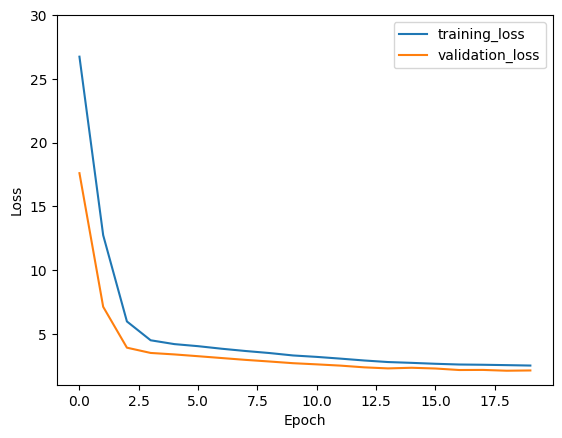

In [263]:

plot_learning_curve_loss(history['fold_2'], 1, 30)


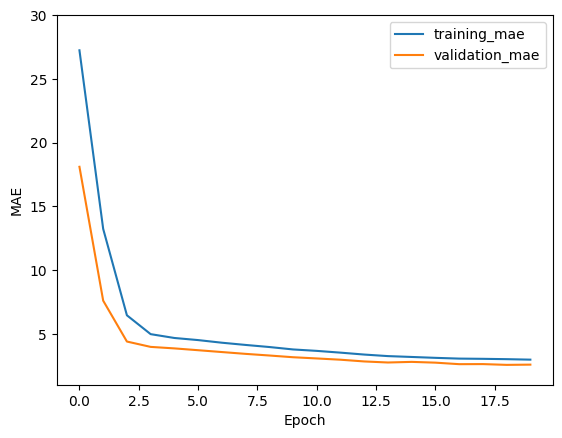

In [264]:

plot_learning_curve_metric(history['fold_2'], 1, 30)


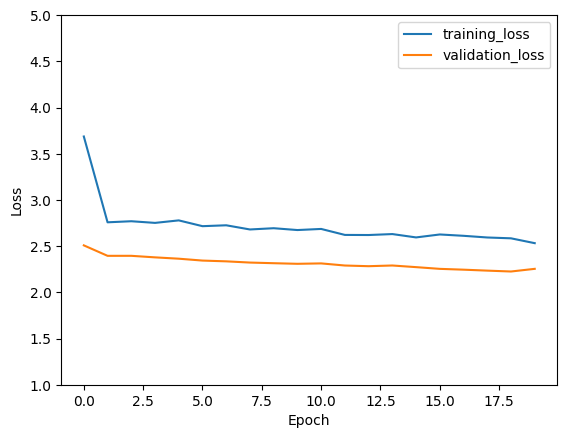

In [267]:

plot_learning_curve_loss(history['fold_1'], 1, 5)


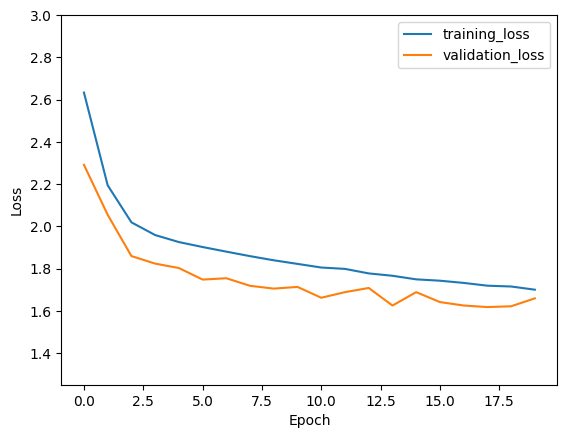

In [270]:

plot_learning_curve_loss(history['fold_3'], 1.25, 3)


In [271]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(3.1842237949371337, 5.46609628200531, 2.330666160583496)

In [272]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(2.716621994972229, 4.992355978488922, 1.876809650659561)


## Increasing the epochs to 30 with the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      # tf.keras.layers.Dropout(0.002)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=30, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [282]:

history


{'fold_1': {'loss': [7.340203285217285,
   6.0438103675842285,
   5.1972784996032715,
   4.900020599365234,
   5.087601184844971,
   5.313196659088135,
   5.416726589202881,
   5.420935153961182,
   5.38506555557251,
   5.351813793182373,
   5.300591468811035,
   5.237924098968506,
   5.192221641540527,
   5.147169589996338,
   5.109509468078613,
   5.049489498138428,
   5.034220218658447,
   5.011703968048096,
   4.9947381019592285,
   4.979755401611328,
   4.941172122955322,
   4.97843599319458,
   5.037291526794434,
   5.094666957855225,
   5.138617515563965,
   5.136416435241699,
   5.07848596572876,
   4.87127685546875,
   4.658902645111084,
   4.448411464691162],
  'mae': [7.828417778015137,
   6.532264232635498,
   5.680961608886719,
   5.384303092956543,
   5.570304870605469,
   5.797389984130859,
   5.9005584716796875,
   5.903754234313965,
   5.867040634155273,
   5.836816310882568,
   5.782829284667969,
   5.724499702453613,
   5.674510955810547,
   5.629852294921875,
   5.5

In [283]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20



(8.518131518363953, 3.976283621788025, 4.168162441253662)

In [284]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(7.7948826313018795, 3.29059094786644, 3.4843380451202393)

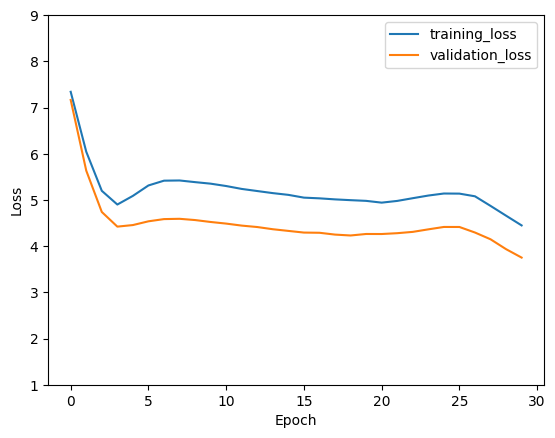

In [286]:

plot_learning_curve_loss(history['fold_1'], 1, 9)


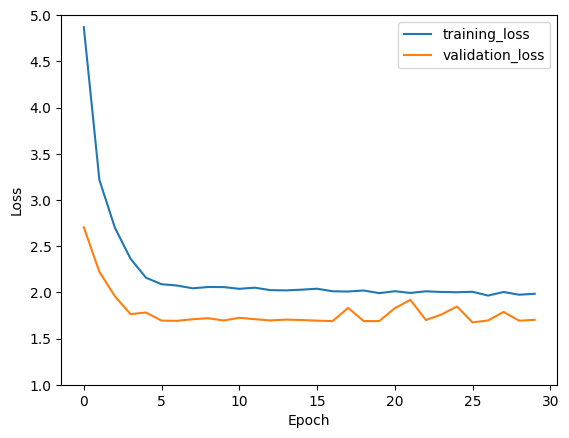

In [289]:

plot_learning_curve_loss(history['fold_2'], 1, 5)


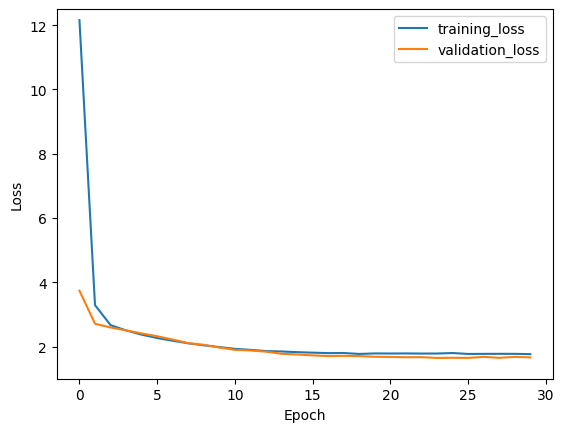

In [295]:

plot_learning_curve_loss(history['fold_3'], 1, 12.5)



## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      # tf.keras.layers.Dropout(0.002)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.001, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=30, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)



In [302]:

history


{'fold_1': {'loss': [2.855166435241699,
   2.683410406112671,
   2.5908706188201904,
   2.445828437805176,
   2.4054198265075684,
   2.311405658721924,
   2.2831883430480957,
   2.2569122314453125,
   2.1924781799316406,
   2.1736183166503906,
   2.154463052749634,
   2.1129465103149414,
   2.0984458923339844,
   2.1071889400482178,
   2.0884475708007812,
   2.0914111137390137,
   2.09967303276062,
   2.09110689163208,
   2.056500196456909,
   2.0789871215820312,
   2.066427707672119,
   2.0571649074554443,
   2.0437827110290527,
   2.0493907928466797,
   2.0559065341949463,
   2.0554866790771484,
   2.044020891189575,
   2.0502617359161377,
   2.037168025970459,
   2.033001661300659],
  'mae': [3.3271822929382324,
   3.1487724781036377,
   3.0592308044433594,
   2.9089772701263428,
   2.8668034076690674,
   2.771010160446167,
   2.742119312286377,
   2.7191519737243652,
   2.646341562271118,
   2.634794235229492,
   2.608164072036743,
   2.567960023880005,
   2.552112102508545,
   2.5

In [303]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(3.971599507331848, 5.285162091255188, 4.566310822963715)

In [304]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(3.2835040211677553, 4.587399029731751, 3.872467911243439)

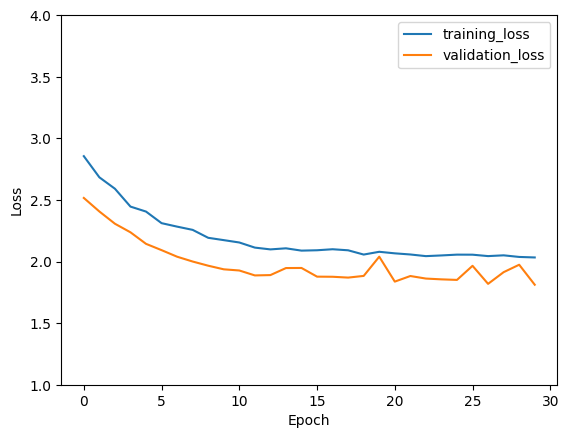

In [306]:

plot_learning_curve_loss(history['fold_1'], 1, 4)


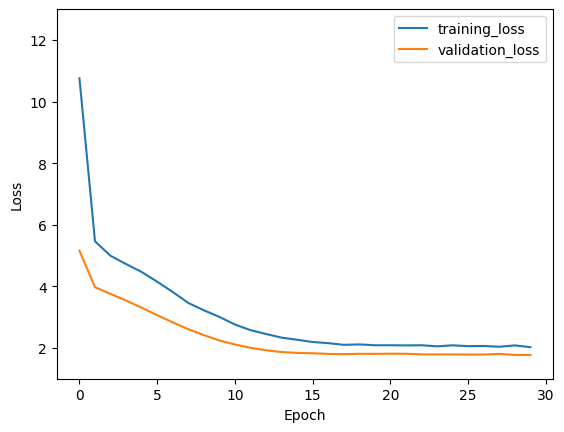

In [309]:

plot_learning_curve_loss(history['fold_2'], 1, 13)


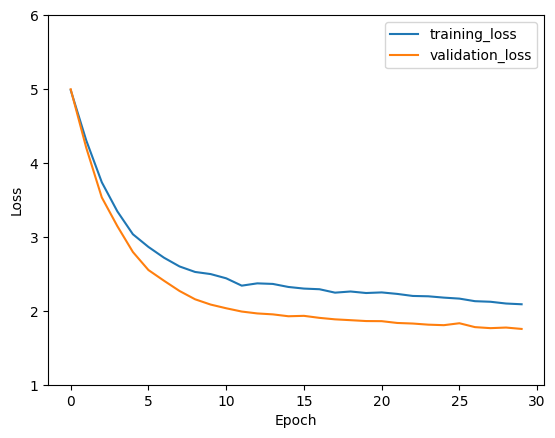

In [313]:

plot_learning_curve_loss(history['fold_3'], 1, 6)



## With the following setup: added the conv filter to the architecture

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      # tf.keras.layers.Dropout(0.002)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.001, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [320]:

history


{'fold_1': {'loss': [5.438212871551514,
   5.139883041381836,
   4.967222213745117,
   4.5011210441589355,
   4.0731401443481445,
   3.848963975906372,
   3.6262307167053223,
   3.3472695350646973,
   3.227760076522827,
   2.9915664196014404,
   2.8559041023254395,
   2.7336015701293945,
   2.6419854164123535,
   2.589625835418701,
   2.495943307876587,
   2.422386884689331,
   2.4832777976989746,
   2.4675333499908447,
   2.4995405673980713,
   2.420868396759033],
  'mae': [5.924555778503418,
   5.621687889099121,
   5.449041843414307,
   4.982333660125732,
   4.550354957580566,
   4.322854995727539,
   4.0970234870910645,
   3.8233273029327393,
   3.6999101638793945,
   3.459916591644287,
   3.3189194202423096,
   3.2007293701171875,
   3.105776309967041,
   3.0562539100646973,
   2.9614098072052,
   2.887246608734131,
   2.953122854232788,
   2.9317235946655273,
   2.9618444442749023,
   2.8870465755462646],
  'val_loss': [4.867247104644775,
   4.484691619873047,
   4.18136215209960

In [321]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(3.809753978252411, 2.8336248278617857, 3.7638794779777527)

In [322]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(3.338601863384247, 2.3718570828437806, 3.2991425514221193)

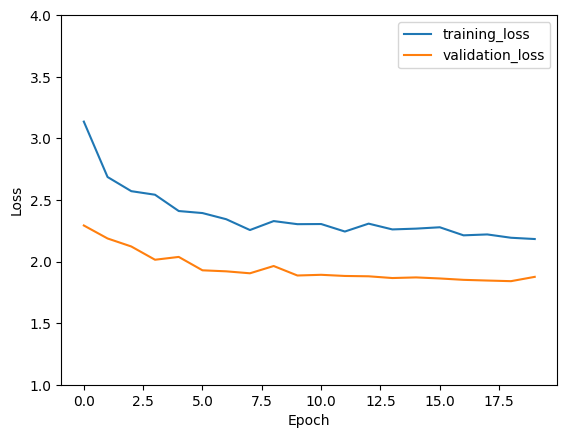

In [324]:

plot_learning_curve_loss(history['fold_2'], 1, 4)


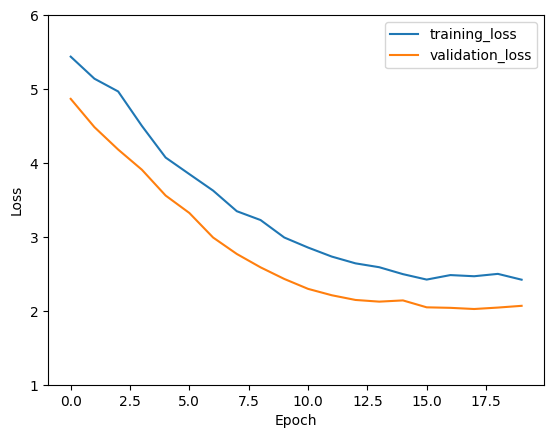

In [327]:

plot_learning_curve_loss(history['fold_1'], 1, 6)


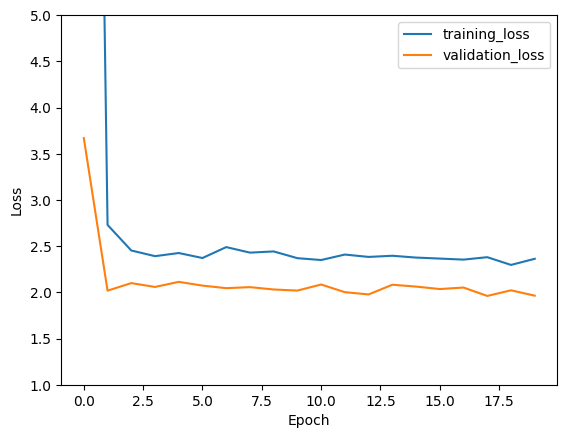

In [334]:

plot_learning_curve_loss(history['fold_3'], 1, 5)



## With the following setup the loss started from 45 range so I interrupted the model progress

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      # tf.keras.layers.Dropout(0.002)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)



## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      # tf.keras.layers.Dropout(0.002)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [352]:

history


{'fold_1': {'loss': [15.586295127868652,
   3.7775473594665527,
   2.7288708686828613,
   2.6858952045440674,
   2.6126389503479004,
   2.5913589000701904,
   2.6124460697174072,
   2.612363338470459,
   2.494222402572632,
   2.470937490463257,
   2.47322154045105,
   2.465998411178589,
   2.47184157371521,
   2.385491132736206,
   2.35646653175354,
   2.3569960594177246,
   2.386864185333252,
   2.3461549282073975,
   2.2459702491760254,
   2.2681398391723633],
  'mae': [16.08465003967285,
   4.249016284942627,
   3.193817615509033,
   3.1514148712158203,
   3.0791077613830566,
   3.053743362426758,
   3.0742228031158447,
   3.0779035091400146,
   2.95883846282959,
   2.9327433109283447,
   2.9334449768066406,
   2.9330132007598877,
   2.9321417808532715,
   2.8411126136779785,
   2.8124289512634277,
   2.819741725921631,
   2.849043607711792,
   2.8055131435394287,
   2.7088277339935303,
   2.7261264324188232],
  'val_loss': [6.438356399536133,
   2.179705858230591,
   2.180727958679

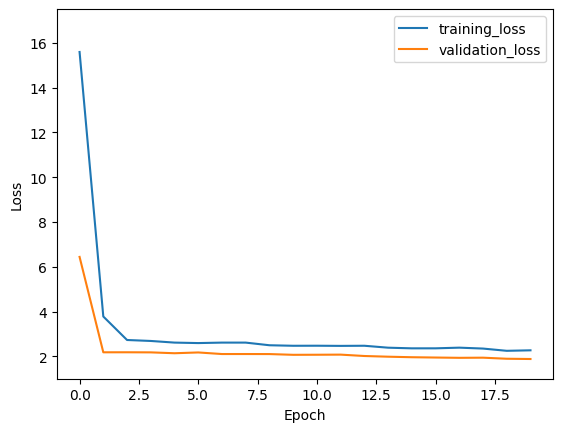

In [354]:

plot_learning_curve_loss(history['fold_1'], 1, 17.5)


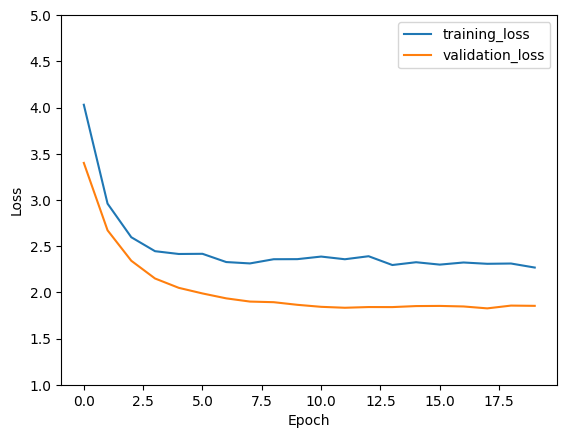

In [357]:

plot_learning_curve_loss(history['fold_2'], 1, 5)


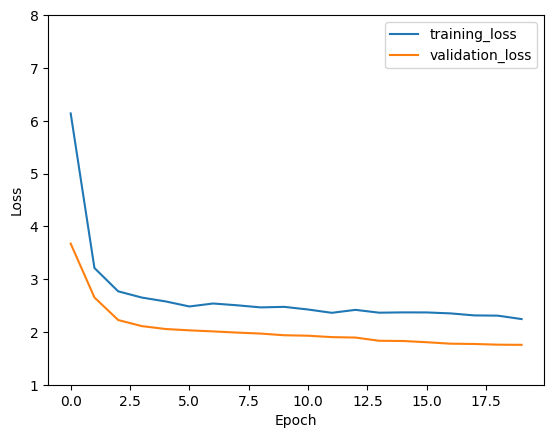

In [359]:

plot_learning_curve_loss(history['fold_3'], 1, 8)


In [360]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(3.6608426094055178, 2.9374783396720887, 3.1301959991455077)

In [361]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(3.196486008167267, 2.474416363239288, 2.6666547656059265)


## With the following setup: added a separate Dropout layer on top of the existing architecture

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Dropout(0.001)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [369]:

history


{'fold_1': {'loss': [6.729382038116455,
   4.123124599456787,
   4.142192840576172,
   3.8968665599823,
   4.045149803161621,
   3.8381764888763428,
   3.796630620956421,
   3.8586618900299072,
   3.7600467205047607,
   3.6553845405578613,
   3.727647542953491,
   3.5528743267059326,
   3.5898005962371826,
   3.5829577445983887,
   3.508847713470459,
   3.4913253784179688,
   3.4208688735961914,
   3.4859189987182617,
   3.3501360416412354,
   3.4456276893615723],
  'mae': [7.215035915374756,
   4.60188627243042,
   4.619936466217041,
   4.371804237365723,
   4.518929958343506,
   4.312390327453613,
   4.2684454917907715,
   4.338332653045654,
   4.230821132659912,
   4.126714706420898,
   4.200565338134766,
   4.026731967926025,
   4.066361427307129,
   4.0549774169921875,
   3.9819719791412354,
   3.9633078575134277,
   3.8928282260894775,
   3.9591898918151855,
   3.8252358436584473,
   3.9152309894561768],
  'val_loss': [4.356296539306641,
   3.7454593181610107,
   3.70043230056762

In [370]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(4.324534904956818, 3.377318334579468, 2.976844680309296)

In [371]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(3.8500810503959655, 2.912240135669708, 2.515406060218811)


## With the following setup: moved this layer tf.keras.layers.Dropout(0.001) around

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Dropout(0.001),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)


In [379]:

history


{'fold_1': {'loss': [7.4158501625061035,
   5.064929008483887,
   4.490432262420654,
   4.216270446777344,
   3.8813273906707764,
   3.5911478996276855,
   3.418954610824585,
   3.2553281784057617,
   3.1859893798828125,
   2.9906504154205322,
   2.8773715496063232,
   2.7908945083618164,
   2.6831769943237305,
   2.6546809673309326,
   2.6491622924804688,
   2.5776407718658447,
   2.6083202362060547,
   2.624960422515869,
   2.5565292835235596,
   2.557889223098755],
  'mae': [7.905712127685547,
   5.5467939376831055,
   4.966040134429932,
   4.692502498626709,
   4.357099533081055,
   4.065106391906738,
   3.888486385345459,
   3.726138114929199,
   3.653093099594116,
   3.4607303142547607,
   3.3427674770355225,
   3.261335849761963,
   3.1504220962524414,
   3.1165125370025635,
   3.1127545833587646,
   3.0437166690826416,
   3.070129632949829,
   3.092664957046509,
   3.017761707305908,
   3.0221123695373535],
  'val_loss': [5.494499206542969,
   5.018685817718506,
   4.5282678604

In [380]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(3.8745940208435057, 11.080397176742554, 4.65836671590805)

In [381]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(3.404575300216675, 10.590571904182434, 4.188943755626679)


## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_dataset, epochs=30, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)              


In [404]:

history


{'fold_1': {'loss': [6.035131454467773,
   4.180610656738281,
   3.6002447605133057,
   3.101811170578003,
   2.776789426803589,
   2.5962204933166504,
   2.459012508392334,
   2.374814748764038,
   2.367713212966919,
   2.384552240371704,
   2.3506486415863037,
   2.338071346282959,
   2.319953203201294,
   2.2942240238189697,
   2.366231679916382,
   2.2809619903564453,
   2.2833213806152344,
   2.2937021255493164,
   2.3720784187316895,
   2.27215838432312,
   2.280867576599121,
   2.2510645389556885,
   2.282656669616699,
   2.2417752742767334,
   2.210927724838257,
   2.270817518234253,
   2.240992784500122,
   2.2807435989379883,
   2.266014814376831,
   2.208550214767456],
  'mae': [6.51516580581665,
   4.653299331665039,
   4.0729899406433105,
   3.5755245685577393,
   3.2464733123779297,
   3.059953451156616,
   2.9205260276794434,
   2.829481840133667,
   2.8316986560821533,
   2.8467493057250977,
   2.807513475418091,
   2.7915844917297363,
   2.7784616947174072,
   2.754055

In [405]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(4.572690868377686, 5.475878822803497, 5.139343047142029)

In [406]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(3.879133129119873, 4.782630735635758, 4.440188825130463)

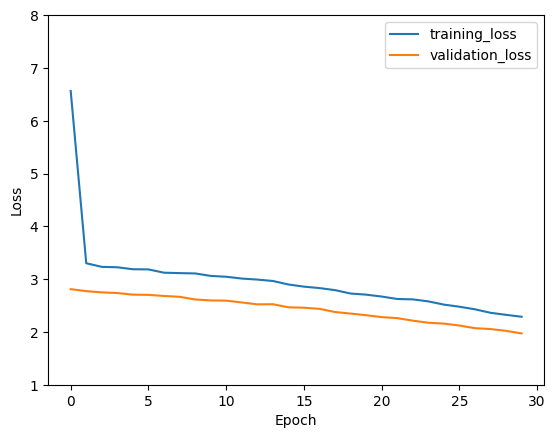

In [407]:

plot_learning_curve_loss(history['fold_3'], 1, 8)


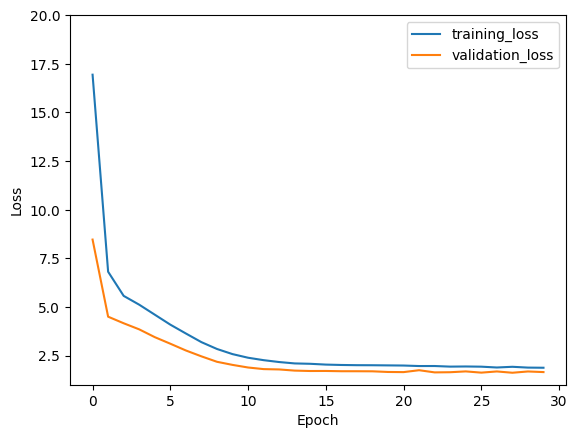

In [409]:

plot_learning_curve_loss(history['fold_2'], 1, 20)


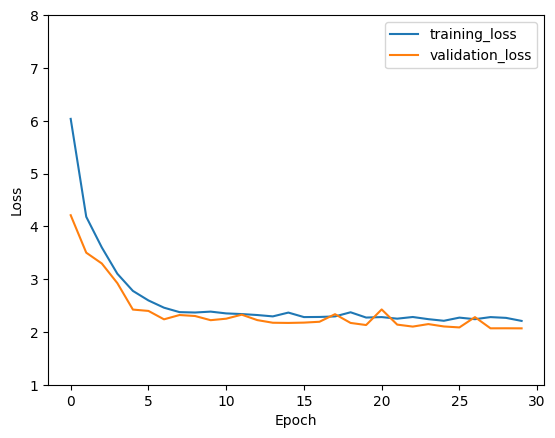

In [410]:

plot_learning_curve_loss(history['fold_1'], 1, 8)


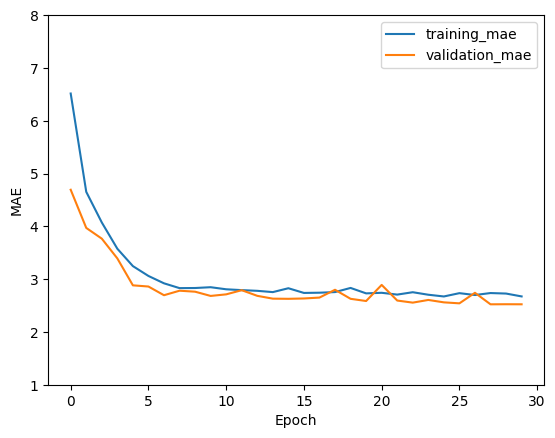

In [411]:

plot_learning_curve_metric(history['fold_1'], 1, 8)



## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [423]:
history

{'fold_1': {'loss': [29.552942276000977,
   16.23550033569336,
   5.975656986236572,
   2.850904703140259,
   2.6922190189361572,
   2.642930030822754,
   2.6351430416107178,
   2.598252296447754,
   2.574688196182251,
   2.53391170501709,
   2.489183187484741,
   2.489551544189453,
   2.455061674118042,
   2.4405581951141357,
   2.4041199684143066,
   2.3894314765930176,
   2.3898777961730957,
   2.3776695728302,
   2.341656446456909,
   2.324289083480835],
  'mae': [30.052942276000977,
   16.735218048095703,
   6.466773509979248,
   3.318138360977173,
   3.1558971405029297,
   3.104585886001587,
   3.0983991622924805,
   3.060382604598999,
   3.040907144546509,
   2.999192953109741,
   2.9506006240844727,
   2.952468156814575,
   2.921175241470337,
   2.9060001373291016,
   2.8641245365142822,
   2.854118824005127,
   2.8536970615386963,
   2.8406739234924316,
   2.804210901260376,
   2.7899417877197266],
  'val_loss': [22.046079635620117,
   9.830852508544922,
   2.9763472080230713,

In [424]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(5.188472414016724, 4.313435614109039, 2.46324508190155)

In [425]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(4.719677376747131, 3.8397549033164977, 2.0085791110992433)

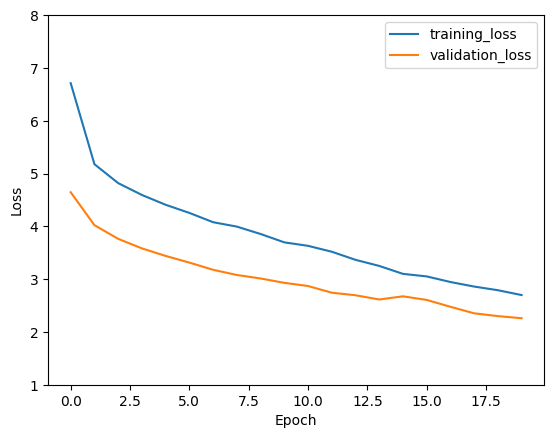

In [428]:

plot_learning_curve_loss(history['fold_2'], 1, 8)


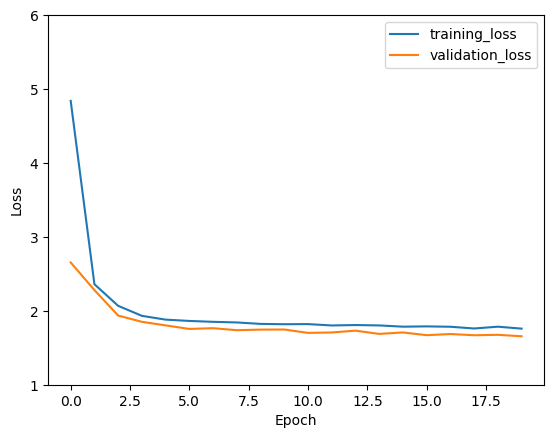

In [430]:

plot_learning_curve_loss(history['fold_3'], 1, 6)


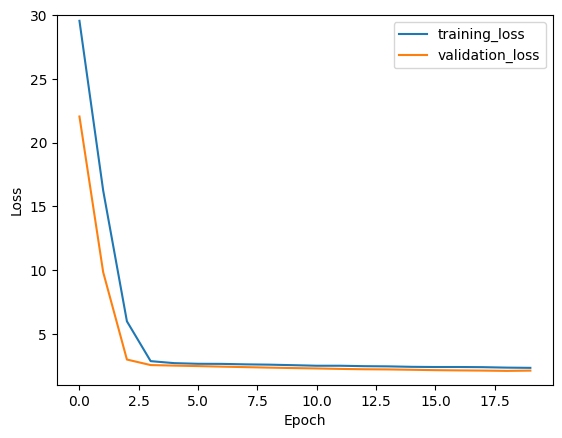

In [435]:

plot_learning_curve_loss(history['fold_1'], 1, 30)



## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [443]:

history


{'fold_1': {'loss': [6.4852213859558105,
   6.1039228439331055,
   5.753785133361816,
   5.33493185043335,
   4.901934623718262,
   4.572413444519043,
   4.207752704620361,
   3.90488600730896,
   3.6292471885681152,
   3.42547345161438,
   3.2819666862487793,
   3.1178956031799316,
   2.9814095497131348,
   2.9404754638671875,
   2.9129581451416016,
   2.8213186264038086,
   2.7987143993377686,
   2.7824130058288574,
   2.776118040084839,
   2.7381575107574463],
  'mae': [6.968541622161865,
   6.589456081390381,
   6.239090919494629,
   5.81980037689209,
   5.384851932525635,
   5.049736022949219,
   4.685529708862305,
   4.37941312789917,
   4.100095748901367,
   3.8995866775512695,
   3.7563915252685547,
   3.5846118927001953,
   3.448640823364258,
   3.4026713371276855,
   3.3788256645202637,
   3.287447214126587,
   3.2606582641601562,
   3.2471470832824707,
   3.241685628890991,
   3.204180955886841],
  'val_loss': [5.508621692657471,
   5.078566074371338,
   4.759108066558838,
 

In [444]:

sum(history['fold_1']['mae'])/20, sum(history['fold_2']['mae'])/20, sum(history['fold_3']['mae'])/20


(4.3464181303977965, 3.7373069167137145, 3.1155236959457397)

In [445]:

sum(history['fold_1']['loss'])/20, sum(history['fold_2']['loss'])/20, sum(history['fold_3']['loss'])/20


(3.873549783229828, 3.267404866218567, 2.6516258001327513)

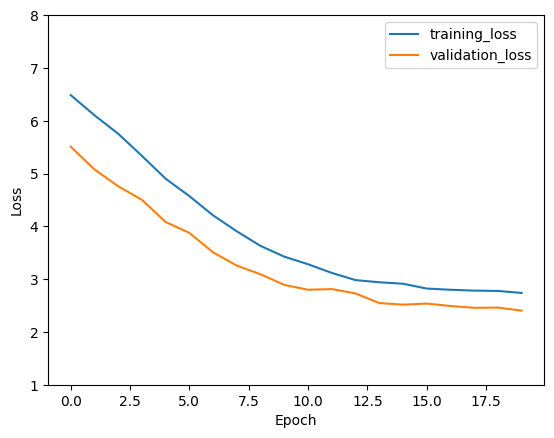

In [448]:

plot_learning_curve_loss(history['fold_1'], 1, 8)


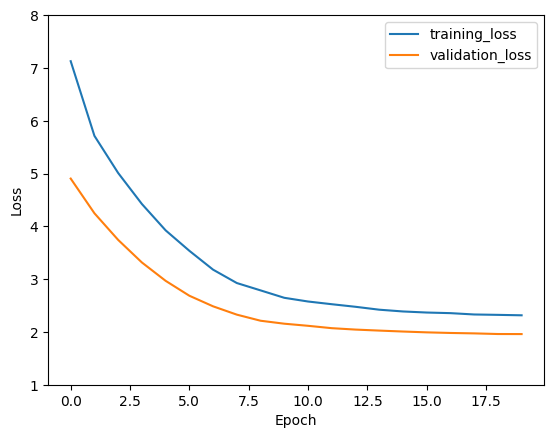

In [450]:

plot_learning_curve_loss(history['fold_2'], 1, 8)


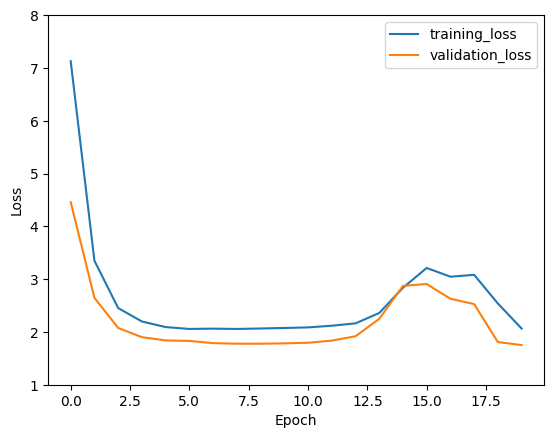

In [452]:

plot_learning_curve_loss(history['fold_3'], 1, 8)


## with the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

batch_size = 60 (???)

In [476]:

history


{'fold_1': {'loss': [17.263479232788086,
   8.577635765075684,
   3.369701862335205,
   2.3875646591186523,
   2.2980594635009766,
   2.2934916019439697,
   2.248061180114746,
   2.224487066268921,
   2.1945292949676514,
   2.1958985328674316,
   2.1713578701019287,
   2.158881664276123,
   2.1084330081939697,
   2.1011881828308105,
   2.109809160232544,
   2.04801869392395,
   2.072301149368286,
   2.0797581672668457,
   2.1061949729919434,
   2.051809549331665,
   2.0716969966888428,
   2.0521950721740723,
   2.050642728805542,
   2.0508546829223633,
   2.0242574214935303,
   2.0252504348754883,
   2.0379295349121094,
   2.052799940109253,
   2.0316615104675293,
   2.0044493675231934],
  'mae': [17.763477325439453,
   9.075143814086914,
   3.847902774810791,
   2.855853319168091,
   2.757786273956299,
   2.7552661895751953,
   2.705172300338745,
   2.68469500541687,
   2.6529457569122314,
   2.6506433486938477,
   2.6289079189300537,
   2.6101768016815186,
   2.557892322540283,
   2.

In [500]:

sum(history['fold_1']['mae'])/30, sum(history['fold_2']['mae'])/30, sum(history['fold_3']['mae'])/30


(2.6171945015589397, 3.320527998606364, 4.429239940643311)

In [501]:

sum(history['fold_1']['loss'])/30, sum(history['fold_2']['loss'])/30, sum(history['fold_3']['loss'])/30


(2.1575020710627237, 2.853800717989604, 3.965202498435974)

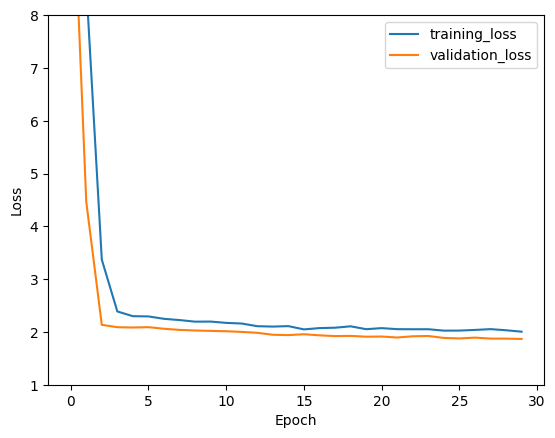

In [479]:

plot_learning_curve_loss(history['fold_1'], 1, 8)


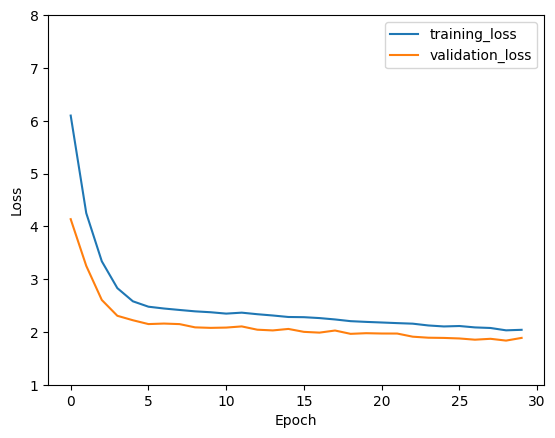

In [480]:

plot_learning_curve_loss(history['fold_2'], 1, 8)


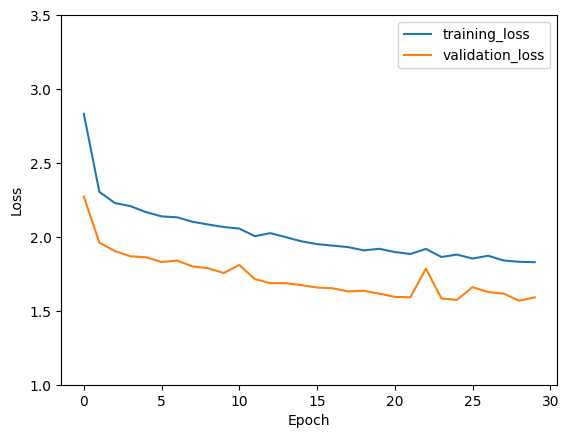

In [482]:

plot_learning_curve_loss(history['fold_3'], 1, 3.5)



## With the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

batch_size = 40

In [491]:

history


{'fold_1': {'loss': [2.8489646911621094,
   2.396310567855835,
   2.3578433990478516,
   2.3172478675842285,
   2.267852544784546,
   2.258078098297119,
   2.2391602993011475,
   2.2438578605651855,
   2.2018496990203857,
   2.188478946685791,
   2.1350419521331787,
   2.137145757675171,
   2.1095151901245117,
   2.1314005851745605,
   2.101012945175171,
   2.101766586303711,
   2.109807014465332,
   2.0851430892944336,
   2.0634195804595947,
   2.057717800140381,
   2.04974102973938,
   2.0622854232788086,
   2.014012575149536,
   2.0600922107696533,
   2.0424294471740723,
   2.054659843444824,
   2.0275700092315674,
   2.0196175575256348,
   2.021446466445923,
   2.0215930938720703],
  'mae': [3.320404529571533,
   2.8632917404174805,
   2.8218276500701904,
   2.779691219329834,
   2.7355828285217285,
   2.72175931930542,
   2.7018282413482666,
   2.7085752487182617,
   2.66447114944458,
   2.6486170291900635,
   2.595752000808716,
   2.595669984817505,
   2.5696682929992676,
   2.58

In [503]:

sum(history['fold_1']['mae'])/30, sum(history['fold_2']['mae'])/30, sum(history['fold_3']['mae'])/30


(2.6171945015589397, 3.320527998606364, 4.429239940643311)

In [504]:

sum(history['fold_1']['loss'])/30, sum(history['fold_2']['loss'])/30, sum(history['fold_3']['loss'])/30


(2.1575020710627237, 2.853800717989604, 3.965202498435974)

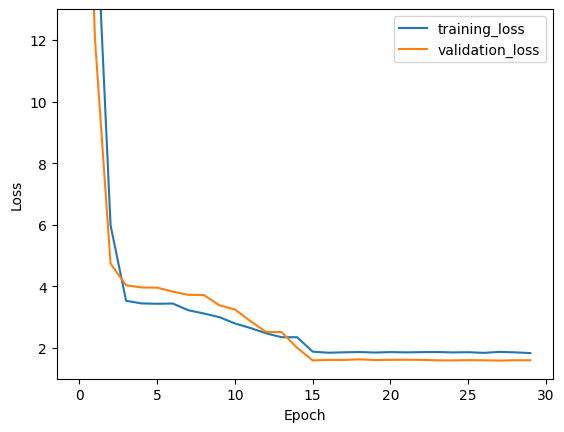

In [495]:

plot_learning_curve_loss(history['fold_3'], 1, 13)


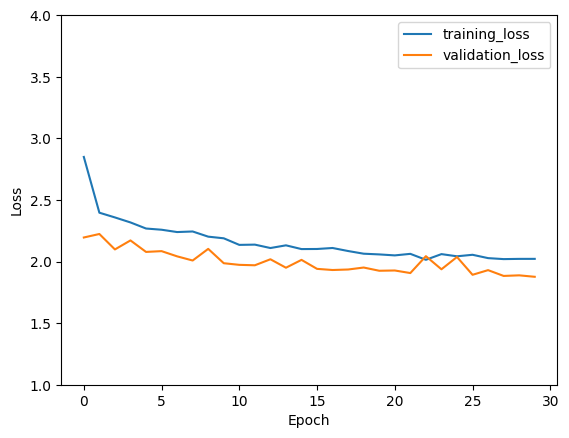

In [497]:

plot_learning_curve_loss(history['fold_1'], 1, 4)


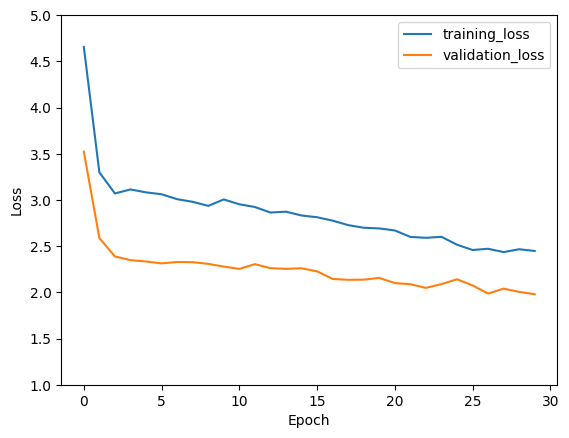

In [499]:

plot_learning_curve_loss(history['fold_2'], 1, 5)


In [505]:

sum(history['fold_1']['mae'])/30, sum(history['fold_2']['mae'])/30, sum(history['fold_3']['mae'])/30


(2.6171945015589397, 3.320527998606364, 4.429239940643311)

In [506]:

sum(history['fold_1']['loss'])/30, sum(history['fold_2']['loss'])/30, sum(history['fold_3']['loss'])/30


(2.1575020710627237, 2.853800717989604, 3.965202498435974)

In [ ]:


epochs = 30
window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-4, momentum=0.4)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])



In [527]:
history

{'fold_1': {'loss': [18.276695251464844,
   4.618947505950928,
   3.604276657104492,
   3.437683343887329,
   3.3719146251678467,
   3.2680437564849854,
   3.2320077419281006,
   3.1523244380950928,
   3.1037800312042236,
   3.0655148029327393,
   3.0833401679992676,
   2.9523565769195557,
   2.9487619400024414,
   2.953237771987915,
   2.923147439956665,
   2.9237477779388428,
   2.8750829696655273,
   2.868614435195923,
   2.833840847015381,
   2.7905454635620117,
   2.7729477882385254,
   2.7271230220794678,
   2.685065507888794,
   2.7042806148529053,
   2.655007839202881,
   2.6439321041107178,
   2.612478017807007,
   2.5644850730895996,
   2.5594499111175537,
   2.5037970542907715],
  'mae': [18.774208068847656,
   5.098631858825684,
   4.079665660858154,
   3.9134788513183594,
   3.845592975616455,
   3.739414930343628,
   3.702848196029663,
   3.6202986240386963,
   3.575766086578369,
   3.5346851348876953,
   3.552324056625366,
   3.4182512760162354,
   3.4172139167785645,
  

In [528]:

sum(history['fold_1']['mae'])/30, sum(history['fold_2']['mae'])/30, sum(history['fold_3']['mae'])/30


(3.959774438540141, 5.072799142201742, 3.203636121749878)

In [529]:

sum(history['fold_1']['loss'])/30, sum(history['fold_2']['loss'])/30, sum(history['fold_3']['loss'])/30


(3.490414349238078, 4.597991601626078, 2.7440892100334167)

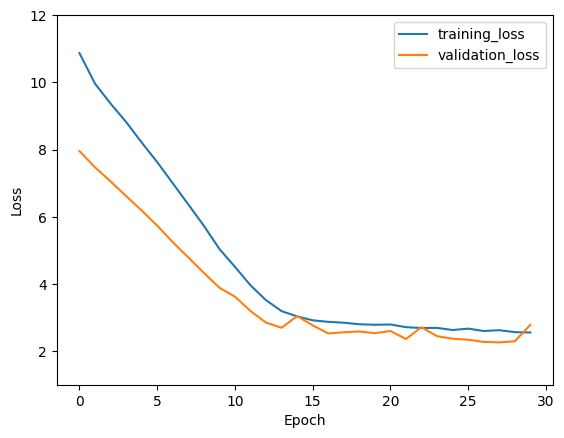

In [533]:

plot_learning_curve_loss(history['fold_2'], 1, 12)


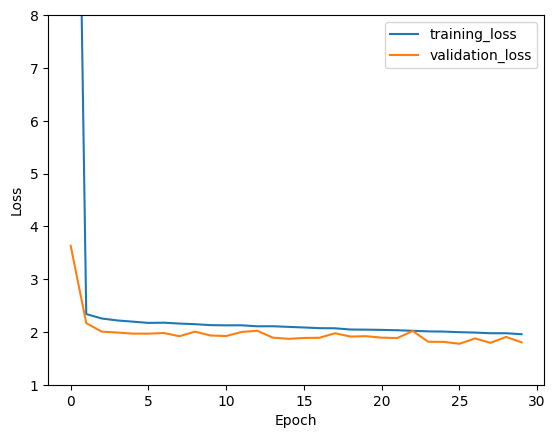

In [537]:

plot_learning_curve_loss(history['fold_3'], 1, 8)


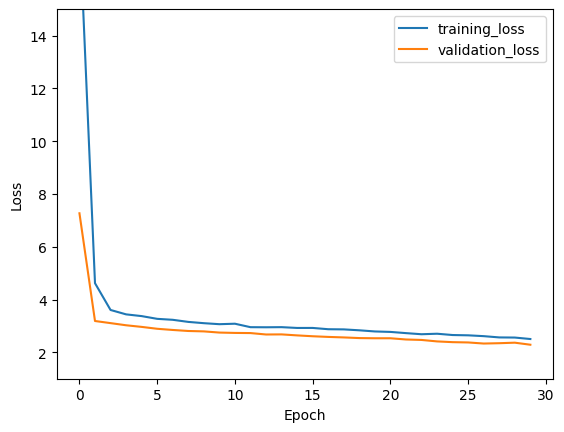

In [539]:

plot_learning_curve_loss(history['fold_1'], 1, 15)



## With the following setup

window_size = 60
batch_size = 32
n_splits = 3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [552]:

history


{'fold_1': {'loss': [5.265644550323486,
   4.3927812576293945,
   4.182635307312012,
   4.055756092071533,
   3.866091012954712,
   3.761840581893921,
   3.6053240299224854,
   3.5082430839538574,
   3.420180559158325,
   3.322047472000122,
   3.2298903465270996,
   3.108722686767578,
   3.1427242755889893,
   3.0202560424804688,
   2.9543871879577637,
   2.88510799407959,
   2.858504056930542,
   2.805262327194214,
   2.6607022285461426,
   2.6835618019104004,
   2.689425230026245,
   2.5856337547302246,
   2.4945414066314697,
   2.52876353263855,
   2.4692366123199463,
   2.445552349090576,
   2.4315056800842285,
   2.405818223953247,
   2.3718984127044678,
   2.399885416030884],
  'mae': [5.74930477142334,
   4.873022556304932,
   4.667070388793945,
   4.538002014160156,
   4.345498561859131,
   4.2416205406188965,
   4.075305461883545,
   3.9817707538604736,
   3.8916711807250977,
   3.799804925918579,
   3.6999261379241943,
   3.578052282333374,
   3.611901044845581,
   3.48800277

In [553]:

sum(history['fold_1']['mae'])/30, sum(history['fold_2']['mae'])/30, sum(history['fold_3']['mae'])/30


(3.5882632811864217, 3.1286853075027468, 2.6550549983978273)

In [554]:

sum(history['fold_1']['loss'])/30, sum(history['fold_2']['loss'])/30, sum(history['fold_3']['loss'])/30


(3.1183974504470826, 2.665362274646759, 2.19758003950119)

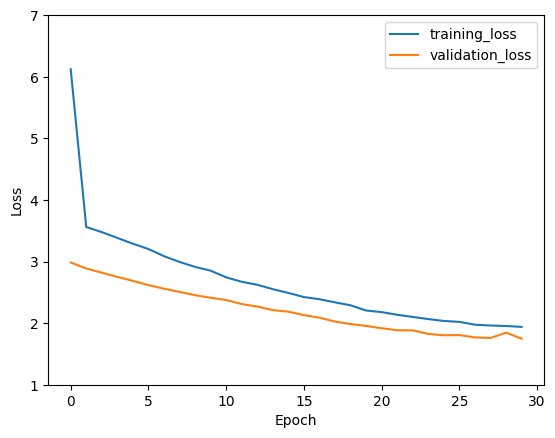

In [556]:

plot_learning_curve_loss(history['fold_2'], 1, 7)


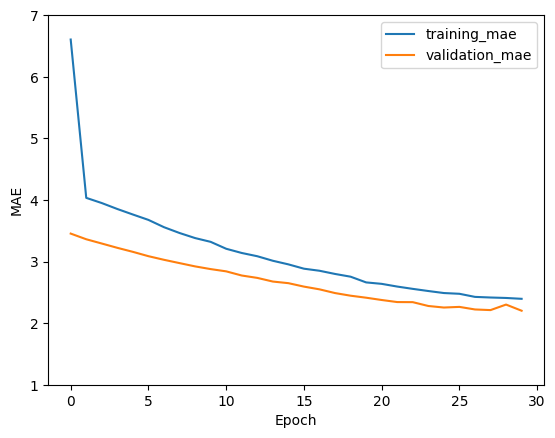

In [562]:

plot_learning_curve_metric(history['fold_2'], 1, 7)


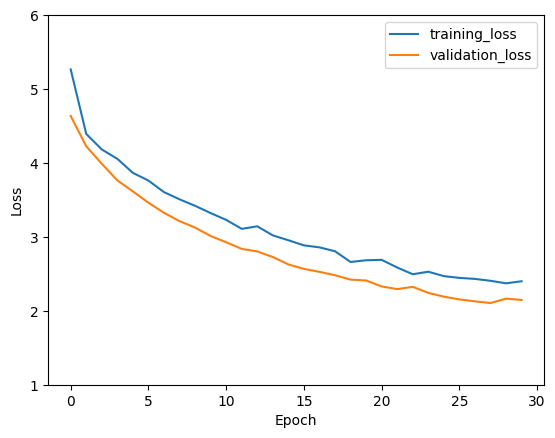

In [558]:

plot_learning_curve_loss(history['fold_1'], 1, 6)


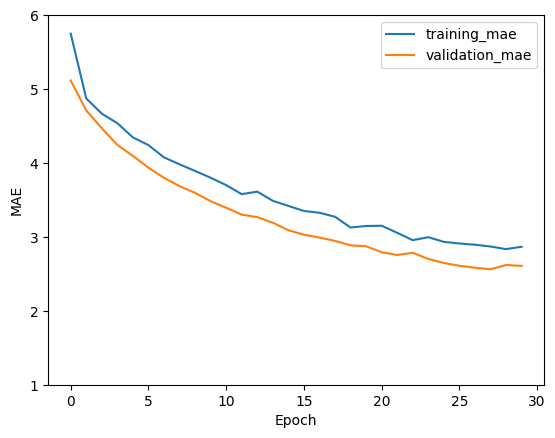

In [563]:

plot_learning_curve_metric(history['fold_1'], 1, 6)


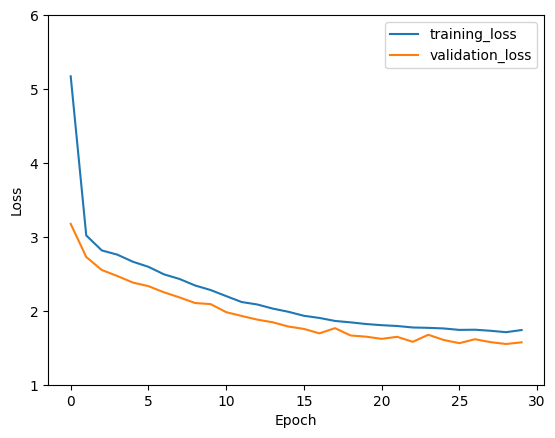

In [560]:

plot_learning_curve_loss(history['fold_3'], 1, 6)


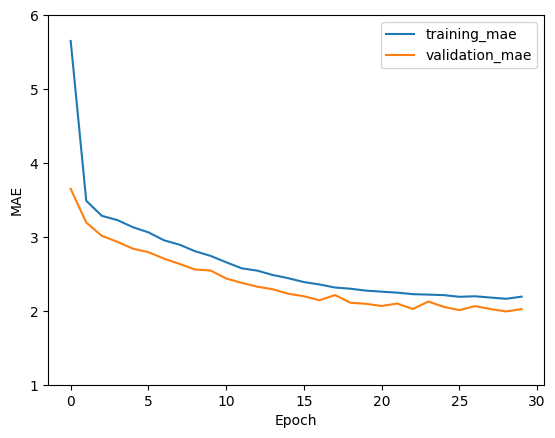

In [561]:

plot_learning_curve_metric(history['fold_3'], 1, 6)



## Trying for the first time in this project context mse instead of mae. This is to understand how the model performs with mse as chosen metric.

window_size = 60
batch_size = 64
n_splits = 3
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])


In [584]:

history


{'fold_1': {'loss': [7.589296340942383,
   3.536207675933838,
   3.1113178730010986,
   2.7779204845428467,
   2.5549521446228027,
   2.4308080673217773,
   2.293954610824585,
   2.254549264907837,
   2.2569782733917236,
   2.1985135078430176,
   2.143876791000366,
   2.104083299636841,
   2.1441094875335693,
   2.1050398349761963,
   2.0710740089416504,
   2.0619444847106934,
   2.048663854598999,
   2.049781560897827,
   1.9970579147338867,
   2.033310651779175],
  'mse': [101.37796783447266,
   25.415142059326172,
   20.590913772583008,
   17.507001876831055,
   15.11758804321289,
   14.143829345703125,
   12.53206729888916,
   12.114312171936035,
   11.816852569580078,
   11.514470100402832,
   11.069031715393066,
   10.682223320007324,
   10.986068725585938,
   10.48802661895752,
   10.224466323852539,
   10.246817588806152,
   10.136401176452637,
   10.176619529724121,
   9.630589485168457,
   9.85048770904541],
  'val_loss': [3.494863510131836,
   2.964827299118042,
   2.5911407

In [585]:

def plot_learning_curve_metric(history, lower_limit, upper_limit):
    plt.plot(history['mse'], label='training_mse')
    plt.plot(history['val_mse'], label='validation_mse')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')

def plot_learning_curve_loss(history, lower_limit, upper_limit):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')
    plt.show()


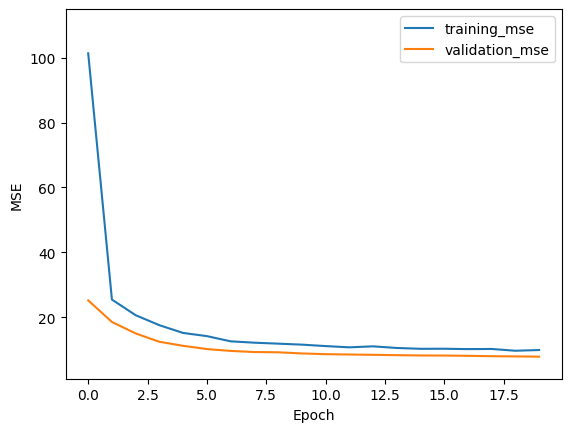

In [586]:

plot_learning_curve_metric(history['fold_1'], 1, 115)


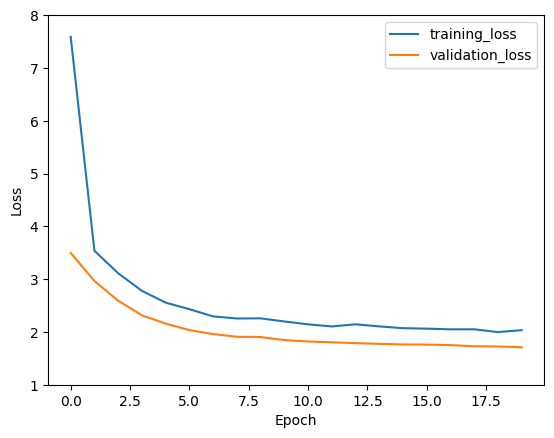

In [589]:

plot_learning_curve_loss(history['fold_1'], 1, 8)


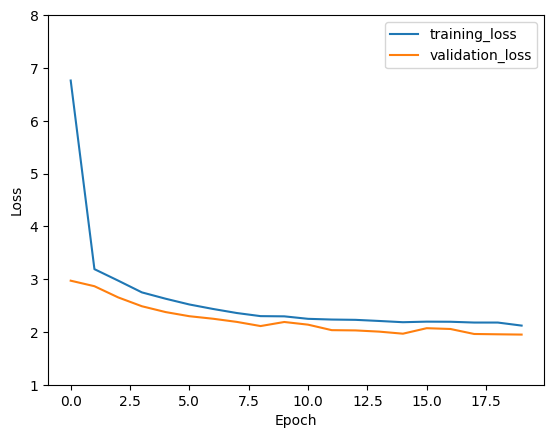

In [590]:

plot_learning_curve_loss(history['fold_2'], 1, 8)


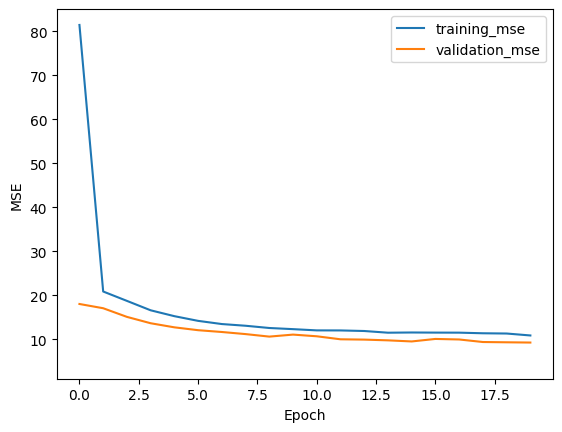

In [592]:

plot_learning_curve_metric(history['fold_2'], 1, 85)


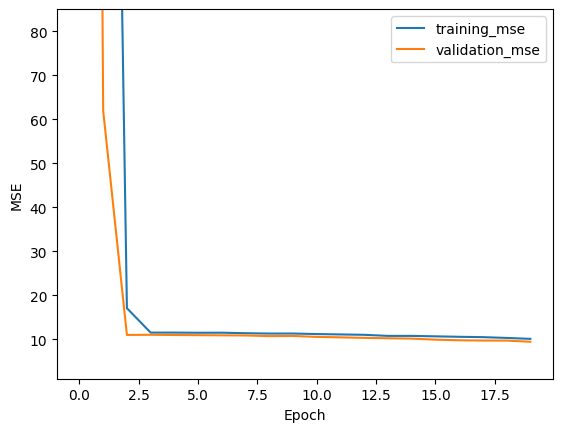

In [593]:

plot_learning_curve_metric(history['fold_3'], 1, 85)


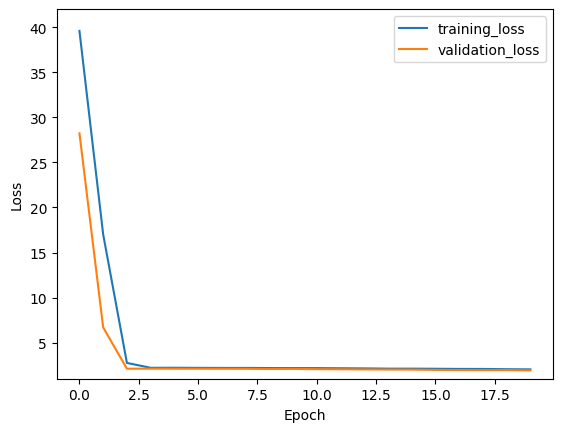

In [595]:

plot_learning_curve_loss(history['fold_3'], 1, 42)


## Summary

So far, I have experimented with different architectures and narrowed it down to one that performs decently on the validation data and does not overfit. This is a good enough model, given that I split the data, which is small to begin with, into train, validation, and testing. So, the validation data is too small to keep going with further experimentations. Let's stop here. 



## How is evaluating the test data going to happen after the experimentations?
Let's merge both the training and validation data and train it using the below-chosen model architecture and then use the trained model to evaluate the test data 


window_size = 60
batch_size = 32
n_splits = 3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=5,
      #                 strides=1, padding="causal",
      #                 activation="relu",
      #                 input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

              

In [599]:

def model_build():
    tf.random.set_seed(51)
    np.random.seed(51)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.02, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    return model



In [605]:

def model_training_predicting(series, lr_schedule, window_size, batch_size, train_shuffle):


    tf.keras.backend.clear_session()

    # Apply your windowed_dataset function to create TF datasets
    train_dataset = windowed_dataset(series, window_size, batch_size, train_shuffle)
    
    # Example model training and evaluation
    model = model_build()  # Function to create your model

    history = model.fit(train_dataset, epochs=50, callbacks=[lr_schedule], verbose=1)
    
    
    return history, model


In [600]:
x_train

array([20.7, 17.9, 18.8, ..., 11.2, 12.7, 13.7])

In [606]:
window_size = 60
batch_size = 32
train_shuffle = 1000
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))

history, final_model = model_training_predicting(x_train, lr_schedule, window_size, batch_size, train_shuffle)


Epoch 1/50
105/105 [==============================] - 39s 260ms/step - loss: 11.2113 - mae: 11.7081 - lr: 1.0000e-06
Epoch 2/50
  1/105 [..............................] - ETA: 11s - loss: 5.7651 - mae: 6.2651

2024-03-22 18:15:09.291172: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6260160670287869228
2024-03-22 18:15:09.291197: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3887403767263975763


105/105 [==============================] - 6s 61ms/step - loss: 4.3852 - mae: 4.8663 - lr: 1.0513e-06
Epoch 3/50
105/105 [==============================] - 6s 61ms/step - loss: 3.0687 - mae: 3.5385 - lr: 1.1052e-06
Epoch 4/50
105/105 [==============================] - 6s 60ms/step - loss: 2.9948 - mae: 3.4624 - lr: 1.1618e-06
Epoch 5/50
105/105 [==============================] - 6s 60ms/step - loss: 2.9528 - mae: 3.4214 - lr: 1.2214e-06
Epoch 6/50
105/105 [==============================] - 6s 58ms/step - loss: 2.9271 - mae: 3.3952 - lr: 1.2840e-06
Epoch 7/50
105/105 [==============================] - 6s 58ms/step - loss: 2.8840 - mae: 3.3511 - lr: 1.3499e-06
Epoch 8/50
105/105 [==============================] - 6s 58ms/step - loss: 2.8892 - mae: 3.3558 - lr: 1.4191e-06
Epoch 9/50
105/105 [==============================] - 6s 60ms/step - loss: 2.8193 - mae: 3.2857 - lr: 1.4918e-06
Epoch 10/50
105/105 [==============================] - 6s 60ms/step - loss: 2.7983 - mae: 3.2662 - lr: 1.56

In [607]:

final_model


In [610]:

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast


In [608]:
x_test

array([11.5, 10.4,  8.9, 11.1,  9.5, 13. , 13.9, 12.6, 14.3, 16. , 13.3,
        7. ,  4.9,  6.9, 13.7, 10.6, 12.3, 11.1, 10.2,  9.5,  8.9, 13.4,
        9.1,  9.4,  8.7,  5.8,  4.5,  7.2, 10. , 10.5, 10.7,  8.2,  6.1,
        4.5,  6.1,  9.8,  9.7,  8.2,  8.4,  8.5, 10.4,  6.8,  6. ,  6.6,
        7.8, 10.3,  7.2,  7.4, 11.4,  5.4,  4.4,  6.4,  9.3,  7.7,  8.1,
        8.3,  9.1,  7.7, 10.6,  8.2,  7.9,  5.2,  5.9,  3.7,  5.6,  9.4,
        7.4,  7.3,  7.7,  7.7,  9.3,  4.4,  5.7, 10.2, 10.2,  9.3,  5.4,
        5. ,  7.6,  9.6, 10.4, 11.2,  9.1, 11.2,  6.8,  8.3,  9.7,  9.6,
        9.8, 10.8,  9.2,  6.5,  8.1,  7.3,  7.9,  6. ,  5. ,  6.8,  9.8,
        5.7,  8.6, 10.6,  7.8,  7.7,  8.6,  6.5,  6.9,  6.4,  8.5,  7.8,
        9.3,  8.4,  7.8,  7.4,  7.7,  8.9,  9.7,  9.9,  6.1,  6.6,  7.6,
        7.4,  8. ,  2.1,  5.9, 11.6,  8.6,  7.9,  6. ,  9.5,  8.6,  7.6,
       10.4, 10.3,  7.5,  3. ,  5.3, 10.5, 14.6, 12.6,  9.8,  7.2, 10.1,
       10.4,  3.7,  7.3, 11.6, 16.3,  9.6,  6.8,  5

In [609]:
len(x_test)

250

In [ ]:

forecast = model_forecast(final_model, , window_size, batch_size)


In [614]:
forecast.squeeze()

array([ 9.291455 ,  9.178797 ,  9.245439 ,  9.601075 ,  9.652211 ,
        9.877874 ,  9.81278  ,  9.600137 ,  9.53173  ,  9.153413 ,
        8.17804  ,  7.1368613,  7.5691676,  8.550873 ,  9.553204 ,
        9.363825 ,  9.642295 ,  9.470463 ,  9.237454 ,  9.028279 ,
        9.129533 ,  9.562706 ,  8.848335 ,  8.7207365,  8.458006 ,
        8.06464  ,  8.539023 ,  9.733652 , 10.371598 , 10.300651 ,
        9.973787 ,  9.1451845,  8.712555 ,  8.906655 ,  9.804537 ,
       10.448073 , 10.124389 ,  9.611793 ,  9.319834 ,  9.137958 ,
        8.876694 ,  7.814289 ,  7.954617 ,  8.388128 ,  8.753732 ,
        8.931635 ,  8.2697   ,  8.315537 ,  8.359499 ,  6.997491 ,
        7.4228992,  8.444146 ,  9.066396 ,  8.847556 ,  9.037108 ,
        9.133006 ,  9.233157 ,  9.091731 ,  9.331887 ,  8.406617 ,
        7.7482147,  6.9853754,  7.2048106,  7.2599792,  8.439349 ,
        8.545557 ,  7.917432 ,  7.7773585,  7.717755 ,  7.5740757,
        7.5124183,  6.9030666,  7.88846  ,  8.874643 ,  8.7078

In [616]:
series

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [617]:
# Reduce the original series
split_time = 3400
# Reduce the original series
forecast_series = series[split_time-window_size:-1]


In [624]:

window_size = 60
batch_size = 32

forecast = model_forecast(final_model, forecast_series, window_size, batch_size)



8/8 [==============================] - 1s 141ms/step


2024-03-22 18:37:11.687581: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10917310133483331885
2024-03-22 18:37:11.687606: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 452598326615737472


In [626]:
len(forecast_series)

309

In [625]:
len(forecast)

250

In [639]:

def plot_series_1(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()




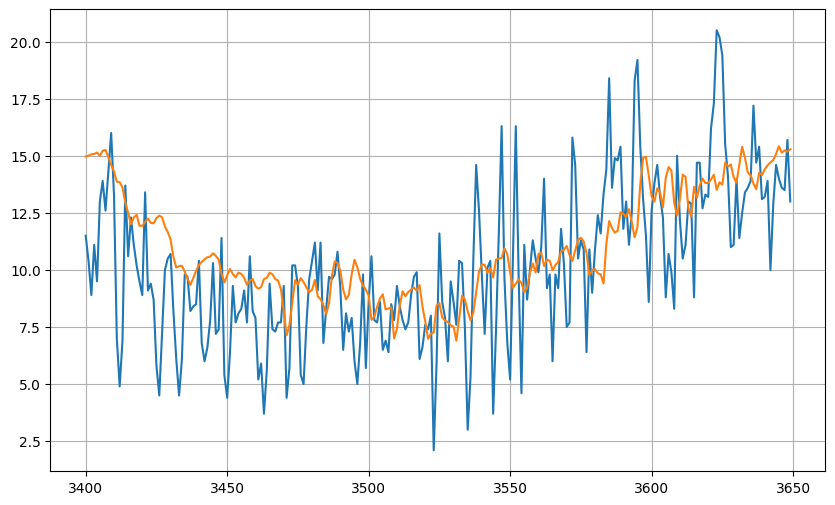

In [640]:


# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series_1(time_test, (x_test, results))


In [641]:

# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_test, results).numpy())


2.254234


## Results

At least I have tried and tested my model and have gathered that it can do a better job forecasting. It has missed the mark. The goal of this exercise is to experiment with a reliable CV loop, and it has paid off already, as we see that evaluating the test data hits the same range as the finalized model's performance (through CV). So yay!

The looming questions were answered through this exercise:
1. Can you build a reliable CV for time series data to trust its results and use the parameters finalized through the CV to create the final model and evaluate the test data?
2. There are many options for finalizing the final model. How did you choose one using a CV?



In [643]:

del results, time_test, series, x_train, time_train, x_test, forecast, forecast_series


In [644]:
gc.collect()

51291

In [645]:


del final_model, model, plot_learning_curve_metric, plot_learning_curve_loss, history 



NameError: name 'model' is not defined